## Problem Statement - Predicting a loyalty score for card_id

What files do I need?
You will need, at a minimum, the train.csv and test.csv files. These contain the card_ids that we'll be using for training and prediction.

The historical_transactions.csv and new_merchant_transactions.csv files contain information about each card's transactions. historical_transactions.csv contains up to 3 months' worth of transactions for every card at any of the provided merchant_ids. new_merchant_transactions.csv contains the transactions at new merchants (merchant_ids that this particular card_id has not yet visited) over a period of two months.

merchants.csv contains aggregate information for each merchant_id represented in the data set.

What should I expect the data format to be?
The data is formatted as follows:

train.csv and test.csv contain card_ids and information about the card itself - the first month the card was active, etc. train.csv also contains the target.

historical_transactions.csv and new_merchant_transactions.csv are designed to be joined with train.csv, test.csv, and merchants.csv. They contain information about transactions for each card, as described above.

merchants can be joined with the transaction sets to provide additional merchant-level information.

What am I predicting?
You are predicting a loyalty score for each card_id represented in test.csv and sample_submission.csv.

File descriptions
train.csv - the training set
test.csv - the test set
sample_submission.csv - a sample submission file in the correct format - contains all card_ids you are expected to predict for.
historical_transactions.csv - up to 3 months' worth of historical transactions for each card_id
merchants.csv - additional information about all merchants / merchant_ids in the dataset.
new_merchant_transactions.csv - two months' worth of data for each card_id containing ALL purchases that card_id made at merchant_ids that were not visited in the historical data.

In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

# from pyspark.sql import SparkSession
# spark = SparkSession.builder.appName("Elo").getOrCreate()
# df = spark.read.csv('historical_transactions.csv', header=True, inferSchema=True)
# spark.stop()

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [63]:
df_history = pd.read_csv('historical_transactions.csv', parse_dates=['purchase_date'])

In [64]:
df_new_merchants = pd.read_csv('new_merchant_transactions.csv', parse_dates=['purchase_date'])

In [65]:
df_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
 #   Column                Dtype         
---  ------                -----         
 0   authorized_flag       object        
 1   card_id               object        
 2   city_id               int64         
 3   category_1            object        
 4   installments          int64         
 5   category_3            object        
 6   merchant_category_id  int64         
 7   merchant_id           object        
 8   month_lag             int64         
 9   purchase_amount       float64       
 10  purchase_date         datetime64[ns]
 11  category_2            float64       
 12  state_id              int64         
 13  subsector_id          int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(5)
memory usage: 3.0+ GB


In [66]:
df_new_merchants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963031 entries, 0 to 1963030
Data columns (total 14 columns):
 #   Column                Dtype         
---  ------                -----         
 0   authorized_flag       object        
 1   card_id               object        
 2   city_id               int64         
 3   category_1            object        
 4   installments          int64         
 5   category_3            object        
 6   merchant_category_id  int64         
 7   merchant_id           object        
 8   month_lag             int64         
 9   purchase_amount       float64       
 10  purchase_date         datetime64[ns]
 11  category_2            float64       
 12  state_id              int64         
 13  subsector_id          int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(5)
memory usage: 209.7+ MB


In [67]:
df_history.shape

(29112361, 14)

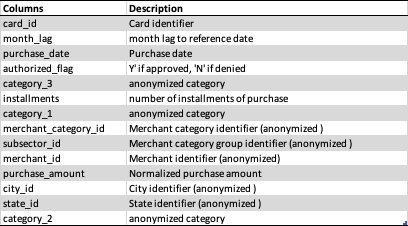mized category

In [68]:
df_history

authorized_flag          card_id  city_id category_1  installments  \
0                      Y  C_ID_4e6213e9bc       88          N             0   
1                      Y  C_ID_4e6213e9bc       88          N             0   
2                      Y  C_ID_4e6213e9bc       88          N             0   
3                      Y  C_ID_4e6213e9bc       88          N             0   
4                      Y  C_ID_4e6213e9bc       88          N             0   
...                  ...              ...      ...        ...           ...   
29112356               Y  C_ID_2863d2fa95       -1          Y             1   
29112357               Y  C_ID_2863d2fa95       -1          Y             1   
29112358               Y  C_ID_5c240d6e3c        3          N             0   
29112359               Y  C_ID_5c240d6e3c      331          N             0   
29112360               Y  C_ID_5c240d6e3c      331          N             0   

         category_3  merchant_category_id      merchant_id  month_lag  \
0                 A                    80  M_ID_e020e9b302         -8   
1                 A                   367  M_ID_86ec983688         -7   
2                 A                    80  M_ID_979ed661fc         -6   
3                 A                   560  M_ID_e6d5ae8ea6         -5   
4                 A                    80  M_ID_e020e9b302        -11   
...             ...                   ...              ...        ...   
29112356          B                   360  M_ID_edd92b6720         -1   
29112357          B                   360  M_ID_edd92b6720          0   
29112358          A                   278  M_ID_9cdcfe8673          0   
29112359          A                   514  M_ID_1a75f94f92         -1   
29112360          A                   514  M_ID_1a75f94f92         -2   

          purchase_amount       purchase_date  category_2  state_id  \
0               -0.703331 2017-06-25 15:33:07         1.0        16   
1               -0.733128 2017-07-15 12:10:45         1.0        16   
2               -0.720386 2017-08-09 22:04:29         1.0        16   
3               -0.735352 2017-09-02 10:06:26         1.0        16   
4               -0.722865 2017-03-10 01:14:19         1.0        16   
...                   ...                 ...         ...       ...   
29112356        -0.632706 2017-01-20 08:52:04         NaN        -1   
29112357        -0.632706 2017-02-20 04:40:50         NaN        -1   
29112358        -0.657740 2017-12-26 18:37:51         1.0        16   
29112359         0.770620 2017-11-24 14:18:15         1.0        16   
29112360         1.134411 2017-10-26 14:09:40         1.0        16   

          subsector_id  
0                   37  
1                   16  
2                   37  
3                   34  
4                   37  
...                ...  
29112356            34  
29112357            34  
29112358            37  
29112359             9  
29112360             9  

[29112361 rows x 14 columns]

In [69]:
df_train = pd.read_csv('train.csv')
df_train

first_active_month          card_id  feature_1  feature_2  feature_3  \
0                 2017-06  C_ID_92a2005557          5          2          1   
1                 2017-01  C_ID_3d0044924f          4          1          0   
2                 2016-08  C_ID_d639edf6cd          2          2          0   
3                 2017-09  C_ID_186d6a6901          4          3          0   
4                 2017-11  C_ID_cdbd2c0db2          1          3          0   
...                   ...              ...        ...        ...        ...   
201912            2017-09  C_ID_963962de2c          3          2          1   
201913            2015-10  C_ID_1314773c0b          3          1          1   
201914            2017-08  C_ID_7666735b3d          4          3          0   
201915            2016-07  C_ID_73f5a0efd0          3          2          1   
201916            2017-07  C_ID_92c9984c58          3          1          1   

          target  
0      -0.820283  
1       0.392913  
2       0.688056  
3       0.142495  
4      -0.159749  
...          ...  
201912 -2.740821  
201913  0.312917  
201914  0.093494  
201915 -4.676589  
201916 -1.859413  

[201917 rows x 6 columns]

In [70]:
df_history["merchantNew"] = 0

In [71]:
df_new_merchants["merchantNew"] = 1

In [72]:
# Merge df_history & df_new_merchants on card_id
# we have analysed below in new_merchants section of notebook that all card_ids are present in df_history
df_hist_new_target = pd.concat([df_history, df_new_merchants], ignore_index=True)
df_hist_new_target

authorized_flag          card_id  city_id category_1  installments  \
0                      Y  C_ID_4e6213e9bc       88          N             0   
1                      Y  C_ID_4e6213e9bc       88          N             0   
2                      Y  C_ID_4e6213e9bc       88          N             0   
3                      Y  C_ID_4e6213e9bc       88          N             0   
4                      Y  C_ID_4e6213e9bc       88          N             0   
...                  ...              ...      ...        ...           ...   
31075387               Y  C_ID_1320dee851      142          N             0   
31075388               Y  C_ID_f112aa3381      158          N             0   
31075389               Y  C_ID_bd97b86450       69          N             1   
31075390               Y  C_ID_c0513fd84f      130          N             0   
31075391               Y  C_ID_a935410f8e       19          N             0   

         category_3  merchant_category_id      merchant_id  month_lag  \
0                 A                    80  M_ID_e020e9b302         -8   
1                 A                   367  M_ID_86ec983688         -7   
2                 A                    80  M_ID_979ed661fc         -6   
3                 A                   560  M_ID_e6d5ae8ea6         -5   
4                 A                    80  M_ID_e020e9b302        -11   
...             ...                   ...              ...        ...   
31075387          A                   309  M_ID_7754b67f3b          2   
31075388          A                   560  M_ID_da063195b7          2   
31075389          B                   278  M_ID_9a9ccb6544          1   
31075390          A                   367  M_ID_40c28d596f          1   
31075391          A                   278  M_ID_d855771cd9          2   

          purchase_amount       purchase_date  category_2  state_id  \
0               -0.703331 2017-06-25 15:33:07         1.0        16   
1               -0.733128 2017-07-15 12:10:45         1.0        16   
2               -0.720386 2017-08-09 22:04:29         1.0        16   
3               -0.735352 2017-09-02 10:06:26         1.0        16   
4               -0.722865 2017-03-10 01:14:19         1.0        16   
...                   ...                 ...         ...       ...   
31075387        -0.701828 2018-04-06 14:36:52         3.0        19   
31075388        -0.694390 2018-03-07 13:19:18         1.0        15   
31075389        -0.621031 2018-03-05 12:04:56         1.0         9   
31075390        -0.656749 2018-03-09 14:47:05         3.0         7   
31075391        -0.739395 2018-04-11 07:59:46         1.0         9   

          subsector_id  merchantNew  
0                   37            0  
1                   16            0  
2                   37            0  
3                   34            0  
4                   37            0  
...                ...          ...  
31075387            21            1  
31075388            34            1  
31075389            37            1  
31075390            16            1  
31075391            37            1  

[31075392 rows x 15 columns]

In [73]:
# Merge df_history & df_train on card_id
df_hist_target = df_hist_new_target.merge(df_train, on="card_id", how="inner")
df_hist_target.head(5)

authorized_flag          card_id  city_id category_1  installments  \
0               N  C_ID_5037ff576e      322          N             1   
1               Y  C_ID_5037ff576e      138          N             1   
2               Y  C_ID_5037ff576e      138          N             1   
3               Y  C_ID_5037ff576e      226          N             1   
4               Y  C_ID_5037ff576e      330          N             1   

  category_3  merchant_category_id      merchant_id  month_lag  \
0          B                   278  M_ID_b61c7d1be0         -3   
1          B                   307  M_ID_fe69229f24         -4   
2          B                   705  M_ID_efc106141c         -9   
3          B                   307  M_ID_708022307c         -4   
4          B                   705  M_ID_393b4b8cec         -9   

   purchase_amount       purchase_date  category_2  state_id  subsector_id  \
0        -0.595260 2017-09-07 20:57:19         3.0        11            37   
1         1.189469 2017-08-14 15:46:08         1.0        15            19   
2        -0.640069 2017-03-05 14:57:51         1.0        15            33   
3        -0.652256 2017-08-15 10:45:28         1.0        16            19   
4        -0.674210 2017-03-26 20:00:31         3.0        17            33   

   merchantNew first_active_month  feature_1  feature_2  feature_3    target  
0            0            2017-01          5          1          1 -2.352713  
1            0            2017-01          5          1          1 -2.352713  
2            0            2017-01          5          1          1 -2.352713  
3            0            2017-01          5          1          1 -2.352713  
4            0            2017-01          5          1          1 -2.352713

In [74]:
df_hist_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19249694 entries, 0 to 19249693
Data columns (total 20 columns):
 #   Column                Dtype         
---  ------                -----         
 0   authorized_flag       object        
 1   card_id               object        
 2   city_id               int64         
 3   category_1            object        
 4   installments          int64         
 5   category_3            object        
 6   merchant_category_id  int64         
 7   merchant_id           object        
 8   month_lag             int64         
 9   purchase_amount       float64       
 10  purchase_date         datetime64[ns]
 11  category_2            float64       
 12  state_id              int64         
 13  subsector_id          int64         
 14  merchantNew           int64         
 15  first_active_month    object        
 16  feature_1             int64         
 17  feature_2             int64         
 18  feature_3             int64         
 19

In [75]:
data_missing = (df_hist_target.isnull().sum()/df_hist_target.shape[0])*100
data_missing.sort_values(ascending=False)

category_2              8.864780
category_3              0.754282
merchant_id             0.531421
authorized_flag         0.000000
category_1              0.000000
city_id                 0.000000
card_id                 0.000000
installments            0.000000
merchant_category_id    0.000000
month_lag               0.000000
purchase_amount         0.000000
purchase_date           0.000000
state_id                0.000000
subsector_id            0.000000
merchantNew             0.000000
first_active_month      0.000000
feature_1               0.000000
feature_2               0.000000
feature_3               0.000000
target                  0.000000
dtype: float64

In [76]:
df_hist_target.shape

(19249694, 20)

In [77]:
df_hist_target[df_hist_target["card_id"]=="C_ID_00007093c1"]["card_id"].count()

151

In [78]:
# Analyze a specific card_id to understand its columns
card_id = "C_ID_5037ff576e"
df_card_id = df_hist_target[df_hist_target["card_id"] == card_id]
df_card_id

authorized_flag          card_id  city_id category_1  installments  \
0                 N  C_ID_5037ff576e      322          N             1   
1                 Y  C_ID_5037ff576e      138          N             1   
2                 Y  C_ID_5037ff576e      138          N             1   
3                 Y  C_ID_5037ff576e      226          N             1   
4                 Y  C_ID_5037ff576e      330          N             1   
..              ...              ...      ...        ...           ...   
115               Y  C_ID_5037ff576e       69          N             1   
116               Y  C_ID_5037ff576e      211          N             1   
117               N  C_ID_5037ff576e       20          N             1   
118               Y  C_ID_5037ff576e       42          N             1   
119               Y  C_ID_5037ff576e       42          N             3   

    category_3  merchant_category_id      merchant_id  month_lag  \
0            B                   278  M_ID_b61c7d1be0         -3   
1            B                   307  M_ID_fe69229f24         -4   
2            B                   705  M_ID_efc106141c         -9   
3            B                   307  M_ID_708022307c         -4   
4            B                   705  M_ID_393b4b8cec         -9   
..         ...                   ...              ...        ...   
115          B                   560  M_ID_06be908566         -1   
116          B                   307  M_ID_d23623b922         -8   
117          B                   307  M_ID_d23623b922         -6   
118          B                   307  M_ID_7c621e17ac          2   
119          C                    45  M_ID_bf4d9973c5          2   

     purchase_amount       purchase_date  category_2  state_id  subsector_id  \
0          -0.595260 2017-09-07 20:57:19         3.0        11            37   
1           1.189469 2017-08-14 15:46:08         1.0        15            19   
2          -0.640069 2017-03-05 14:57:51         1.0        15            33   
3          -0.652256 2017-08-15 10:45:28         1.0        16            19   
4          -0.674210 2017-03-26 20:00:31         3.0        17            33   
..               ...                 ...         ...       ...           ...   
115        -0.601151 2017-11-22 00:09:39         1.0         9            34   
116        -0.694315 2017-04-22 01:37:23         3.0        19            19   
117         0.755743 2017-06-23 18:55:07         3.0        19            19   
118         1.356804 2018-02-04 02:39:22         3.0        19            19   
119         0.335001 2018-02-23 15:17:10         3.0        19            18   

     merchantNew first_active_month  feature_1  feature_2  feature_3    target  
0              0            2017-01          5          1          1 -2.352713  
1              0            2017-01          5          1          1 -2.352713  
2              0            2017-01          5          1          1 -2.352713  
3              0            2017-01          5          1          1 -2.352713  
4              0            2017-01          5          1          1 -2.352713  
..           ...                ...        ...        ...        ...       ...  
115            0            2017-01          5          1          1 -2.352713  
116            0            2017-01          5          1          1 -2.352713  
117            0            2017-01          5          1          1 -2.352713  
118            1            2017-01          5          1          1 -2.352713  
119            1            2017-01          5          1          1 -2.352713  

[120 rows x 20 columns]

In [79]:
# Save the DataFrame to a CSV file
df_card_id.to_csv('card_id.csv', index=False)  # Specify the file name and set index to False to exclude the index column

In [80]:
# are all merchant's unique?
df_card_id["merchant_id"].nunique()
# Ans - No, we have 80 unique merchant ids for this card id

82

In [81]:
# analyse when category 2 is na
filtered_df = df_card_id[df_card_id['category_2'].isna()]
filtered_df
# we see state_id = -1 & city_id = -1 or 331

authorized_flag          card_id  city_id category_1  installments  \
18                Y  C_ID_5037ff576e       -1          N             1   
25                Y  C_ID_5037ff576e       -1          N             1   
30                Y  C_ID_5037ff576e       -1          N             1   
52                Y  C_ID_5037ff576e      331          N             1   
71                Y  C_ID_5037ff576e       -1          N             1   
79                Y  C_ID_5037ff576e       -1          N             1   
87                Y  C_ID_5037ff576e       -1          N             1   
113               Y  C_ID_5037ff576e      331          N             1   

    category_3  merchant_category_id      merchant_id  month_lag  \
18           B                   307  M_ID_d8281a0ff9        -11   
25           B                   307  M_ID_949996e6b5          0   
30           B                   307  M_ID_fe69229f24         -1   
52           B                   307  M_ID_1cf20d1419          0   
71           B                   307  M_ID_9b26897b07         -1   
79           B                   307  M_ID_fe69229f24          0   
87           B                    45  M_ID_6e67395fa3          0   
113          B                    45  M_ID_54944a940b          0   

     purchase_amount       purchase_date  category_2  state_id  subsector_id  \
18         -0.303581 2017-01-07 10:17:04         NaN        -1            19   
25         -0.671775 2017-12-24 19:28:09         NaN        -1            19   
30          0.189755 2017-11-23 00:00:00         NaN        -1            19   
52          0.244541 2017-12-15 14:02:29         NaN        -1            19   
71          0.575425 2017-11-04 00:00:00         NaN        -1            19   
79         -0.671775 2017-12-02 20:21:59         NaN        -1            19   
87         -0.467415 2017-12-17 06:27:56         NaN        -1            18   
113        -0.416325 2017-12-15 15:29:46         NaN        -1            18   

     merchantNew first_active_month  feature_1  feature_2  feature_3    target  
18             0            2017-01          5          1          1 -2.352713  
25             0            2017-01          5          1          1 -2.352713  
30             0            2017-01          5          1          1 -2.352713  
52             0            2017-01          5          1          1 -2.352713  
71             0            2017-01          5          1          1 -2.352713  
79             0            2017-01          5          1          1 -2.352713  
87             0            2017-01          5          1          1 -2.352713  
113            0            2017-01          5          1          1 -2.352713

In [82]:
# check if this is same for whole df
filtered_df_hist = df_hist_target[df_hist_target['category_2'].isna()]
filtered_df_hist["state_id"].unique()

array([-1])

In [83]:
filtered_df_hist["city_id"].unique()

array([ -1, 331, 170,  20,  75, 179, 244, 315, 322])

In [84]:
df_hist_target[df_hist_target["city_id"]==-1]["card_id"].nunique()/df_hist_target["card_id"].nunique()
# 50% txns are with city_id=-1

0.5314163740546859

In [85]:
unique_city_ids = np.unique(df_hist_target["city_id"])
sorted_unique_city_ids = np.sort(unique_city_ids)
print("Unique city IDs:", df_hist_target["city_id"].nunique())
print("Unique city IDs in ascending order:", sorted_unique_city_ids)


Unique city IDs: 308
Unique city IDs in ascending order: [ -1   1   2   3   4   6   7   8   9  10  11  12  13  14  16  17  18  19
  20  21  22  23  24  25  26  28  29  30  32  33  34  35  36  38  39  40
  41  42  44  46  47  48  49  51  52  53  54  56  57  58  60  61  62  63
  64  65  66  68  69  70  71  73  74  75  76  77  78  79  80  81  82  83
  84  85  86  87  88  89  90  91  92  94  96  97  98 100 101 102 103 104
 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 122 123
 124 125 126 128 129 130 131 133 135 136 137 138 139 140 142 143 144 145
 146 147 148 149 150 151 153 155 156 157 158 159 160 161 162 163 165 166
 167 168 169 170 171 172 173 174 175 178 179 180 181 182 183 184 185 186
 187 188 189 190 191 193 194 195 197 198 199 200 201 203 204 205 206 207
 208 209 210 211 212 213 214 215 216 218 219 220 221 222 223 224 226 227
 228 229 230 231 232 233 234 235 236 237 238 239 240 242 244 245 246 247
 248 250 251 252 253 254 255 256 258 259 260 261 262 263 264 265 26

In [86]:
unique_subsector_id = np.unique(df_hist_target["subsector_id"])
sorted_subsector_ids = np.sort(unique_subsector_id)
print("Unique subsector_id:", df_hist_target["subsector_id"].nunique())
print("Unique subsector_id in ascending order:", sorted_subsector_ids)

# we will encode city_id & subsector_id later

Unique subsector_id: 41
Unique subsector_id in ascending order: [-1  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]


In [87]:
df_hist_target.describe()

city_id  installments  merchant_category_id     month_lag  \
count  1.924969e+07  1.924969e+07          1.924969e+07  1.924969e+07   
mean   1.296477e+02  6.501107e-01          4.779664e+02 -4.103993e+00   
min   -1.000000e+00 -1.000000e+00         -1.000000e+00 -1.300000e+01   
25%    5.600000e+01  0.000000e+00          3.020000e+02 -7.000000e+00   
50%    9.000000e+01  0.000000e+00          4.540000e+02 -3.000000e+00   
75%    2.120000e+02  1.000000e+00          7.050000e+02 -1.000000e+00   
max    3.470000e+02  9.990000e+02          8.910000e+02  2.000000e+00   
std    1.039769e+02  2.632253e+00          2.494353e+02  3.763078e+00   

       purchase_amount                  purchase_date    category_2  \
count     1.924969e+07                       19249694  1.754325e+07   
mean      1.163292e-01  2017-09-17 12:48:17.064851456  2.190977e+00   
min      -7.469078e-01            2017-01-01 00:00:08  1.000000e+00   
25%      -7.199352e-01            2017-06-16 19:10:51  1.000000e+00   
50%      -6.875531e-01            2017-10-06 00:00:00  1.000000e+00   
75%      -6.011055e-01  2017-12-23 17:31:37.750000128  3.000000e+00   
max       6.010604e+06            2018-04-30 23:59:59  5.000000e+00   
std       1.377398e+03                            NaN  1.529758e+00   

           state_id  subsector_id   merchantNew     feature_1     feature_2  \
count  1.924969e+07  1.924969e+07  1.924969e+07  1.924969e+07  1.924969e+07   
mean   1.058123e+01  2.679130e+01  6.336127e-02  3.123712e+00  1.742034e+00   
min   -1.000000e+00 -1.000000e+00  0.000000e+00  1.000000e+00  1.000000e+00   
25%    9.000000e+00  1.900000e+01  0.000000e+00  2.000000e+00  1.000000e+00   
50%    9.000000e+00  2.900000e+01  0.000000e+00  3.000000e+00  2.000000e+00   
75%    1.600000e+01  3.400000e+01  0.000000e+00  4.000000e+00  2.000000e+00   
max    2.400000e+01  4.100000e+01  1.000000e+00  5.000000e+00  3.000000e+00   
std    6.337179e+00  9.719764e+00  2.436116e-01  1.265658e+00  7.104748e-01   

          feature_3        target  
count  1.924969e+07  1.924969e+07  
mean   5.518236e-01 -4.555357e-01  
min    0.000000e+00 -3.321928e+01  
25%    0.000000e+00 -8.080842e-01  
50%    1.000000e+00 -9.017618e-02  
75%    1.000000e+00  5.422310e-01  
max    1.000000e+00  1.796507e+01  
std    4.973071e-01  3.581071e+00

In [26]:
df_hist_target.describe(include='dtype')

authorized_flag          card_id category_1 category_3  \
count         19249694         19249694   19249694   19104497   
unique               2           201917          2          3   
top                  Y  C_ID_0cd2ce025c          N          A   
freq          17687830             2915   17922482   10125067   

            merchant_id first_active_month  
count          19147397           19249694  
unique           313541                 75  
top     M_ID_00a6ca8a8a            2017-01  
freq             704948            1212932

#### It may be that these 8 city_ids are 8 union territories and the one with -1 is we donot know txn done from where (lost)
#### since city_id is granular, we can do encoding on it later

### DATA CLEANING

In [88]:
# when category 2 is na, fill na with 0
print("Unique category 2 values:", df_hist_target["category_2"].unique())
df_hist_target['category_2'].fillna(0, inplace=True)
print("Unique category 2 values after replacing NA:", df_hist_target["category_2"].unique())

Unique category 2 values: [ 3.  1.  5.  2. nan  4.]
Unique category 2 values after replacing NA: [3. 1. 5. 2. 0. 4.]


In [89]:
# let's make categorical column to numeric & handle null values
# for category_2
mapping = {'Y': 1, 'N': -1}
# Use the map function to replace values in 'column_a'
df_hist_target['category_1'] = df_hist_target['category_1'].map(mapping)
df_hist_target['category_1'].fillna(0, inplace=True)
print("Unique category_1 values after replacing NA:", df_hist_target["category_1"].unique())

Unique category_1 values after replacing NA: [-1  1]


In [90]:
# let's make categorical column to numeric & handle null values
# when category 3 is na, fill na with 0
print("Unique category 3 values:", df_hist_target["category_3"].unique())

mapping = {'A': 3, 'B': 2, 'C':1}
# Use the map function to replace values in 'column_a'
df_hist_target['category_3'] = df_hist_target['category_3'].map(mapping)
df_hist_target['category_3'].fillna(0, inplace=True)

print("Unique category_3 values after replacing NA:", df_hist_target["category_3"].unique())

Unique category 3 values: ['B' 'C' 'A' nan]
Unique category_3 values after replacing NA: [2. 1. 3. 0.]


In [91]:
data_missing = (df_hist_target.isnull().sum()/df_hist_target.shape[0])*100
data_missing.sort_values(ascending=False)

merchant_id             0.531421
authorized_flag         0.000000
city_id                 0.000000
card_id                 0.000000
category_1              0.000000
installments            0.000000
category_3              0.000000
merchant_category_id    0.000000
month_lag               0.000000
purchase_amount         0.000000
purchase_date           0.000000
category_2              0.000000
state_id                0.000000
subsector_id            0.000000
merchantNew             0.000000
first_active_month      0.000000
feature_1               0.000000
feature_2               0.000000
feature_3               0.000000
target                  0.000000
dtype: float64

In [92]:
# lets keep 0.5% merchant ids NAN for now.. as we will be analysing card_ids first

#### We have historical data maximum ranging from Jan 2017 to Feb 2018. Some card_ids maynot have data of earlier months. New merchants has data for next months until latest histrical month

In [93]:
# for 1 card_id how many unique values are there for each column
for i in df_card_id.columns:
    print(i, df_card_id[i].nunique())

authorized_flag 2
card_id 1
city_id 33
category_1 1
installments 3
category_3 2
merchant_category_id 21
merchant_id 82
month_lag 13
purchase_amount 105
purchase_date 119
category_2 5
state_id 16
subsector_id 14
merchantNew 2
first_active_month 1
feature_1 1
feature_2 1
feature_3 1
target 1


In [94]:
df_card_id.describe()

city_id  installments  merchant_category_id   month_lag  \
count  120.000000    120.000000             120.00000  120.000000   
mean   174.966667      1.066667             380.95000   -5.750000   
min     -1.000000      1.000000              45.00000  -11.000000   
25%     67.500000      1.000000             278.00000   -9.000000   
50%    161.000000      1.000000             307.00000   -5.000000   
75%    329.250000      1.000000             511.00000   -3.000000   
max    344.000000      5.000000             879.00000    2.000000   
std    125.328136      0.444071             211.02805    3.541471   

       purchase_amount                  purchase_date  category_2    state_id  \
count       120.000000                            120  112.000000  120.000000   
mean         -0.347945  2017-06-22 00:15:16.050000128    1.910714   11.908333   
min          -0.716434            2017-01-06 13:36:12    1.000000   -1.000000   
25%          -0.675028            2017-03-04 16:47:42    1.000000    9.000000   
50%          -0.634074     2017-07-04 04:35:59.500000    1.000000   11.000000   
75%          -0.369186            2017-09-10 17:41:10    3.000000   16.000000   
max           1.567175            2018-02-23 15:17:10    5.000000   24.000000   
std           0.590916                            NaN    1.086805    6.041865   

       subsector_id  merchantNew  feature_1  feature_2  feature_3  \
count    120.000000   120.000000      120.0      120.0      120.0   
mean      25.675000     0.016667        5.0        1.0        1.0   
min        1.000000     0.000000        5.0        1.0        1.0   
25%       19.000000     0.000000        5.0        1.0        1.0   
50%       19.000000     0.000000        5.0        1.0        1.0   
75%       34.000000     0.000000        5.0        1.0        1.0   
max       37.000000     1.000000        5.0        1.0        1.0   
std        9.449701     0.128556        0.0        0.0        0.0   

             target  
count  1.200000e+02  
mean  -2.352713e+00  
min   -2.352713e+00  
25%   -2.352713e+00  
50%   -2.352713e+00  
75%   -2.352713e+00  
max   -2.352713e+00  
std    4.459512e-16

In [95]:
# Analyze a specific merchant_id to understand its columns
m_id = "M_ID_b61c7d1be0"
df_m_id = df_hist_target[df_hist_target["merchant_id"] == m_id]
df_m_id

authorized_flag          card_id  city_id  category_1  installments  \
0                      N  C_ID_5037ff576e      322          -1             1   
19                     Y  C_ID_5037ff576e      322          -1             1   
39                     Y  C_ID_5037ff576e      322          -1             1   
39086                  Y  C_ID_ae1363307b      322          -1             0   
39427                  Y  C_ID_ae1363307b      322          -1             0   
...                  ...              ...      ...         ...           ...   
17743474               Y  C_ID_b59856821a      322          -1             1   
18284605               N  C_ID_f5c033274b      322          -1             0   
18716323               Y  C_ID_952180c575      322          -1             0   
18778289               Y  C_ID_d09df57ba5      322          -1             1   
18943995               Y  C_ID_1463db596c      322          -1             0   

          category_3  merchant_category_id      merchant_id  month_lag  \
0                2.0                   278  M_ID_b61c7d1be0         -3   
19               2.0                   278  M_ID_b61c7d1be0         -3   
39               2.0                   278  M_ID_b61c7d1be0         -3   
39086            3.0                   278  M_ID_b61c7d1be0         -4   
39427            3.0                   278  M_ID_b61c7d1be0         -2   
...              ...                   ...              ...        ...   
17743474         2.0                   278  M_ID_b61c7d1be0         -5   
18284605         3.0                   278  M_ID_b61c7d1be0         -4   
18716323         3.0                   278  M_ID_b61c7d1be0          1   
18778289         2.0                   278  M_ID_b61c7d1be0         -5   
18943995         3.0                   278  M_ID_b61c7d1be0         -1   

          purchase_amount       purchase_date  category_2  state_id  \
0               -0.595260 2017-09-07 20:57:19         3.0        11   
19              -0.595260 2017-09-07 20:57:32         3.0        11   
39              -0.595290 2017-09-07 20:58:31         3.0        11   
39086           -0.560128 2017-10-11 16:45:09         3.0        11   
39427           -0.585162 2017-12-08 19:50:04         3.0        11   
...                   ...                 ...         ...       ...   
17743474        -0.683015 2017-09-27 00:21:35         3.0        11   
18284605        -0.723617 2017-10-18 20:47:14         3.0        11   
18716323        -0.723617 2018-03-30 19:06:35         3.0        11   
18778289        -0.702955 2017-09-19 21:01:40         3.0        11   
18943995        -0.726622 2018-01-27 16:12:51         3.0        11   

          subsector_id  merchantNew first_active_month  feature_1  feature_2  \
0                   37            0            2017-01          5          1   
19                  37            0            2017-01          5          1   
39                  37            0            2017-01          5          1   
39086               37            0            2016-10          5          2   
39427               37            0            2016-10          5          2   
...                ...          ...                ...        ...        ...   
17743474            37            0            2017-08          2          1   
18284605            37            0            2017-07          3          2   
18716323            37            1            2016-11          3          1   
18778289            37            0            2017-08          4          3   
18943995            37            0            2017-12          3          1   

          feature_3    target  
0                 1 -2.352713  
19                1 -2.352713  
39                1 -2.352713  
39086             1 -0.225299  
39427             1 -0.225299  
...             ...       ...  
17743474          0 -0.062447  
18284605          1  1.386031  
18716323          1 -0.089563  
18778289          0  0.61

In [96]:
df_m_id.shape

(63, 20)

In [97]:
for i in df_m_id.columns:
    print(i, df_m_id[i].nunique())

authorized_flag 2
card_id 36
city_id 1
category_1 1
installments 2
category_3 2
merchant_category_id 1
merchant_id 1
month_lag 15
purchase_amount 49
purchase_date 63
category_2 1
state_id 1
subsector_id 1
merchantNew 2
first_active_month 19
feature_1 5
feature_2 3
feature_3 2
target 36


In [98]:
# The DATA is present for 2017 year complete in historical_txn df
# authorised flag is related to card or merchant??
# for each card_id many merchant_id are there & vice versa
# category 1 has "N" values only? for both card_id & merchant_id- it came 1 value
# installments there on card purchase, generally people pay in 1 installment except few who take EMI
# month lag for each date wrt reference date (end of 2017)
# i think person/card should be more loyal if unique purchase_date are more in year

In [99]:
df_card_id.head(1)

authorized_flag          card_id  city_id category_1  installments  \
0               N  C_ID_5037ff576e      322          N             1   

  category_3  merchant_category_id      merchant_id  month_lag  \
0          B                   278  M_ID_b61c7d1be0         -3   

   purchase_amount       purchase_date  category_2  state_id  subsector_id  \
0         -0.59526 2017-09-07 20:57:19         3.0        11            37   

   merchantNew first_active_month  feature_1  feature_2  feature_3    target  
0            0            2017-01          5          1          1 -2.352713

In [100]:
df_card_id.dtypes

authorized_flag                 object
card_id                         object
city_id                          int64
category_1                      object
installments                     int64
category_3                      object
merchant_category_id             int64
merchant_id                     object
month_lag                        int64
purchase_amount                float64
purchase_date           datetime64[ns]
category_2                     float64
state_id                         int64
subsector_id                     int64
merchantNew                      int64
first_active_month              object
feature_1                        int64
feature_2                        int64
feature_3                        int64
target                         float64
dtype: object

In [101]:
# Group the DataFrame by "target_score" and count unique dates
date_counts = df_hist_target.groupby('target')['purchase_date'].nunique()

In [122]:
target_count_df = pd.DataFrame(date_counts).reset_index()
target_count_df_0 = target_count_df[target_count_df["target"]>=0]
target_count_df_0

target  purchase_date
100011   0.000000          50268
100012   0.000014            637
100013   0.000022             35
100014   0.000048            169
100015   0.000053             35
...           ...            ...
197105  15.294621             64
197106  15.606405             90
197107  15.994455            137
197108  17.675716            142
197109  17.965068              8

[97099 rows x 2 columns]

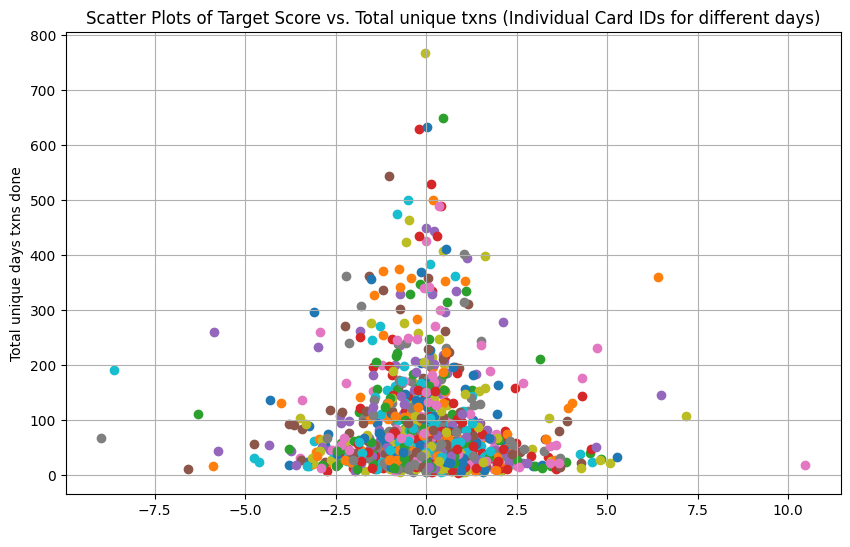

In [45]:
# Group by "card_id"
grouped = df_hist_target.groupby('card_id')

plt.figure(figsize=(10, 6))

j=0
for card_id, group in grouped:
    if j>1000:
        break
    j+=1
    date_counts = group.groupby('target')['purchase_date'].nunique()
    if(date_counts.index>-10 and date_counts.values<800): 
        plt.scatter(date_counts.index, date_counts.values)


plt.xlabel('Target Score')
plt.ylabel('Total unique days txns done')
plt.title('Scatter Plots of Target Score vs. Total unique txns (Individual Card IDs for different days)')
plt.grid(True)
# plt.legend()

plt.show()

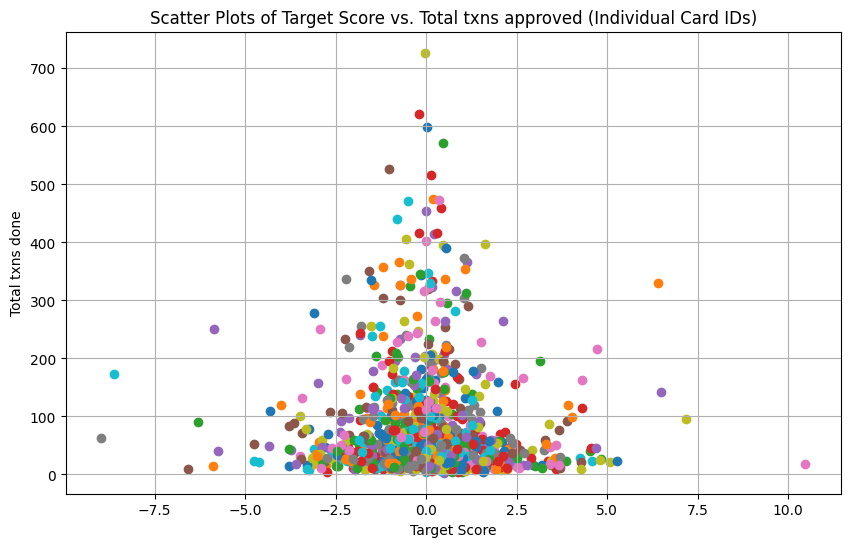

In [46]:
# Group by "card_id"
df = df_hist_target[df_hist_target["authorized_flag"]=="Y"]
grouped = df.groupby('card_id')
plt.figure(figsize=(10, 6))

j=0
for card_id, group in grouped:
    if j>1000:
        break
    j+=1
    date_counts = group.groupby('target')['purchase_date'].count()
    if(date_counts.index>-10 and date_counts.values<800): 
        plt.scatter(date_counts.index, date_counts.values)


plt.xlabel('Target Score')
plt.ylabel('Total txns done')
plt.title('Scatter Plots of Target Score vs. Total txns approved (Individual Card IDs)')
plt.grid(True)
# plt.legend()

plt.show()

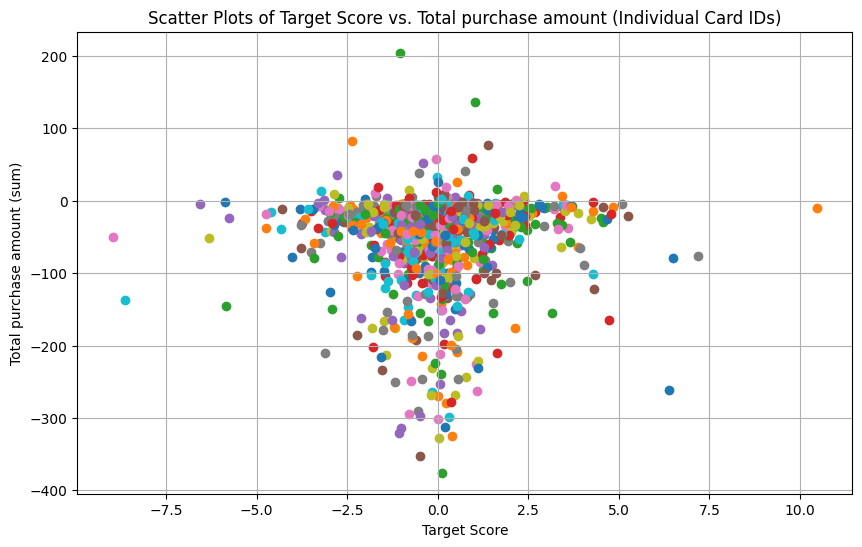

In [47]:
# Group by "card_id"
grouped = df_hist_target.groupby('card_id')

plt.figure(figsize=(10, 6))

j=0
for card_id, group in grouped:
    if j>1000:
        break
    j+=1
    date_counts = group.groupby('target')['purchase_amount'].sum()
    if(date_counts.index>-10 and date_counts.values<400 and date_counts.values>-400): #(2 outliers came in 1000 data points)
        plt.scatter(date_counts.index, date_counts.values)


plt.xlabel('Target Score')
plt.ylabel('Total purchase amount (sum)')
plt.title('Scatter Plots of Target Score vs. Total purchase amount (Individual Card IDs)')
plt.grid(True)
# plt.legend()

plt.show()

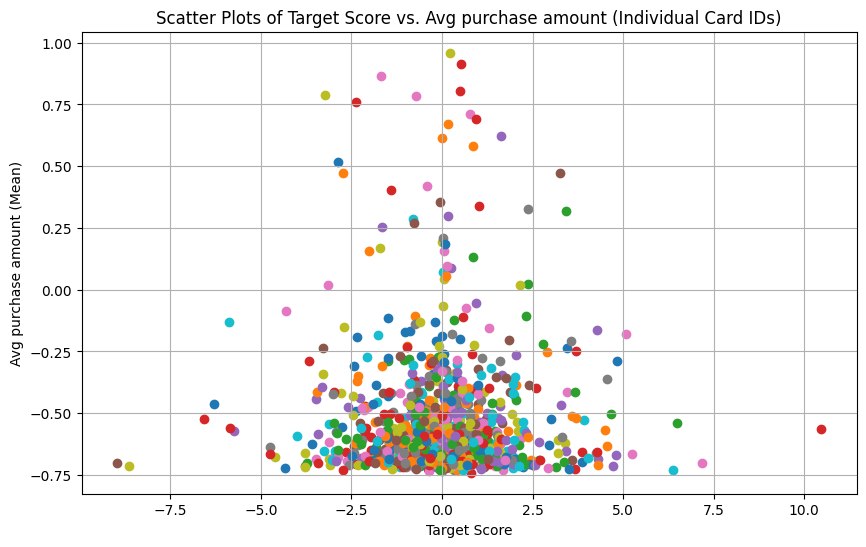

In [48]:
# Group by "card_id"
grouped = df_hist_target.groupby('card_id')

plt.figure(figsize=(10, 6))

j=0
for card_id, group in grouped:
    if j>1000:
        break
    j+=1
    date_counts = group.groupby('target')['purchase_amount'].mean()
    if(date_counts.index>-10 and date_counts.values<1): #(2 outliers came in 1000 data points)
        plt.scatter(date_counts.index, date_counts.values)


plt.xlabel('Target Score')
plt.ylabel('Avg purchase amount (Mean)')
plt.title('Scatter Plots of Target Score vs. Avg purchase amount (Individual Card IDs)')
plt.grid(True)
# plt.legend()

plt.show()

In [49]:
df_card_id["installments"].value_counts()

installments
1    117
3      2
5      1
Name: count, dtype: int64

In [50]:
df_card_id[df_card_id["installments"] == 5]

authorized_flag          card_id  city_id category_1  installments  \
93               N  C_ID_5037ff576e       69          N             5   

   category_3  merchant_category_id      merchant_id  month_lag  \
93          C                   511  M_ID_00a6ca8a8a        -11   

    purchase_amount       purchase_date  category_2  state_id  subsector_id  \
93         1.421418 2017-01-11 16:21:12         1.0         9             7   

    merchantNew first_active_month  feature_1  feature_2  feature_3    target  
93            0            2017-01          5          1          1 -2.352713

<Axes: xlabel='target', ylabel='Count'>

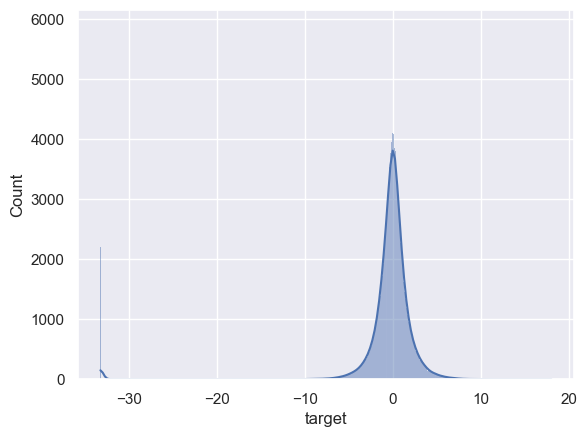

In [51]:
sns.set()
sns.histplot(df_train['target'], kde=True)

In [52]:
# lets try to see for cards that are denied always, maybe target is -30 for them? => rejected
df_denied_hist = df_hist_target[df_hist_target["authorized_flag"]=="N"]
df_denied_hist.shape

(1561864, 20)

<Axes: xlabel='target', ylabel='Count'>

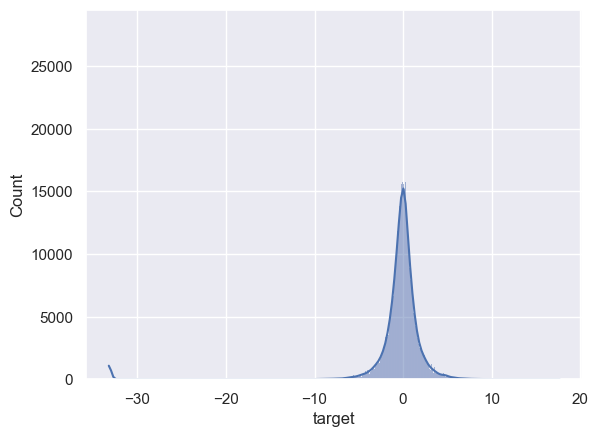

In [53]:
sns.histplot(df_denied_hist['target'], kde=True)

In [129]:
# card_id that is always rejected & maybe blacklisted?
# first lets make authorised flag = 1 if approved else 0, so that if count after grouping & aggregating is 1, we can use those card_ids
# REJECTED, for any success rate of txns approved has no impact on target

df_hist_target['authorized_flag_no'] = df_hist_target['authorized_flag'].replace({'Y': 1, 'N': 0})
df_hist_target.head(1)


authorized_flag          card_id  city_id  category_1  installments  \
0               N  C_ID_5037ff576e      322          -1             1   

   category_3  merchant_category_id      merchant_id  month_lag  \
0         2.0                   278  M_ID_b61c7d1be0         -3   

   purchase_amount       purchase_date  category_2  state_id  subsector_id  \
0         -0.59526 2017-09-07 20:57:19         3.0        11            37   

   merchantNew first_active_month  feature_1  feature_2  feature_3    target  \
0            0            2017-01          5          1          1 -2.352713   

   authorized_flag_no  
0                   0

In [55]:
df_grp_auth = df_hist_target.groupby("card_id")["authorized_flag_no"].mean()
# df_grp_auth.values.min()
df_always_denied_hist = df_grp_auth[df_grp_auth.values<0.1]
df_always_denied_hist.shape

(11,)

<Axes: xlabel='authorized_flag_no', ylabel='Count'>

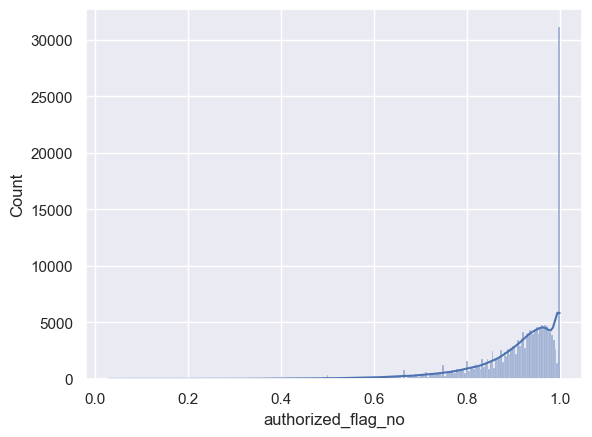

In [56]:
# average approved txns histogram of particular card_id
sns.histplot(df_grp_auth, kde=True)

In [57]:
# plot card_ids with less than 0.5 success to target
df_always_denied_hist = df_grp_auth[df_grp_auth.values<0.1]
df_always_denied_hist

card_id
C_ID_18cb630a80    0.079787
C_ID_2cb58dfc19    0.096491
C_ID_3e01e61aca    0.077348
C_ID_6b0a61c92f    0.067073
C_ID_6ce1a11dbc    0.096154
C_ID_744d26ea32    0.030488
C_ID_74fa19fdc5    0.074468
C_ID_7a796c720b    0.088889
C_ID_9df7a3ff5d    0.086486
C_ID_bb8dd137c9    0.054545
C_ID_e75e342f15    0.099650
Name: authorized_flag_no, dtype: float64

In [58]:
df_always_denied_hist = df_always_denied_hist.to_frame()
df_always_denied_hist = df_always_denied_hist.merge(df_train, on="card_id", how="inner")
df_always_denied_hist

card_id  authorized_flag_no first_active_month  feature_1  \
0   C_ID_18cb630a80            0.079787            2016-11          5   
1   C_ID_2cb58dfc19            0.096491            2016-07          4   
2   C_ID_3e01e61aca            0.077348            2014-10          3   
3   C_ID_6b0a61c92f            0.067073            2016-09          2   
4   C_ID_6ce1a11dbc            0.096154            2013-11          3   
5   C_ID_744d26ea32            0.030488            2016-03          5   
6   C_ID_74fa19fdc5            0.074468            2015-12          2   
7   C_ID_7a796c720b            0.088889            2017-11          2   
8   C_ID_9df7a3ff5d            0.086486            2017-09          2   
9   C_ID_bb8dd137c9            0.054545            2016-07          3   
10  C_ID_e75e342f15            0.099650            2017-04          2   

    feature_2  feature_3     target  
0           2          1   1.281568  
1           2          0   1.194803  
2           3          1   0.000000  
3           1          0 -33.219281  
4           2          1  -1.044135  
5           1          1   2.216685  
6           2          0  -0.118473  
7           1          0   0.401495  
8           1          0   1.083606  
9           2          1  -1.695134  
10          1          0   0.474653

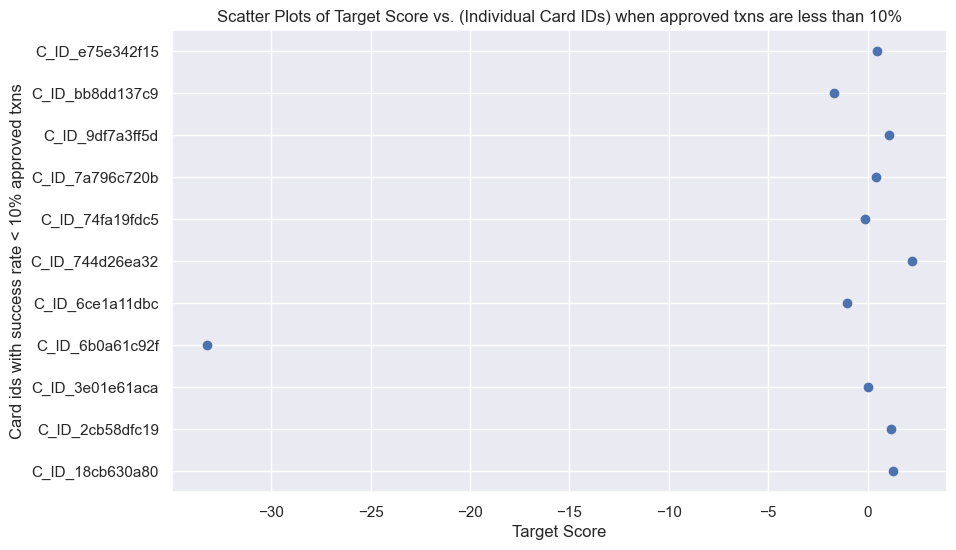

In [59]:
# Group by "card_id"
plt.figure(figsize=(10, 6))

plt.scatter(df_always_denied_hist["target"], df_always_denied_hist["card_id"])

plt.xlabel('Target Score')
plt.ylabel('Card ids with success rate < 10% approved txns')
plt.title('Scatter Plots of Target Score vs. (Individual Card IDs) when approved txns are less than 10%')
plt.grid(True)
# plt.legend()

plt.show()

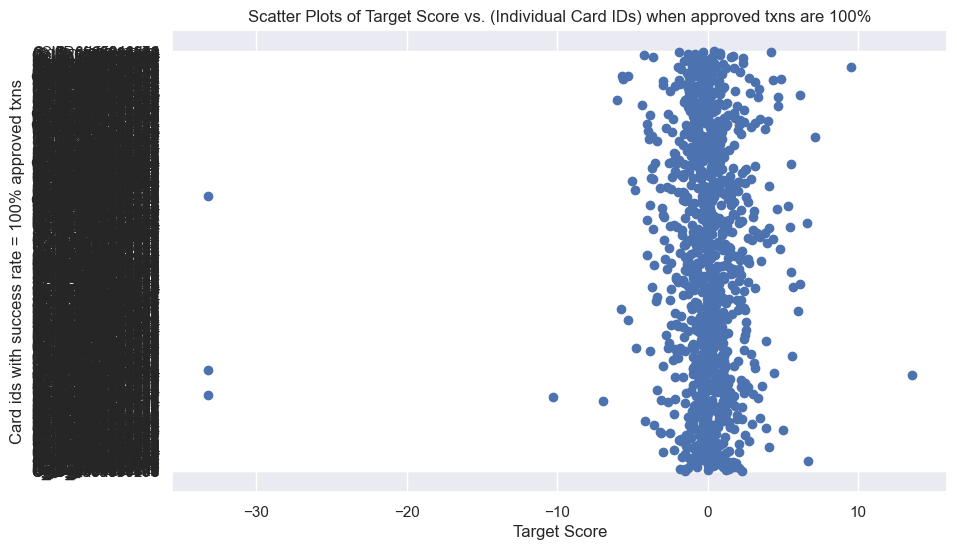

In [60]:
# plot card_ids with 100% success to target
df_always_approved_hist = df_grp_auth[df_grp_auth.values==1]
df_always_approved_hist = df_always_approved_hist.to_frame()
df_always_approved_hist = df_always_approved_hist.merge(df_train, on="card_id", how="inner")

plt.figure(figsize=(10, 6))

# Randomly sample 1000 rows
sampled_df = df_always_approved_hist.sample(n=1000, random_state=42) 
plt.scatter(sampled_df["target"], sampled_df["card_id"])

plt.xlabel('Target Score')
plt.ylabel('Card ids with success rate = 100% approved txns')
plt.title('Scatter Plots of Target Score vs. (Individual Card IDs) when approved txns are 100%')
plt.grid(True)
# plt.legend()

plt.show()

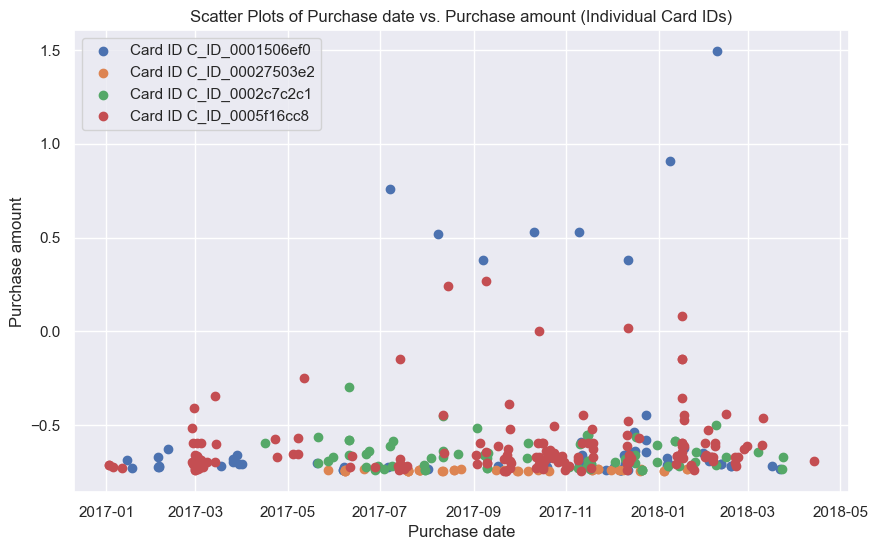

In [61]:
# plot card_ids with purchase amounts for target>0.8

df_target_more_pt8 = df_hist_target[(df_hist_target["target"] > 0.8) & (df_hist_target["target"] < 1.5)]

plt.figure(figsize=(10, 6))

# Group data by card_id and iterate through groups
grouped = df_target_more_pt8.groupby("card_id")
j=0
for card_id, card_data in grouped:
    if j>3:
        break
    j+=1
    plt.scatter(card_data["purchase_date"], card_data["purchase_amount"], label=f'Card ID {card_id}')


plt.xlabel('Purchase date')
plt.ylabel('Purchase amount')
plt.title('Scatter Plots of Purchase date vs. Purchase amount (Individual Card IDs)')
plt.grid(True)
plt.legend()

plt.show()

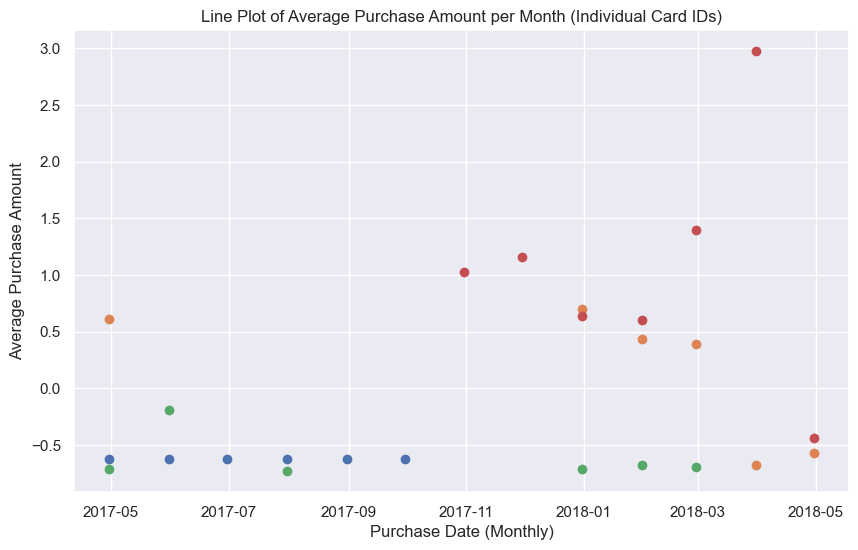

In [62]:
# Select card_ids with target > 0.8 and < 1.5
df_hist_target['purchase_date'] = pd.to_datetime(df_hist_target['purchase_date'])
df_target_more_pt8 = df_hist_target[(df_hist_target["target"] > 0.9) & (df_hist_target["target"] < 1)]

plt.figure(figsize=(10, 6))

# Group data by card_id and resample monthly, calculating the mean of "purchase_amount"
grouped = df_target_more_pt8.groupby("card_id")
j=0
for card_id, card_data in grouped:
    if j>3:
        break
    j+=1
    monthly_avg = card_data.resample('M', on='purchase_date')['purchase_amount'].mean()
    plt.scatter(monthly_avg.index, monthly_avg.values, label=f'Card ID {card_id}')

plt.xlabel('Purchase Date (Monthly)')
plt.ylabel('Average Purchase Amount')
plt.title('Line Plot of Average Purchase Amount per Month (Individual Card IDs)')
plt.grid(True)
# plt.legend()

plt.show()


In [63]:
df_hist_target.columns

Index(['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments',
       'category_3', 'merchant_category_id', 'merchant_id', 'month_lag',
       'purchase_amount', 'purchase_date', 'category_2', 'state_id',
       'subsector_id', 'merchantNew', 'first_active_month', 'feature_1',
       'feature_2', 'feature_3', 'target', 'authorized_flag_no'],
      dtype='object')

In [64]:
df_hist_target.describe()

city_id    category_1  installments    category_3  \
count  1.924969e+07  1.924969e+07  1.924969e+07  1.924969e+07   
mean   1.296477e+02 -8.621057e-01  6.501107e-01  2.446634e+00   
min   -1.000000e+00 -1.000000e+00 -1.000000e+00  0.000000e+00   
25%    5.600000e+01 -1.000000e+00  0.000000e+00  2.000000e+00   
50%    9.000000e+01 -1.000000e+00  0.000000e+00  3.000000e+00   
75%    2.120000e+02 -1.000000e+00  1.000000e+00  3.000000e+00   
max    3.470000e+02  1.000000e+00  9.990000e+02  3.000000e+00   
std    1.039769e+02  5.067286e-01  2.632253e+00  6.488006e-01   

       merchant_category_id     month_lag  purchase_amount  \
count          1.924969e+07  1.924969e+07     1.924969e+07   
mean           4.779664e+02 -4.103993e+00     1.163292e-01   
min           -1.000000e+00 -1.300000e+01    -7.469078e-01   
25%            3.020000e+02 -7.000000e+00    -7.199352e-01   
50%            4.540000e+02 -3.000000e+00    -6.875531e-01   
75%            7.050000e+02 -1.000000e+00    -6.011055e-01   
max            8.910000e+02  2.000000e+00     6.010604e+06   
std            2.494353e+02  3.763078e+00     1.377398e+03   

                       purchase_date    category_2      state_id  \
count                       19249694  1.924969e+07  1.924969e+07   
mean   2017-09-17 12:48:17.064851456  1.996752e+00  1.058123e+01   
min              2017-01-01 00:00:08  0.000000e+00 -1.000000e+00   
25%              2017-06-16 19:10:51  1.000000e+00  9.000000e+00   
50%              2017-10-06 00:00:00  1.000000e+00  9.000000e+00   
75%    2017-12-23 17:31:37.750000128  3.000000e+00  1.600000e+01   
max              2018-04-30 23:59:59  5.000000e+00  2.400000e+01   
std                              NaN  1.587617e+00  6.337179e+00   

       subsector_id   merchantNew     feature_1     feature_2     feature_3  \
count  1.924969e+07  1.924969e+07  1.924969e+07  1.924969e+07  1.924969e+07   
mean   2.679130e+01  6.336127e-02  3.123712e+00  1.742034e+00  5.518236e-01   
min   -1.000000e+00  0.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00   
25%    1.900000e+01  0.000000e+00  2.000000e+00  1.000000e+00  0.000000e+00   
50%    2.900000e+01  0.000000e+00  3.000000e+00  2.000000e+00  1.000000e+00   
75%    3.400000e+01  0.000000e+00  4.000000e+00  2.000000e+00  1.000000e+00   
max    4.100000e+01  1.000000e+00  5.000000e+00  3.000000e+00  1.000000e+00   
std    9.719764e+00  2.436116e-01  1.265658e+00  7.104748e-01  4.973071e-01   

             target  authorized_flag_no  
count  1.924969e+07        1.924969e+07  
mean  -4.555357e-01        9.188629e-01  
min   -3.321928e+01        0.000000e+00  
25%   -8.080842e-01        1.000000e+00  
50%   -9.017618e-02        1.000000e+00  
75%    5.422310e-01        1.000000e+00  
max    1.796507e+01        1.000000e+00  
std    3.581071e+00        2.730455e-01

In [65]:
df_hist_target.describe(include="object")

authorized_flag          card_id      merchant_id first_active_month
count         19249694         19249694         19147397           19249694
unique               2           201917           313541                 75
top                  Y  C_ID_0cd2ce025c  M_ID_00a6ca8a8a            2017-01
freq          17687830             2915           704948            1212932

In [66]:
df_hist_target["category_1"].unique()

array([-1,  1])

In [67]:
df_hist_target["category_3"].unique()

array([2., 1., 3., 0.])

In [68]:
df_hist_target.describe()

city_id    category_1  installments    category_3  \
count  1.924969e+07  1.924969e+07  1.924969e+07  1.924969e+07   
mean   1.296477e+02 -8.621057e-01  6.501107e-01  2.446634e+00   
min   -1.000000e+00 -1.000000e+00 -1.000000e+00  0.000000e+00   
25%    5.600000e+01 -1.000000e+00  0.000000e+00  2.000000e+00   
50%    9.000000e+01 -1.000000e+00  0.000000e+00  3.000000e+00   
75%    2.120000e+02 -1.000000e+00  1.000000e+00  3.000000e+00   
max    3.470000e+02  1.000000e+00  9.990000e+02  3.000000e+00   
std    1.039769e+02  5.067286e-01  2.632253e+00  6.488006e-01   

       merchant_category_id     month_lag  purchase_amount  \
count          1.924969e+07  1.924969e+07     1.924969e+07   
mean           4.779664e+02 -4.103993e+00     1.163292e-01   
min           -1.000000e+00 -1.300000e+01    -7.469078e-01   
25%            3.020000e+02 -7.000000e+00    -7.199352e-01   
50%            4.540000e+02 -3.000000e+00    -6.875531e-01   
75%            7.050000e+02 -1.000000e+00    -6.011055e-01   
max            8.910000e+02  2.000000e+00     6.010604e+06   
std            2.494353e+02  3.763078e+00     1.377398e+03   

                       purchase_date    category_2      state_id  \
count                       19249694  1.924969e+07  1.924969e+07   
mean   2017-09-17 12:48:17.064851456  1.996752e+00  1.058123e+01   
min              2017-01-01 00:00:08  0.000000e+00 -1.000000e+00   
25%              2017-06-16 19:10:51  1.000000e+00  9.000000e+00   
50%              2017-10-06 00:00:00  1.000000e+00  9.000000e+00   
75%    2017-12-23 17:31:37.750000128  3.000000e+00  1.600000e+01   
max              2018-04-30 23:59:59  5.000000e+00  2.400000e+01   
std                              NaN  1.587617e+00  6.337179e+00   

       subsector_id   merchantNew     feature_1     feature_2     feature_3  \
count  1.924969e+07  1.924969e+07  1.924969e+07  1.924969e+07  1.924969e+07   
mean   2.679130e+01  6.336127e-02  3.123712e+00  1.742034e+00  5.518236e-01   
min   -1.000000e+00  0.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00   
25%    1.900000e+01  0.000000e+00  2.000000e+00  1.000000e+00  0.000000e+00   
50%    2.900000e+01  0.000000e+00  3.000000e+00  2.000000e+00  1.000000e+00   
75%    3.400000e+01  0.000000e+00  4.000000e+00  2.000000e+00  1.000000e+00   
max    4.100000e+01  1.000000e+00  5.000000e+00  3.000000e+00  1.000000e+00   
std    9.719764e+00  2.436116e-01  1.265658e+00  7.104748e-01  4.973071e-01   

             target  authorized_flag_no  
count  1.924969e+07        1.924969e+07  
mean  -4.555357e-01        9.188629e-01  
min   -3.321928e+01        0.000000e+00  
25%   -8.080842e-01        1.000000e+00  
50%   -9.017618e-02        1.000000e+00  
75%    5.422310e-01        1.000000e+00  
max    1.796507e+01        1.000000e+00  
std    3.581071e+00        2.730455e-01

In [69]:
df_hist_target["city_id"].nunique()

308

In [70]:
df_hist_target.head(1)

authorized_flag          card_id  city_id  category_1  installments  \
0               N  C_ID_5037ff576e      322          -1             1   

   category_3  merchant_category_id      merchant_id  month_lag  \
0         2.0                   278  M_ID_b61c7d1be0         -3   

   purchase_amount       purchase_date  category_2  state_id  subsector_id  \
0         -0.59526 2017-09-07 20:57:19         3.0        11            37   

   merchantNew first_active_month  feature_1  feature_2  feature_3    target  \
0            0            2017-01          5          1          1 -2.352713   

   authorized_flag_no  
0                   0

In [127]:
# to find earliest txn & latest txn month relative
df_history_mth_lags_1= df_hist_target.groupby('card_id').agg({'month_lag':['min', 'max'] }).reset_index()
df_history_mth_lags_1.columns = [' '.join(col).strip() for col in df_history_mth_lags_1.columns.values]

# the older the more weightage
# df_history_mth_lags = df_history_mth_lags_1.copy()
# df_history_mth_lags["month_lag min"] = -df_history_mth_lags["month_lag min"]

df_history_mth_lags = df_history_mth_lags_1.rename(columns={'month_lag min': 'earliest_txn_rel_mth', 
                                                          'month_lag max': 'latest_txn_rel_mth'})
df_history_mth_lags

card_id  earliest_txn_rel_mth  latest_txn_rel_mth
0       C_ID_00007093c1                   -12                   2
1       C_ID_0001506ef0                   -13                   1
2       C_ID_000183fdda                    -6                   2
3       C_ID_00027503e2                    -8                   0
4       C_ID_0002c7c2c1                    -9                   2
...                 ...                   ...                 ...
201912  C_ID_fffeced303                   -10                   2
201913  C_ID_fffeed3a89                    -3                   2
201914  C_ID_ffff579d3a                    -6                   1
201915  C_ID_ffff828181                   -13                   2
201916  C_ID_fffffd5772                    -6                   1

[201917 rows x 3 columns]

In [151]:
df_hist_target

authorized_flag          card_id  city_id  category_1  installments  \
0                      N  C_ID_5037ff576e      322          -1             1   
1                      Y  C_ID_5037ff576e      138          -1             1   
2                      Y  C_ID_5037ff576e      138          -1             1   
3                      Y  C_ID_5037ff576e      226          -1             1   
4                      Y  C_ID_5037ff576e      330          -1             1   
...                  ...              ...      ...         ...           ...   
19249689               Y  C_ID_5c240d6e3c        3          -1             0   
19249690               Y  C_ID_5c240d6e3c        3          -1             0   
19249691               Y  C_ID_5c240d6e3c      331          -1             0   
19249692               Y  C_ID_5c240d6e3c      331          -1             0   
19249693               Y  C_ID_5c240d6e3c       88          -1             0   

          category_3  merchant_category_id      merchant_id  month_lag  \
0                2.0                   278  M_ID_b61c7d1be0         -3   
1                2.0                   307  M_ID_fe69229f24         -4   
2                2.0                   705  M_ID_efc106141c         -9   
3                2.0                   307  M_ID_708022307c         -4   
4                2.0                   705  M_ID_393b4b8cec         -9   
...              ...                   ...              ...        ...   
19249689         3.0                   504  M_ID_faaf8d042c          2   
19249690         3.0                    87  M_ID_dc6973f60f          1   
19249691         3.0                   683  M_ID_c0e83eea18          2   
19249692         3.0                   367  M_ID_a08b92e100          1   
19249693         3.0                    87  M_ID_a631f25c9a          2   

          purchase_amount       purchase_date  category_2  state_id  \
0               -0.595260 2017-09-07 20:57:19         3.0        11   
1                1.189469 2017-08-14 15:46:08         1.0        15   
2               -0.640069 2017-03-05 14:57:51         1.0        15   
3               -0.652256 2017-08-15 10:45:28         1.0        16   
4               -0.674210 2017-03-26 20:00:31         3.0        17   
...                   ...                 ...         ...       ...   
19249689        -0.692001 2018-02-15 20:35:54         1.0        16   
19249690        -0.476431 2018-01-17 15:26:27         1.0        16   
19249691        -0.686501 2018-02-06 21:16:43         1.0        16   
19249692        -0.691700 2018-01-04 12:56:43         1.0        16   
19249693        -0.470660 2018-02-04 16:15:37         1.0        16   

          subsector_id  merchantNew first_active_month  feature_1  feature_2  \
0                   37            0            2017-01          5          1   
1                   19            0            2017-01          5          1   
2                   33            0            2017-01          5          1   
3                   19            0            2017-01          5          1   
4                   33            0            2017-01          5          1   
...                ...          ...                ...        ...        ...   
19249689            25            1            2017-10          2          2   
19249690            27            1            2017-10          2          2   
19249691            34            1            2017-10          2          2   
19249692            16            1            2017-10          2          2   
19249693            27            1            2017-10          2          2   

          feature_3    target  authorized_flag_no  
0                 1 -2.352713                   0  
1                 1 -2.352713                   1  
2                 1 -2.352713                   1  
3                 1 -2.352713                   1  
4                 1 -2.352713                   1  
...             ...       ...    

### Removing unauthorised txns as we analysed above, it doesnot have any factor in for target

In [150]:
df_hist_target_2 = df_hist_target[df_hist_target["authorized_flag_no"]==1]
df_hist_target_2

authorized_flag          card_id  city_id  category_1  installments  \
1                      Y  C_ID_5037ff576e      138          -1             1   
2                      Y  C_ID_5037ff576e      138          -1             1   
3                      Y  C_ID_5037ff576e      226          -1             1   
4                      Y  C_ID_5037ff576e      330          -1             1   
5                      Y  C_ID_5037ff576e      138          -1             1   
...                  ...              ...      ...         ...           ...   
19249689               Y  C_ID_5c240d6e3c        3          -1             0   
19249690               Y  C_ID_5c240d6e3c        3          -1             0   
19249691               Y  C_ID_5c240d6e3c      331          -1             0   
19249692               Y  C_ID_5c240d6e3c      331          -1             0   
19249693               Y  C_ID_5c240d6e3c       88          -1             0   

          category_3  merchant_category_id      merchant_id  month_lag  \
1                2.0                   307  M_ID_fe69229f24         -4   
2                2.0                   705  M_ID_efc106141c         -9   
3                2.0                   307  M_ID_708022307c         -4   
4                2.0                   705  M_ID_393b4b8cec         -9   
5                2.0                   307  M_ID_fe69229f24         -9   
...              ...                   ...              ...        ...   
19249689         3.0                   504  M_ID_faaf8d042c          2   
19249690         3.0                    87  M_ID_dc6973f60f          1   
19249691         3.0                   683  M_ID_c0e83eea18          2   
19249692         3.0                   367  M_ID_a08b92e100          1   
19249693         3.0                    87  M_ID_a631f25c9a          2   

          purchase_amount       purchase_date  category_2  state_id  \
1                1.189469 2017-08-14 15:46:08         1.0        15   
2               -0.640069 2017-03-05 14:57:51         1.0        15   
3               -0.652256 2017-08-15 10:45:28         1.0        16   
4               -0.674210 2017-03-26 20:00:31         3.0        17   
5               -0.671775 2017-03-09 18:32:05         1.0        15   
...                   ...                 ...         ...       ...   
19249689        -0.692001 2018-02-15 20:35:54         1.0        16   
19249690        -0.476431 2018-01-17 15:26:27         1.0        16   
19249691        -0.686501 2018-02-06 21:16:43         1.0        16   
19249692        -0.691700 2018-01-04 12:56:43         1.0        16   
19249693        -0.470660 2018-02-04 16:15:37         1.0        16   

          subsector_id  merchantNew first_active_month  feature_1  feature_2  \
1                   19            0            2017-01          5          1   
2                   33            0            2017-01          5          1   
3                   19            0            2017-01          5          1   
4                   33            0            2017-01          5          1   
5                   19            0            2017-01          5          1   
...                ...          ...                ...        ...        ...   
19249689            25            1            2017-10          2          2   
19249690            27            1            2017-10          2          2   
19249691            34            1            2017-10          2          2   
19249692            16            1            2017-10          2          2   
19249693            27            1            2017-10          2          2   

          feature_3    target  authorized_flag_no  
1                 1 -2.352713                   1  
2                 1 -2.352713                   1  
3                 1 -2.352713                   1  
4                 1 -2.352713                   1  
5                 1 -2.352713                   1  
...             ...       ...    

In [152]:
# keeping only authorised txns now
df_hist_target = df_hist_target_2

In [153]:
# Define the aggregation functions for each column
agg_functions = {
    'card_id':'count',
    'purchase_amount': ['mean', 'sum'],
    'authorized_flag_no': 'mean',
    'installments':'mean',
    'category_1':'mean',
    'category_2':'mean',
    'category_3':'mean',
    'merchant_id':'nunique'
}
# first_active_month not needed as we have month lag.. also 
# Calculate the monthly average and other aggregations for each card_id
df_monthly_city_agg = df_hist_target.groupby(['card_id', 'target', 'merchantNew', 'feature_1', 'feature_2', 'feature_3', 'city_id', 'state_id', 'subsector_id', df_hist_target['purchase_date'].dt.strftime('%Y-%m')]).agg(agg_functions).reset_index()

# Rename columns for clarity
df_monthly_city_agg.columns = [' '.join(col).strip() for col in df_monthly_city_agg.columns.values]

In [154]:
df_monthly_city_agg

card_id    target  merchantNew  feature_1  feature_2  \
0        C_ID_00007093c1  0.134077            0          5          1   
1        C_ID_00007093c1  0.134077            0          5          1   
2        C_ID_00007093c1  0.134077            0          5          1   
3        C_ID_00007093c1  0.134077            0          5          1   
4        C_ID_00007093c1  0.134077            0          5          1   
...                  ...       ...          ...        ...        ...   
9093842  C_ID_fffffd5772 -1.073077            0          2          1   
9093843  C_ID_fffffd5772 -1.073077            0          2          1   
9093844  C_ID_fffffd5772 -1.073077            1          2          1   
9093845  C_ID_fffffd5772 -1.073077            1          2          1   
9093846  C_ID_fffffd5772 -1.073077            1          2          1   

         feature_3  city_id  state_id  subsector_id purchase_date  \
0                1       -1        -1             8       2017-04   
1                1       -1        -1             8       2017-06   
2                1       -1        -1             8       2017-07   
3                1       -1        -1             8       2017-08   
4                1       -1        -1             8       2017-09   
...            ...      ...       ...           ...           ...   
9093842          0       69         9            29       2018-02   
9093843          0      142        19            19       2017-10   
9093844          0       20        19            16       2018-03   
9093845          0       20        19            33       2018-03   
9093846          0       20        19            34       2018-03   

         card_id count  purchase_amount mean  purchase_amount sum  \
0                    2             -0.728876            -1.457752   
1                    1             -0.721363            -0.721363   
2                    4             -0.718357            -2.873430   
3                    4             -0.718357            -2.873430   
4                    1             -0.709342            -0.709342   
...                ...                   ...                  ...   
9093842              1             -0.671775            -0.671775   
9093843              1             -0.544050            -0.544050   
9093844              1             -0.665765            -0.665765   
9093845              1             -0.733985            -0.733985   
9093846              1             -0.725720            -0.725720   

         authorized_flag_no mean  installments mean  category_1 mean  \
0                            1.0                1.0              1.0   
1                            1.0                1.0              1.0   
2                            1.0                1.0              1.0   
3                            1.0                1.0              1.0   
4                            1.0                1.0              1.0   
...                          ...                ...              ...   
9093842                      1.0                1.0             -1.0   
9093843                      1.0                1.0             -1.0   
9093844                      1.0                1.0             -1.0   
9093845                      1.0                1.0             -1.0   
9093846                      1.0                1.0             -1.0   

         category_2 mean  category_3 mean  merchant_id nunique  
0                    0.0              2.0                    1  
1                    0.0              2.0                    1  
2                    0.0              2.0                    1  
3                    0.0              2.0                    1  
4                    0.0              2.0                    1  
...                  ...              ...                  ...  
9093842              1.0              2.0                    1  
9093843              3.0              2.0                    1  
9093844              3.0        

In [155]:
# since we have 308 city ids, lets do target encoding for training later
# Calculate the mean target value for each city_id => some city maybe more loyal than another..
city_target_mean = df_monthly_city_agg.groupby('city_id')['target'].mean().reset_index()
subsector_id_target_mean = df_monthly_city_agg.groupby('subsector_id')['target'].mean().reset_index()

# Merge the mean target values back into the original DataFrame
df_monthly_city_encoding_1 = df_monthly_city_agg.merge(city_target_mean, on='city_id', how='left')
df_monthly_city_encoding_2 = df_monthly_city_encoding_1.merge(df_history_mth_lags, on='card_id', how='left')

df_monthly_city_encoding_3 = df_monthly_city_encoding_2.rename(columns={'target_x': 'target', 'target_y': 'city_id_enc', 'purchase_date': 'purchase_mth', 
                                                                       'card_id count': 'txnCountMth', 'purchase_amount mean': 'purchase_avg_amt', 
                                                                       'purchase_amount sum': 'total_purchase_amt', 'authorized_flag_no mean': 'success_txn_rate', 
                                                                       'installments mean': 'avg_installments', 
                                                                       'category_1 mean': 'category_1', 'category_2 mean': 'category_2',
                                                                        'category_3 mean': 'category_3', 'merchant_id nunique': 'total_merchants'})

df_monthly_city_encoding_4 = df_monthly_city_encoding_3.merge(subsector_id_target_mean, on='subsector_id', how='left')
df_monthly_city_encoding_5 = df_monthly_city_encoding_4.rename(columns={'target_x': 'target', 'target_y': 'subsector_id_enc'})


# drop state_id as info captured in city_id
df_monthly_city_encoded = df_monthly_city_encoding_5.drop(["city_id", "state_id", "subsector_id"], axis=1)
df_monthly_city_encoded

card_id    target  merchantNew  feature_1  feature_2  \
0        C_ID_00007093c1  0.134077            0          5          1   
1        C_ID_00007093c1  0.134077            0          5          1   
2        C_ID_00007093c1  0.134077            0          5          1   
3        C_ID_00007093c1  0.134077            0          5          1   
4        C_ID_00007093c1  0.134077            0          5          1   
...                  ...       ...          ...        ...        ...   
9093842  C_ID_fffffd5772 -1.073077            0          2          1   
9093843  C_ID_fffffd5772 -1.073077            0          2          1   
9093844  C_ID_fffffd5772 -1.073077            1          2          1   
9093845  C_ID_fffffd5772 -1.073077            1          2          1   
9093846  C_ID_fffffd5772 -1.073077            1          2          1   

         feature_3 purchase_mth  txnCountMth  purchase_avg_amt  \
0                1      2017-04            2         -0.728876   
1                1      2017-06            1         -0.721363   
2                1      2017-07            4         -0.718357   
3                1      2017-08            4         -0.718357   
4                1      2017-09            1         -0.709342   
...            ...          ...          ...               ...   
9093842          0      2018-02            1         -0.671775   
9093843          0      2017-10            1         -0.544050   
9093844          0      2018-03            1         -0.665765   
9093845          0      2018-03            1         -0.733985   
9093846          0      2018-03            1         -0.725720   

         total_purchase_amt  success_txn_rate  avg_installments  category_1  \
0                 -1.457752               1.0               1.0         1.0   
1                 -0.721363               1.0               1.0         1.0   
2                 -2.873430               1.0               1.0         1.0   
3                 -2.873430               1.0               1.0         1.0   
4                 -0.709342               1.0               1.0         1.0   
...                     ...               ...               ...         ...   
9093842           -0.671775               1.0               1.0        -1.0   
9093843           -0.544050               1.0               1.0        -1.0   
9093844           -0.665765               1.0               1.0        -1.0   
9093845           -0.733985               1.0               1.0        -1.0   
9093846           -0.725720               1.0               1.0        -1.0   

         category_2  category_3  total_merchants  city_id_enc  \
0               0.0         2.0                1    -0.669530   
1               0.0         2.0                1    -0.669530   
2               0.0         2.0                1    -0.669530   
3               0.0         2.0                1    -0.669530   
4               0.0         2.0                1    -0.669530   
...             ...         ...              ...          ...   
9093842         1.0         2.0                1    -0.426451   
9093843         3.0         2.0                1    -0.386082   
9093844         3.0         2.0                1    -0.293259   
9093845         3.0         2.0                1    -0.293259   
9093846         3.0         2.0                1    -0.293259   

         earliest_txn_rel_mth  latest_txn_rel_mth  subsector_id_enc  
0                         -12                   2         -0.808949  
1                         -12                   2         -0.808949  
2                         -12                   2         -0.808949  
3                         -12                   2         -0.808949  
4                         -12                   2         -0.808949  
...                       ...                 ...               ...  
9093842                    -6                   1         -0.434902  
9093843                    -6                   1        

In [156]:
unique_subsector_id = np.unique(df_monthly_city_encoded["subsector_id_enc"])
sorted_subsector_ids = np.sort(df_monthly_city_encoded["subsector_id_enc"])
print("Unique subsector_id:", df_monthly_city_encoded["subsector_id_enc"].nunique())
print("Unique subsector_id in ascending order:", sorted_subsector_ids)

Unique subsector_id: 41
Unique subsector_id in ascending order: [-1.49992869 -1.49992869 -1.49992869 ... -0.32392507 -0.32392507
 -0.32392507]


In [157]:
# Save the DataFrame to a CSV file has city_id & subsector_id
df_monthly_city_encoded.to_csv('card_monthly_history_granular.csv', index=False)  # Specify the file name and set index to False to exclude the index column

In [158]:
df_monthly_city_encoded.describe()

target   merchantNew     feature_1     feature_2     feature_3  \
count  9.093847e+06  9.093847e+06  9.093847e+06  9.093847e+06  9.093847e+06   
mean  -4.322813e-01  1.133290e-01  3.109666e+00  1.737045e+00  5.438818e-01   
std    3.521779e+00  3.169946e-01  1.257536e+00  7.251467e-01  4.980707e-01   
min   -3.321928e+01  0.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00   
25%   -8.329329e-01  0.000000e+00  2.000000e+00  1.000000e+00  0.000000e+00   
50%   -8.481240e-02  0.000000e+00  3.000000e+00  2.000000e+00  1.000000e+00   
75%    5.781470e-01  0.000000e+00  4.000000e+00  2.000000e+00  1.000000e+00   
max    1.796507e+01  1.000000e+00  5.000000e+00  3.000000e+00  1.000000e+00   

        txnCountMth  purchase_avg_amt  total_purchase_amt  success_txn_rate  \
count  9.093847e+06      9.093847e+06        9.093847e+06         9093847.0   
mean   1.945033e+00     -5.547230e-01       -1.141107e+00               1.0   
std    2.337454e+00      6.410136e-01        1.875466e+00               0.0   
min    1.000000e+00     -7.468928e-01       -4.471244e+02               1.0   
25%    1.000000e+00     -7.130981e-01       -1.362649e+00               1.0   
50%    1.000000e+00     -6.731276e-01       -7.127976e-01               1.0   
75%    2.000000e+00     -5.816162e-01       -6.268460e-01               1.0   
max    6.170000e+02      1.555288e+02        3.495989e+02               1.0   

       avg_installments    category_1    category_2    category_3  \
count      9.093847e+06  9.093847e+06  9.093847e+06  9.093847e+06   
mean       6.967082e-01 -8.906906e-01  2.010366e+00  2.404399e+00   
std        1.322145e+00  4.545270e-01  1.575457e+00  6.802811e-01   
min       -1.000000e+00 -1.000000e+00  0.000000e+00  0.000000e+00   
25%        0.000000e+00 -1.000000e+00  1.000000e+00  2.000000e+00   
50%        0.000000e+00 -1.000000e+00  1.000000e+00  3.000000e+00   
75%        1.000000e+00 -1.000000e+00  3.000000e+00  3.000000e+00   
max        9.990000e+02  1.000000e+00  5.000000e+00  3.000000e+00   

       total_merchants   city_id_enc  earliest_txn_rel_mth  \
count     9.093847e+06  9.093847e+06          9.093847e+06   
mean      1.368054e+00 -4.322813e-01         -9.100950e+00   
std       9.168882e-01  1.277395e-01          3.713828e+00   
min       0.000000e+00 -1.714426e+00         -1.300000e+01   
25%       1.000000e+00 -4.913801e-01         -1.300000e+01   
50%       1.000000e+00 -4.264514e-01         -1.000000e+01   
75%       1.000000e+00 -3.648296e-01         -6.000000e+00   
max       2.900000e+01  6.490215e-01         -1.000000e+00   

       latest_txn_rel_mth  subsector_id_enc  
count        9.093847e+06      9.093847e+06  
mean         1.737036e+00     -4.322813e-01  
std          6.156606e-01      6.365852e-02  
min         -1.100000e+01     -1.499929e+00  
25%          2.000000e+00     -4.349015e-01  
50%          2.000000e+00     -4.156784e-01  
75%          2.000000e+00     -4.085387e-01  
max          2.000000e+00     -3.239251e-01

In [159]:
df_monthly_city_encoded[df_monthly_city_encoded["card_id"]=="C_ID_00007093c1"]["txnCountMth"].sum()

116

### Checkpoint df_monthly_city_encoded => card_monthly_history_granular.csv
#### will aggregate without city now to see monthly trends for each card_id

In [160]:
# for unique count of merchant ids where merchantNew is 1 used in below
# Filter the DataFrame to keep only rows where merchantNew is 1
df_newmerchants_filtered = df_hist_target[df_hist_target['merchantNew'] == 1]
# Group by 'card_id' and calculate the unique count of 'merchant_id'
df_newmerchantscount = df_newmerchants_filtered.groupby(['card_id', df_newmerchants_filtered['purchase_date'].dt.strftime('%Y-%m')])['merchant_id'].nunique().reset_index()
# Rename columns for clarity
df_newmerchantscount.columns = ['card_id', 'purchase_mth', 'newMerchantsCount']
df_newmerchantscount

card_id purchase_mth  newMerchantsCount
0       C_ID_00007093c1      2018-04                  2
1       C_ID_0001506ef0      2018-03                  1
2       C_ID_000183fdda      2018-03                  8
3       C_ID_000183fdda      2018-04                  3
4       C_ID_0002c7c2c1      2018-02                  3
...                 ...          ...                ...
298179  C_ID_fffeed3a89      2018-04                 23
298180  C_ID_ffff579d3a      2018-03                  1
298181  C_ID_ffff828181      2018-03                  3
298182  C_ID_ffff828181      2018-04                  5
298183  C_ID_fffffd5772      2018-03                  3

[298184 rows x 3 columns]

In [167]:
# lets do same agg as above without city_id

agg_functions = {
    'card_id':'count',
    'purchase_amount': ['mean', 'sum', 'min', 'max', 'std'],
    'authorized_flag_no': 'mean',
    'installments':'mean',
    'category_1':'mean',
    'category_2':'mean',
    'category_3':'mean',
    'merchant_id':'nunique'
}
# first_active_month not needed as we have month lag.. also 
# Calculate the monthly average and other aggregations for each card_id
df_monthly_agg = df_hist_target.groupby(['card_id', 'target', 'feature_1', 'feature_2', 'feature_3', df_hist_target['purchase_date'].dt.strftime('%Y-%m')]).agg(agg_functions).reset_index()

# Rename columns for clarity
df_monthly_agg.columns = [' '.join(col).strip() for col in df_monthly_agg.columns.values]

In [168]:
df_monthly_agg

card_id    target  feature_1  feature_2  feature_3  \
0        C_ID_00007093c1  0.134077          5          1          1   
1        C_ID_00007093c1  0.134077          5          1          1   
2        C_ID_00007093c1  0.134077          5          1          1   
3        C_ID_00007093c1  0.134077          5          1          1   
4        C_ID_00007093c1  0.134077          5          1          1   
...                  ...       ...        ...        ...        ...   
1858547  C_ID_fffffd5772 -1.073077          2          1          0   
1858548  C_ID_fffffd5772 -1.073077          2          1          0   
1858549  C_ID_fffffd5772 -1.073077          2          1          0   
1858550  C_ID_fffffd5772 -1.073077          2          1          0   
1858551  C_ID_fffffd5772 -1.073077          2          1          0   

        purchase_date  card_id count  purchase_amount mean  \
0             2017-02              4             -0.333604   
1             2017-03              7             -0.560815   
2             2017-04              9             -0.546012   
3             2017-05              6             -0.574854   
4             2017-06             13             -0.577617   
...               ...            ...                   ...   
1858547       2017-11             12             -0.694185   
1858548       2017-12             22             -0.694078   
1858549       2018-01              9             -0.688830   
1858550       2018-02             16             -0.677963   
1858551       2018-03              3             -0.708490   

         purchase_amount sum  purchase_amount min  purchase_amount max  \
0                  -1.334414            -0.572600             0.037176   
1                  -3.925706            -0.677936            -0.401298   
2                  -4.914105            -0.728876             0.004418   
3                  -3.449125            -0.698823            -0.296112   
4                  -7.509018            -0.721363            -0.234504   
...                      ...                  ...                  ...   
1858547            -8.330217            -0.728876            -0.518505   
1858548           -15.269716            -0.731881            -0.535154   
1858549            -6.199473            -0.728876            -0.581616   
1858550           -10.847413            -0.745405            -0.311139   
1858551            -2.125470            -0.733985            -0.665765   

         purchase_amount std  authorized_flag_no mean  installments mean  \
0                   0.266149                      1.0           1.750000   
1                   0.095290                      1.0           1.000000   
2                   0.236012                      1.0           1.000000   
3                   0.143614                      1.0           1.000000   
4                   0.134648                      1.0           1.307692   
...                      ...                      ...                ...   
1858547             0.062716                      1.0           0.833333   
1858548             0.056425                      1.0           1.090909   
1858549             0.051499                      1.0           1.000000   
1858550             0.102062                      1.0           1.125000   
1858551             0.037231                      1.0           1.000000   

         category_1 mean  category_2 mean  category_3 mean  \
0              -1.000000         3.000000         1.500000   
1              -1.000000         3.000000         2.000000   
2              -0.555556         2.333333         2.000000   
3              -1.000000         3.000000         2.000000   
4              -0.846154         2.769231         1.769231   
...                  ...              ...              ...   
1858547         0.000000         1.000000         1.833333   
1858548        -0.363636         1.500000         1.909091   
1858549        -0.333333         1.666667         2.000000 

In [169]:

df_monthly_agg_renamed = df_monthly_agg.rename(columns={'purchase_date': 'purchase_mth', 
                                                       'card_id count': 'txnCountMth', 'purchase_amount mean': 'purchase_avg_amt', 
                                                       'purchase_amount sum': 'total_purchase_amt', 'authorized_flag_no mean': 'success_txn_rate', 
                                                       'installments mean': 'avg_installments',  
                                                       'category_1 mean': 'category_1', 'category_2 mean': 'category_2',
                                                        'category_3 mean': 'category_3', 'merchant_id nunique': 'total_merchants', 'merchantNew <lambda>':'newMerchantsCount'})

# get earliest_txn_rel_mth & latest_txn_rel_mth 
df_monthly_agg_renamed_2 = df_monthly_agg_renamed.merge(df_history_mth_lags, on='card_id', how='left')

# get newmerchantscount
df_monthly_agg_final = df_monthly_agg_renamed_2.merge(df_newmerchantscount, on=['card_id', 'purchase_mth'], how='left') 

# fill NaN newMerchants 0
df_monthly_agg_final['newMerchantsCount'].fillna(0, inplace=True)
df_monthly_agg_final['newMerchantsCount'] = df_monthly_agg_final['newMerchantsCount'].astype(int)

# df_monthly_agg_final = df_monthly_agg_renamed_2
df_monthly_agg_final

card_id    target  feature_1  feature_2  feature_3  \
0        C_ID_00007093c1  0.134077          5          1          1   
1        C_ID_00007093c1  0.134077          5          1          1   
2        C_ID_00007093c1  0.134077          5          1          1   
3        C_ID_00007093c1  0.134077          5          1          1   
4        C_ID_00007093c1  0.134077          5          1          1   
...                  ...       ...        ...        ...        ...   
1858547  C_ID_fffffd5772 -1.073077          2          1          0   
1858548  C_ID_fffffd5772 -1.073077          2          1          0   
1858549  C_ID_fffffd5772 -1.073077          2          1          0   
1858550  C_ID_fffffd5772 -1.073077          2          1          0   
1858551  C_ID_fffffd5772 -1.073077          2          1          0   

        purchase_mth  txnCountMth  purchase_avg_amt  total_purchase_amt  \
0            2017-02            4         -0.333604           -1.334414   
1            2017-03            7         -0.560815           -3.925706   
2            2017-04            9         -0.546012           -4.914105   
3            2017-05            6         -0.574854           -3.449125   
4            2017-06           13         -0.577617           -7.509018   
...              ...          ...               ...                 ...   
1858547      2017-11           12         -0.694185           -8.330217   
1858548      2017-12           22         -0.694078          -15.269716   
1858549      2018-01            9         -0.688830           -6.199473   
1858550      2018-02           16         -0.677963          -10.847413   
1858551      2018-03            3         -0.708490           -2.125470   

         purchase_amount min  purchase_amount max  purchase_amount std  \
0                  -0.572600             0.037176             0.266149   
1                  -0.677936            -0.401298             0.095290   
2                  -0.728876             0.004418             0.236012   
3                  -0.698823            -0.296112             0.143614   
4                  -0.721363            -0.234504             0.134648   
...                      ...                  ...                  ...   
1858547            -0.728876            -0.518505             0.062716   
1858548            -0.731881            -0.535154             0.056425   
1858549            -0.728876            -0.581616             0.051499   
1858550            -0.745405            -0.311139             0.102062   
1858551            -0.733985            -0.665765             0.037231   

         success_txn_rate  avg_installments  category_1  category_2  \
0                     1.0          1.750000   -1.000000    3.000000   
1                     1.0          1.000000   -1.000000    3.000000   
2                     1.0          1.000000   -0.555556    2.333333   
3                     1.0          1.000000   -1.000000    3.000000   
4                     1.0          1.307692   -0.846154    2.769231   
...                   ...               ...         ...         ...   
1858547               1.0          0.833333    0.000000    1.000000   
1858548               1.0          1.090909   -0.363636    1.500000   
1858549               1.0          1.000000   -0.333333    1.666667   
1858550               1.0          1.125000   -0.625000    1.937500   
1858551               1.0          1.000000   -1.000000    3.000000   

         category_3  total_merchants  earliest_txn_rel_mth  \
0          1.500000                3                   -12   
1          2.000000                2                   -12   
2          2.000000                5                   -12   
3          2.000000                4                   -12   
4          1.769231                9                   -12   
...             ...              ...                   ...   
1858547    1.833333                5                    -6   
1858548    1.909091      

In [170]:
# Group the DataFrame by 'card_id' and calculate the ratio
# result = (df_monthly_agg_final.groupby('card_id')
#              .apply(lambda x: x['total_purchase_amt'].max() / x['total_purchase_amt'].min())
#              .reset_index(name='purchase_ratio_earliestToLatest'))



# Find the earliest and latest months for each card_id
earliest_month = df_monthly_agg_final.groupby('card_id')['purchase_mth'].transform('min')
latest_month = df_monthly_agg_final.groupby('card_id')['purchase_mth'].transform('max')

# Filter the DataFrame to keep only the earliest and latest rows
earliest_rows = df_monthly_agg_final[df_monthly_agg_final['purchase_mth'] == earliest_month]
latest_rows = df_monthly_agg_final[df_monthly_agg_final['purchase_mth'] == latest_month]

# Merge the two DataFrames based on 'card_id'
result = pd.merge(earliest_rows, latest_rows, on='card_id', suffixes=('_earliest', '_latest'))

# Calculate the ratio between the latest and earliest purchase amounts
result['purchase_ratio_Latest_Earliest'] = result['total_purchase_amt_latest'] / result['total_purchase_amt_earliest']
result2 = result[["card_id", "purchase_ratio_Latest_Earliest"]]

# Merge the result back to the original DataFrame based on 'card_id'
df_monthly_agg_final_2 = pd.merge(df_monthly_agg_final, result2, on=['card_id'], how='left')
df_monthly_agg_final_2

card_id    target  feature_1  feature_2  feature_3  \
0        C_ID_00007093c1  0.134077          5          1          1   
1        C_ID_00007093c1  0.134077          5          1          1   
2        C_ID_00007093c1  0.134077          5          1          1   
3        C_ID_00007093c1  0.134077          5          1          1   
4        C_ID_00007093c1  0.134077          5          1          1   
...                  ...       ...        ...        ...        ...   
1858547  C_ID_fffffd5772 -1.073077          2          1          0   
1858548  C_ID_fffffd5772 -1.073077          2          1          0   
1858549  C_ID_fffffd5772 -1.073077          2          1          0   
1858550  C_ID_fffffd5772 -1.073077          2          1          0   
1858551  C_ID_fffffd5772 -1.073077          2          1          0   

        purchase_mth  txnCountMth  purchase_avg_amt  total_purchase_amt  \
0            2017-02            4         -0.333604           -1.334414   
1            2017-03            7         -0.560815           -3.925706   
2            2017-04            9         -0.546012           -4.914105   
3            2017-05            6         -0.574854           -3.449125   
4            2017-06           13         -0.577617           -7.509018   
...              ...          ...               ...                 ...   
1858547      2017-11           12         -0.694185           -8.330217   
1858548      2017-12           22         -0.694078          -15.269716   
1858549      2018-01            9         -0.688830           -6.199473   
1858550      2018-02           16         -0.677963          -10.847413   
1858551      2018-03            3         -0.708490           -2.125470   

         purchase_amount min  purchase_amount max  purchase_amount std  \
0                  -0.572600             0.037176             0.266149   
1                  -0.677936            -0.401298             0.095290   
2                  -0.728876             0.004418             0.236012   
3                  -0.698823            -0.296112             0.143614   
4                  -0.721363            -0.234504             0.134648   
...                      ...                  ...                  ...   
1858547            -0.728876            -0.518505             0.062716   
1858548            -0.731881            -0.535154             0.056425   
1858549            -0.728876            -0.581616             0.051499   
1858550            -0.745405            -0.311139             0.102062   
1858551            -0.733985            -0.665765             0.037231   

         success_txn_rate  avg_installments  category_1  category_2  \
0                     1.0          1.750000   -1.000000    3.000000   
1                     1.0          1.000000   -1.000000    3.000000   
2                     1.0          1.000000   -0.555556    2.333333   
3                     1.0          1.000000   -1.000000    3.000000   
4                     1.0          1.307692   -0.846154    2.769231   
...                   ...               ...         ...         ...   
1858547               1.0          0.833333    0.000000    1.000000   
1858548               1.0          1.090909   -0.363636    1.500000   
1858549               1.0          1.000000   -0.333333    1.666667   
1858550               1.0          1.125000   -0.625000    1.937500   
1858551               1.0          1.000000   -1.000000    3.000000   

         category_3  total_merchants  earliest_txn_rel_mth  \
0          1.500000                3                   -12   
1          2.000000                2                   -12   
2          2.000000                5                   -12   
3          2.000000                4                   -12   
4          1.769231                9                   -12   
...             ...              ...                   ...   
1858547    1.833333                5                    -6   
1858548    1.909091      

In [175]:
# Sort by card_id and purchase_date
df_monthly_agg_final3 = df_monthly_agg_final.sort_values(by=['card_id', 'purchase_mth'])
df_monthly_agg_final3['txns_amt_diff'] = df_monthly_agg_final3.groupby(['card_id')['total_purchase_amt'].diff()
df_monthly_agg_final3

card_id    target  feature_1  feature_2  feature_3  \
0        C_ID_00007093c1  0.134077          5          1          1   
1        C_ID_00007093c1  0.134077          5          1          1   
2        C_ID_00007093c1  0.134077          5          1          1   
3        C_ID_00007093c1  0.134077          5          1          1   
4        C_ID_00007093c1  0.134077          5          1          1   
...                  ...       ...        ...        ...        ...   
1858547  C_ID_fffffd5772 -1.073077          2          1          0   
1858548  C_ID_fffffd5772 -1.073077          2          1          0   
1858549  C_ID_fffffd5772 -1.073077          2          1          0   
1858550  C_ID_fffffd5772 -1.073077          2          1          0   
1858551  C_ID_fffffd5772 -1.073077          2          1          0   

        purchase_mth  txnCountMth  purchase_avg_amt  total_purchase_amt  \
0            2017-02            4         -0.333604           -1.334414   
1            2017-03            7         -0.560815           -3.925706   
2            2017-04            9         -0.546012           -4.914105   
3            2017-05            6         -0.574854           -3.449125   
4            2017-06           13         -0.577617           -7.509018   
...              ...          ...               ...                 ...   
1858547      2017-11           12         -0.694185           -8.330217   
1858548      2017-12           22         -0.694078          -15.269716   
1858549      2018-01            9         -0.688830           -6.199473   
1858550      2018-02           16         -0.677963          -10.847413   
1858551      2018-03            3         -0.708490           -2.125470   

         purchase_amount min  purchase_amount max  purchase_amount std  \
0                  -0.572600             0.037176             0.266149   
1                  -0.677936            -0.401298             0.095290   
2                  -0.728876             0.004418             0.236012   
3                  -0.698823            -0.296112             0.143614   
4                  -0.721363            -0.234504             0.134648   
...                      ...                  ...                  ...   
1858547            -0.728876            -0.518505             0.062716   
1858548            -0.731881            -0.535154             0.056425   
1858549            -0.728876            -0.581616             0.051499   
1858550            -0.745405            -0.311139             0.102062   
1858551            -0.733985            -0.665765             0.037231   

         success_txn_rate  avg_installments  category_1  category_2  \
0                     1.0          1.750000   -1.000000    3.000000   
1                     1.0          1.000000   -1.000000    3.000000   
2                     1.0          1.000000   -0.555556    2.333333   
3                     1.0          1.000000   -1.000000    3.000000   
4                     1.0          1.307692   -0.846154    2.769231   
...                   ...               ...         ...         ...   
1858547               1.0          0.833333    0.000000    1.000000   
1858548               1.0          1.090909   -0.363636    1.500000   
1858549               1.0          1.000000   -0.333333    1.666667   
1858550               1.0          1.125000   -0.625000    1.937500   
1858551               1.0          1.000000   -1.000000    3.000000   

         category_3  total_merchants  earliest_txn_rel_mth  \
0          1.500000                3                   -12   
1          2.000000                2                   -12   
2          2.000000                5                   -12   
3          2.000000                4                   -12   
4          1.769231                9                   -12   
...             ...              ...                   ...   
1858547    1.833333                5                    -6   
1858548    1.909091      

In [177]:
df_monthly_agg_final = df_monthly_agg_final3

In [ ]:
df_card_id_agg1 = df_monthly_agg_final[df_monthly_agg_final["card_id"]=="C_ID_00007093c1"]
df_card_id_agg1

In [ ]:
df_card_id_agg2 = df_monthly_agg_final_2[df_monthly_agg_final_2["card_id"]=="C_ID_00007093c1"]
df_card_id_agg2

In [152]:
df_card_id_agg1_new = df_new_merchants[df_new_merchants["card_id"]=="C_ID_00007093c1"]
df_card_id_agg1_new

authorized_flag          card_id  city_id category_1  installments  \
1793298               Y  C_ID_00007093c1       76          N             1   
1793299               Y  C_ID_00007093c1       69          N             1   

        category_3  merchant_category_id      merchant_id  month_lag  \
1793298          B                   222  M_ID_08f01305af          2   
1793299          B                   879  M_ID_00a6ca8a8a          2   

         purchase_amount       purchase_date  category_2  state_id  \
1793298        -0.671775 2018-04-03 11:13:35         3.0         2   
1793299        -0.656749 2018-04-09 16:23:59         1.0         9   

         subsector_id  merchantNew  
1793298            21            1  
1793299            29            1

In [153]:
df_card_id_agg2 = df_monthly_agg_final[df_monthly_agg_final["card_id"]=="C_ID_fffffd5772"]
df_card_id_agg2

card_id    target  feature_1  feature_2  feature_3  \
1887078  C_ID_fffffd5772 -1.073077          2          1          0   
1887079  C_ID_fffffd5772 -1.073077          2          1          0   
1887080  C_ID_fffffd5772 -1.073077          2          1          0   
1887081  C_ID_fffffd5772 -1.073077          2          1          0   
1887082  C_ID_fffffd5772 -1.073077          2          1          0   
1887083  C_ID_fffffd5772 -1.073077          2          1          0   
1887084  C_ID_fffffd5772 -1.073077          2          1          0   
1887085  C_ID_fffffd5772 -1.073077          2          1          0   

        purchase_mth  txnCountMth  purchase_avg_amt  total_purchase_amt  \
1887078      2017-08            1         -0.733053           -0.733053   
1887079      2017-09            7         -0.656206           -4.593439   
1887080      2017-10            8         -0.679495           -5.435961   
1887081      2017-11           12         -0.694185           -8.330217   
1887082      2017-12           22         -0.694078          -15.269716   
1887083      2018-01           10         -0.692835           -6.928349   
1887084      2018-02           24         -0.697689          -16.744538   
1887085      2018-03            3         -0.708490           -2.125470   

         success_txn_rate  avg_installments  category_1  category_2  \
1887078          1.000000          1.000000   -1.000000    3.000000   
1887079          1.000000          1.142857   -0.428571    2.142857   
1887080          1.000000          1.000000   -0.250000    1.875000   
1887081          1.000000          0.833333    0.000000    1.000000   
1887082          1.000000          1.090909   -0.363636    1.500000   
1887083          0.900000          1.000000   -0.200000    1.500000   
1887084          0.666667          1.083333   -0.083333    1.291667   
1887085          1.000000          1.000000   -1.000000    3.000000   

         category_3  total_merchants  earliest_txn_rel_mth  \
1887078    2.000000                1                    -6   
1887079    1.857143                6                    -6   
1887080    2.000000                5                    -6   
1887081    1.833333                5                    -6   
1887082    1.909091                9                    -6   
1887083    2.000000                6                    -6   
1887084    1.958333               11                    -6   
1887085    2.000000                3                    -6   

         latest_txn_rel_mth  newMerchantsCount  
1887078                   1                  0  
1887079                   1                  0  
1887080                   1                  0  
1887081                   1                  0  
1887082                   1                  0  
1887083                   1                  0  
1887084                   1                  0  
1887085                   1                  3

In [154]:
df_monthly_agg_final["latest_txn_rel_mth"].unique()

array([  2,   1,   0,  -1,  -2,  -5,  -3,  -4,  -7,  -6,  -9,  -8, -10,
       -11])

In [309]:
df_monthly_agg_final[df_monthly_agg_final["card_id"]=="C_ID_00007093c1"]["txnCountMth"].sum()

151

In [178]:
# Save the DataFrame to a CSV file
df_monthly_agg_final.to_csv('card_monthly_history.csv', index=False)  # Specify the file name and set index to False to exclude the index column

In [179]:
df_monthly_agg_historical = df_monthly_agg_final.copy()

### Checkpoint - df_monthly_agg_historical - card_monthly_history.csv

In [180]:
df_monthly_agg_historical.describe()

target     feature_1     feature_2     feature_3   txnCountMth  \
count  1.858552e+06  1.858552e+06  1.858552e+06  1.858552e+06  1.858552e+06   
mean  -4.135999e-01  3.141087e+00  1.755557e+00  5.773075e-01  9.516995e+00   
std    3.789899e+00  1.199695e+00  7.436420e-01  4.939875e-01  1.167146e+01   
min   -3.321928e+01  1.000000e+00  1.000000e+00  0.000000e+00  1.000000e+00   
25%   -8.689946e-01  2.000000e+00  1.000000e+00  0.000000e+00  2.000000e+00   
50%   -3.772662e-02  3.000000e+00  2.000000e+00  1.000000e+00  5.000000e+00   
75%    7.121162e-01  4.000000e+00  2.000000e+00  1.000000e+00  1.200000e+01   
max    1.796507e+01  5.000000e+00  3.000000e+00  1.000000e+00  6.560000e+02   

       purchase_avg_amt  total_purchase_amt  purchase_amount min  \
count      1.858552e+06        1.858552e+06         1.858552e+06   
mean      -5.234735e-01       -5.583408e+00        -6.490116e-01   
std        6.392143e-01        7.853110e+00         5.110463e-01   
min       -7.468928e-01       -4.683814e+02        -7.468928e-01   
25%       -6.961332e-01       -7.305781e+00        -7.366898e-01   
50%       -6.473121e-01       -3.017587e+00        -7.243680e-01   
75%       -5.413151e-01       -1.208763e+00        -6.899573e-01   
max        1.387010e+02        3.494214e+02         1.387010e+02   

       purchase_amount max  purchase_amount std  success_txn_rate  \
count         1.858552e+06         1.569693e+06         1858552.0   
mean         -1.534802e-01         2.091483e-01               1.0   
std           1.498746e+00         5.847400e-01               0.0   
min          -7.468928e-01         0.000000e+00               1.0   
25%          -6.457343e-01         3.683796e-02               1.0   
50%          -5.064836e-01         8.327694e-02               1.0   
75%          -1.804083e-01         1.923330e-01               1.0   
max           1.864774e+02         1.060814e+02               1.0   

       avg_installments    category_1    category_2    category_3  \
count      1.858552e+06  1.858552e+06  1.858552e+06  1.858552e+06   
mean       7.951379e-01 -8.231343e-01  1.957061e+00  2.357134e+00   
std        1.250458e+00  4.807652e-01  1.465708e+00  6.810519e-01   
min       -1.000000e+00 -1.000000e+00  0.000000e+00  0.000000e+00   
25%        0.000000e+00 -1.000000e+00  1.000000e+00  1.900000e+00   
50%        5.000000e-01 -1.000000e+00  1.000000e+00  2.000000e+00   
75%        1.052632e+00 -1.000000e+00  3.000000e+00  3.000000e+00   
max        3.336667e+02  1.000000e+00  5.000000e+00  3.000000e+00   

       total_merchants  earliest_txn_rel_mth  latest_txn_rel_mth  \
count     1.858552e+06          1.858552e+06        1.858552e+06   
mean      6.659545e+00         -9.140732e+00        1.627676e+00   
std       6.886180e+00          3.664119e+00        7.283890e-01   
min       0.000000e+00         -1.300000e+01       -1.100000e+01   
25%       2.000000e+00         -1.300000e+01        1.000000e+00   
50%       4.000000e+00         -1.000000e+01        2.000000e+00   
75%       9.000000e+00         -6.000000e+00        2.000000e+00   
max       1.220000e+02         -1.000000e+00        2.000000e+00   

       newMerchantsCount  purchase_ratio_Latest_Earliest  txns_amt_diff  
count       1.858552e+06                    1.858552e+06   1.656635e+06  
mean        6.472297e-01                    9.294366e-01   2.815422e-01  
std         2.162401e+00                    9.755208e+01   6.516989e+00  
min         0.000000e+00                   -8.462667e+03  -3.958069e+02  
25%         0.000000e+00                    1.553873e-01  -2.019834e+00  
50%         0.000000e+00                    4.479413e-01   3.032350e-02  
75%         0.000000e+00                    1.092568e+00   2.366991e+00  
max         7.800000e+01                    3.880810e+04   3.475689e+02

/Users/jaspreetsingh/miniconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


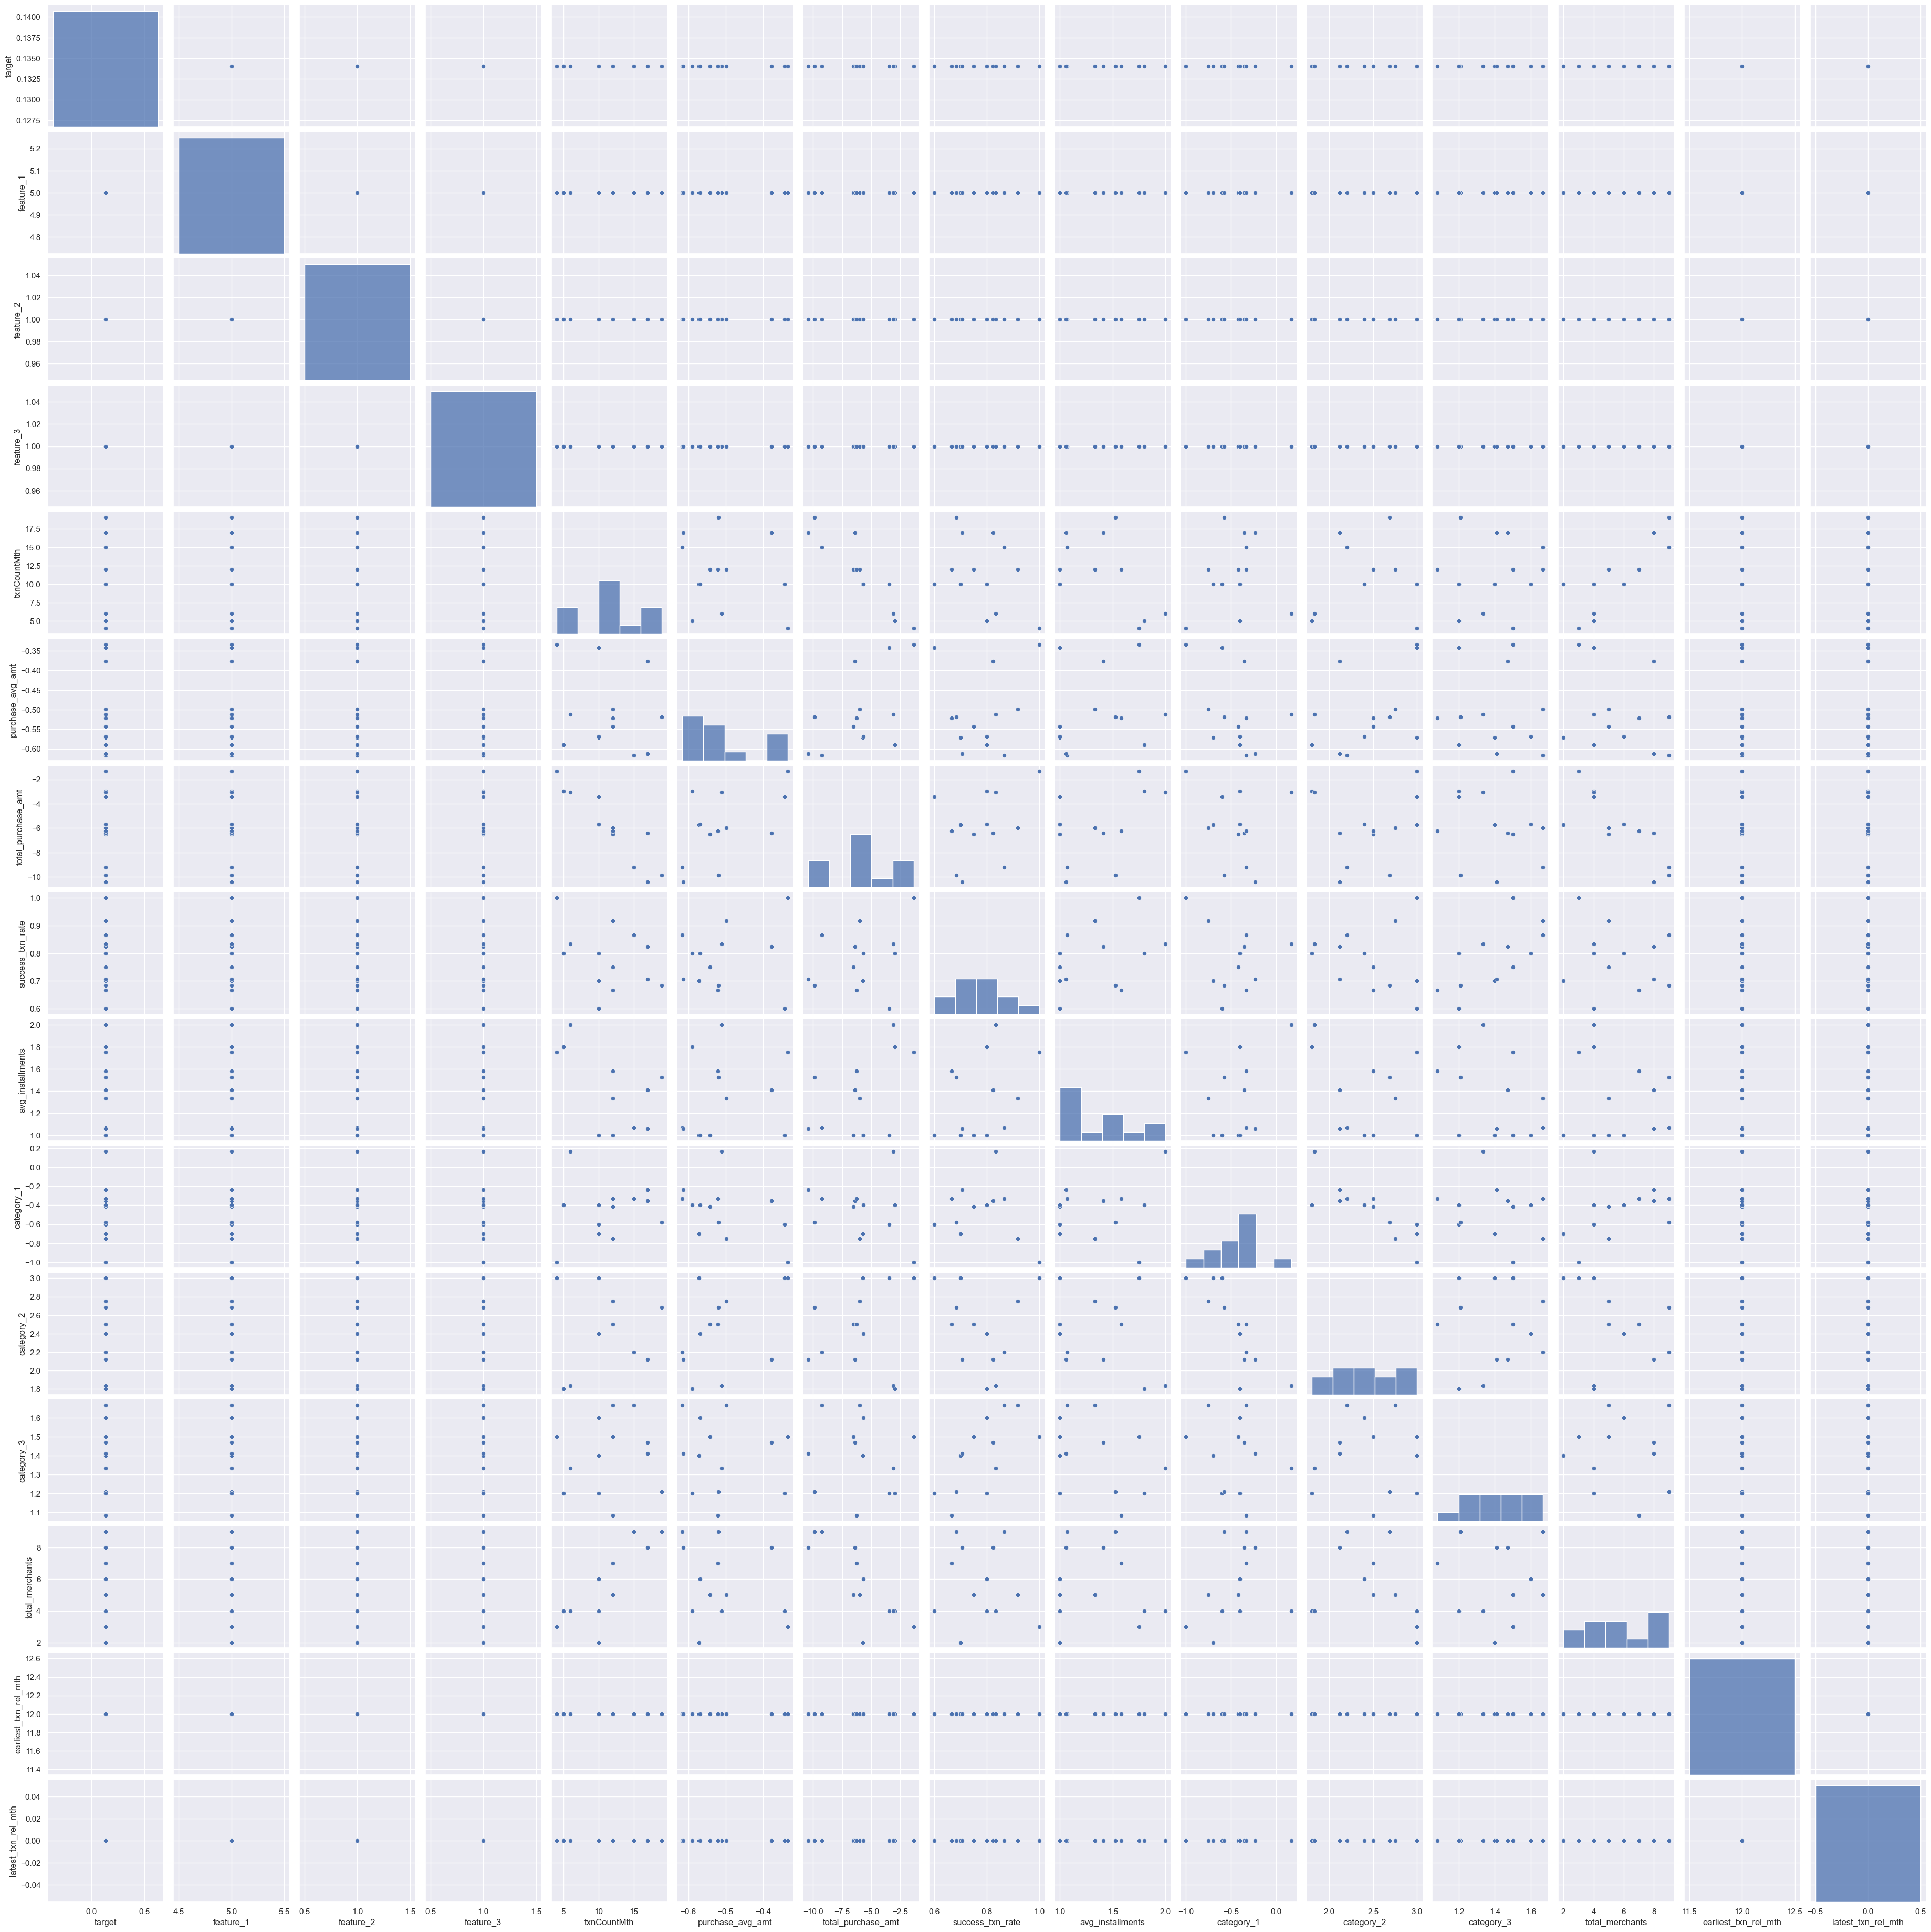

In [337]:
# sns.pairplot(df_card_id_agg1)
# plt.show()

In [183]:
sampled_monthly_agg_historical = df_monthly_agg_historical.sample(n=10, random_state=42)

In [184]:
sampled_monthly_agg_historical

card_id    target  feature_1  feature_2  feature_3  \
776300   C_ID_6ab093b23e -0.290091          5          2          1   
1415355  C_ID_c309654ecb -1.411517          5          1          1   
1771895  C_ID_f40228fc4b -0.380309          5          2          1   
96617    C_ID_0d47a9218e -0.988277          3          3          1   
968017   C_ID_85773ba8c7 -0.459687          1          3          0   
52053    C_ID_070ef49219 -1.860361          3          3          1   
1504688  C_ID_cf743cef32  0.785893          5          1          1   
711237   C_ID_61a5b05da9  0.421153          2          2          0   
648520   C_ID_5919c36c8d -0.822495          5          2          1   
1647953  C_ID_e347cf96f9  0.744641          5          1          1   

        purchase_mth  txnCountMth  purchase_avg_amt  total_purchase_amt  \
776300       2018-03            8         -0.596753           -4.774028   
1415355      2017-09            3         -0.043517           -0.130550   
1771895      2017-11            8         -0.713464           -5.707715   
96617        2017-10           22         -0.638065          -14.037422   
968017       2018-02            5         -0.646023           -3.230114   
52053        2017-12           15         -0.651897           -9.778457   
1504688      2017-05            4         -0.524023           -2.096093   
711237       2017-10            4         -0.703797           -2.815187   
648520       2018-01            2         -0.681167           -1.362334   
1647953      2017-08           11         -0.597506           -6.572566   

         purchase_amount min  purchase_amount max  purchase_amount std  \
776300             -0.735863            -0.211138             0.182731   
1415355            -0.537288             0.935761             0.848089   
1771895            -0.728500            -0.701828             0.011753   
96617              -0.723166            -0.310763             0.098622   
968017             -0.735037            -0.480608             0.103886   
52053              -0.730424            -0.491457             0.060054   
1504688            -0.611669            -0.433740             0.093102   
711237             -0.714150            -0.685930             0.013168   
648520             -0.717606            -0.644728             0.051533   
1647953            -0.716855            -0.446378             0.095175   

         success_txn_rate  avg_installments  category_1  category_2  \
776300                1.0          0.000000        -1.0    1.000000   
1415355               1.0          2.333333         1.0    0.000000   
1771895               1.0          0.000000        -1.0    2.500000   
96617                 1.0          0.000000        -1.0    4.454545   
968017                1.0          1.000000        -1.0    3.000000   
52053                 1.0          0.000000        -1.0    1.000000   
1504688               1.0          1.500000        -1.0    1.000000   
711237                1.0          0.000000        -1.0    1.000000   
648520                1.0          0.000000        -1.0    5.000000   
1647953               1.0          1.000000        -1.0    1.000000   

         category_3  total_merchants  earliest_txn_rel_mth  \
776300     3.000000                8                    -6   
1415355    1.333333                1                   -11   
1771895    3.000000                7                    -4   
96617      3.000000               15                   -13   
968017     2.000000                5                   -10   
52053      3.000000               15                   -13   
1504688    1.500000                4                    -3   
711237     3.000000                3                    -4   
648520     3.000000                2                    -4   
1647953    2.000000               10                    -6   

         latest_txn_rel_mth  newMerchantsCount  \
776300                    2                  8   
1415355                   1  

/Users/jaspreetsingh/miniconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


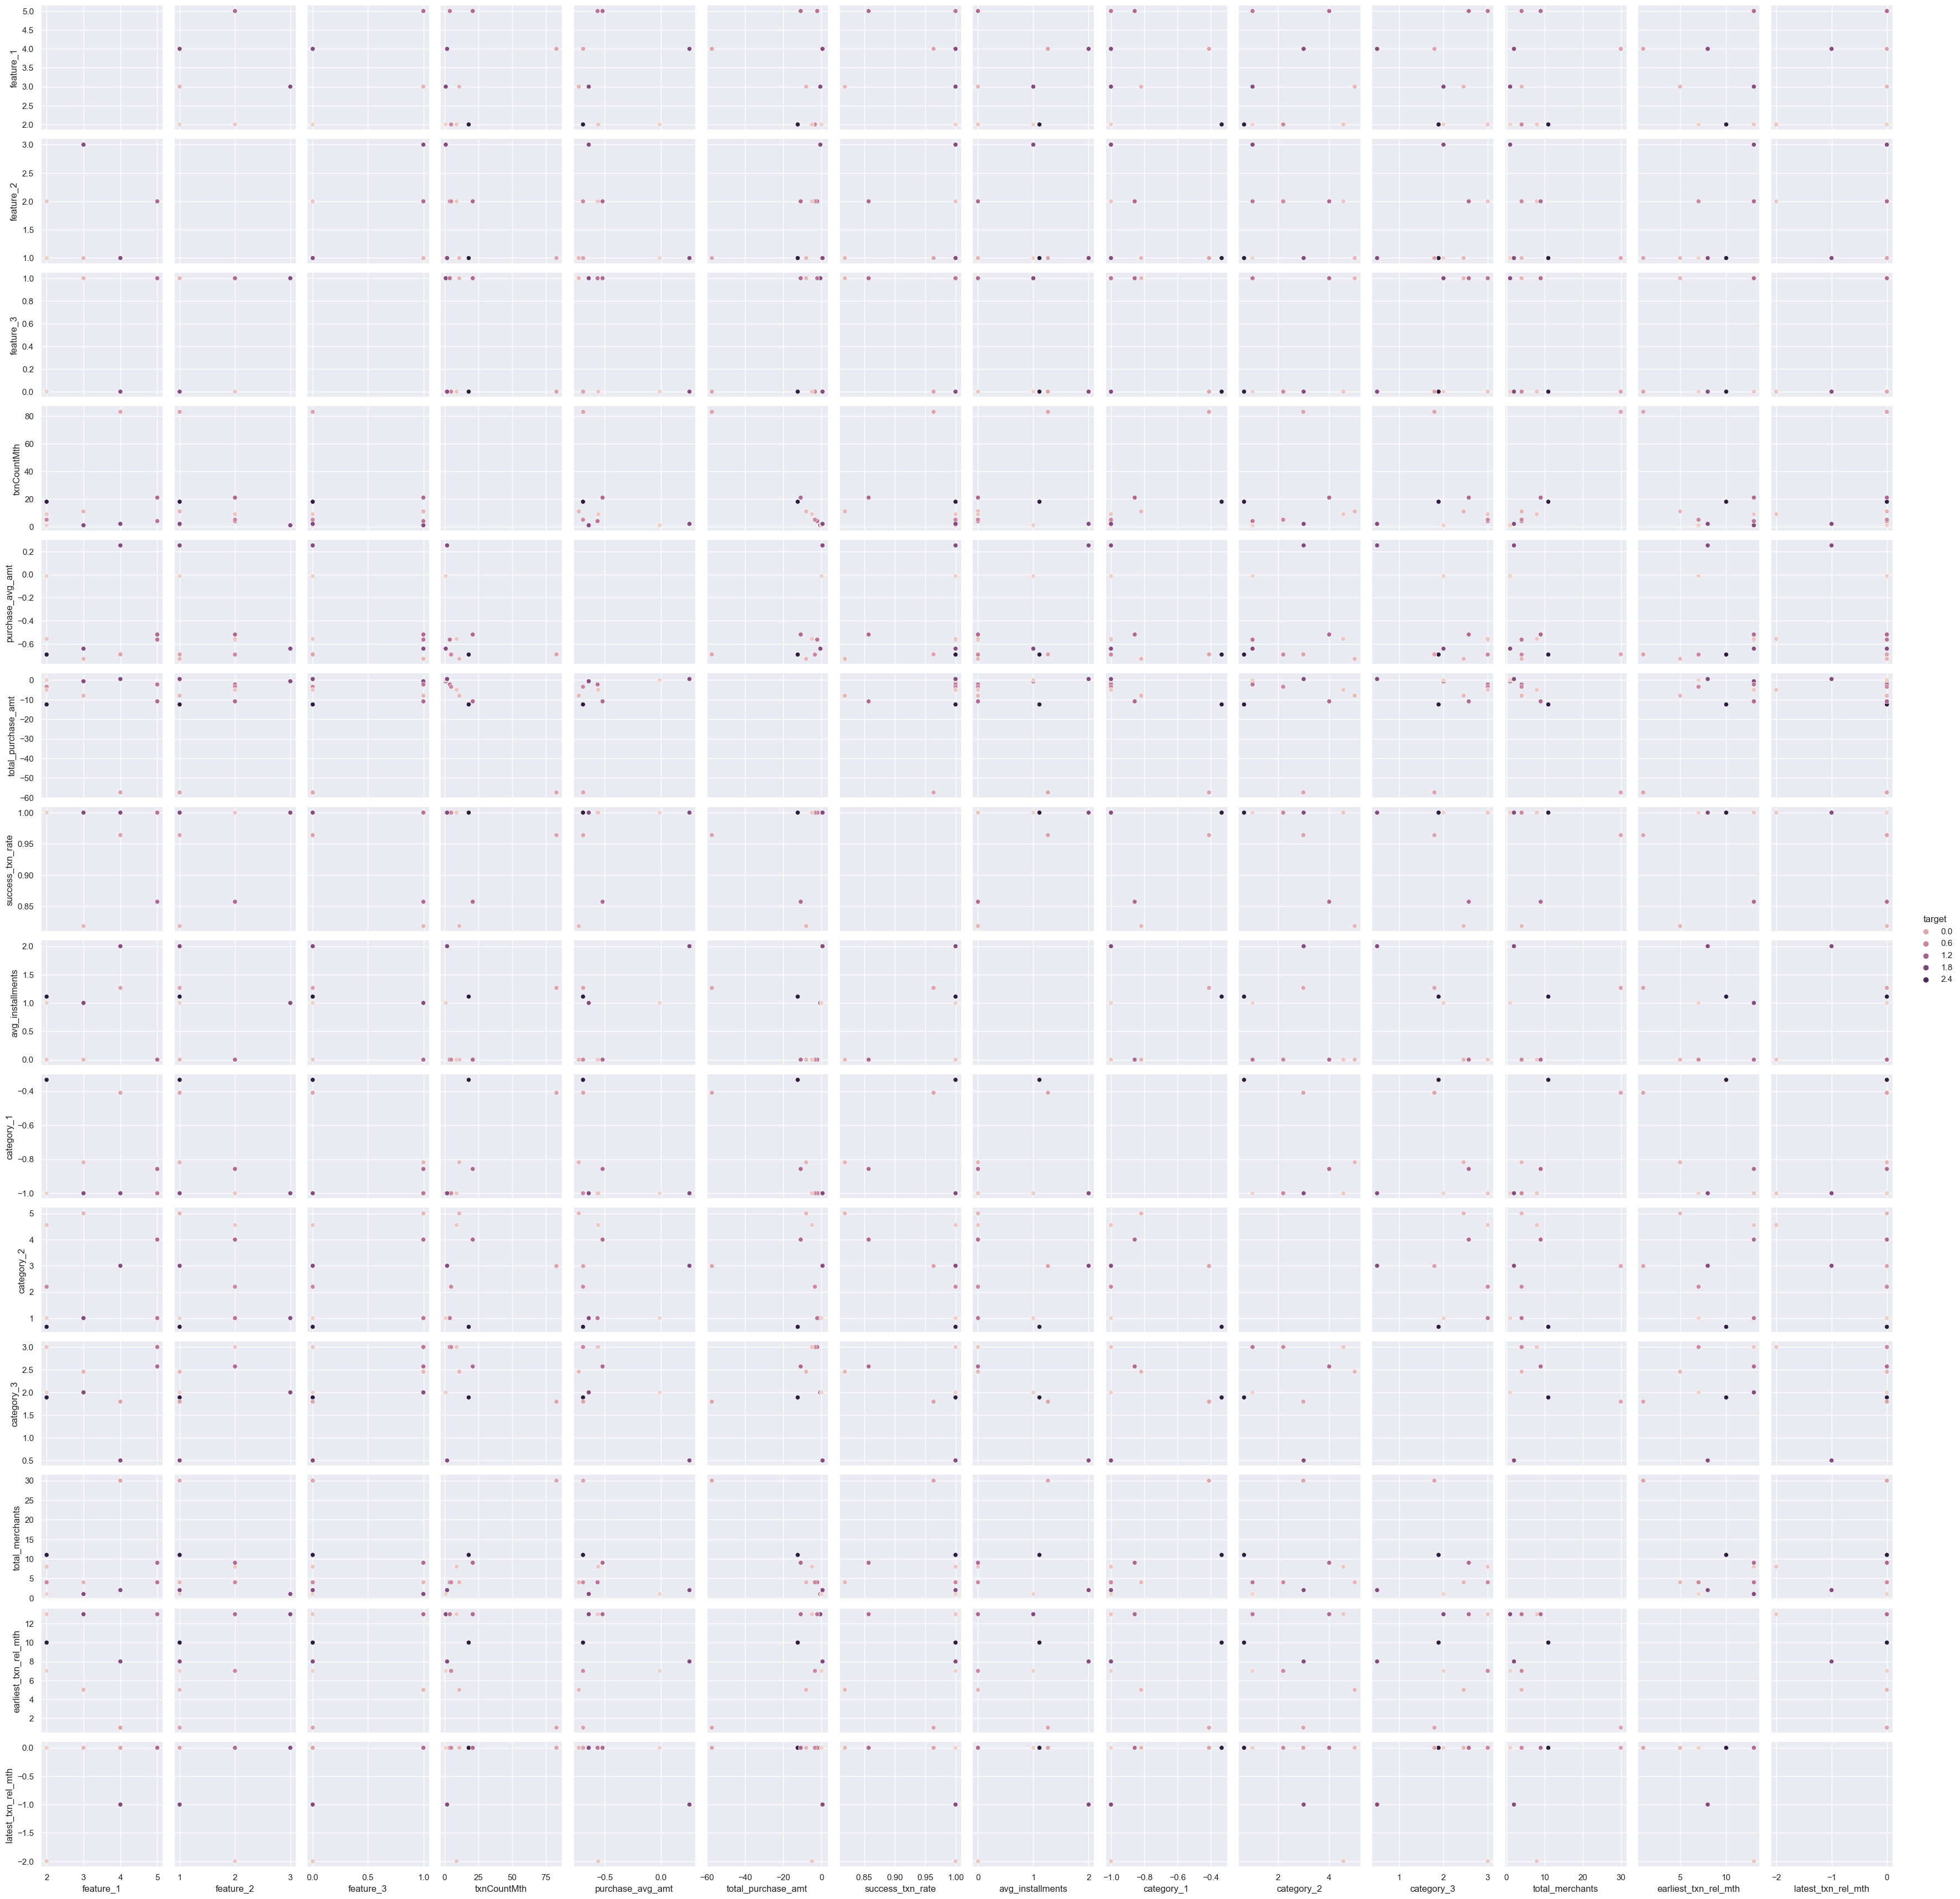

In [339]:
sns.pairplot(sampled_monthly_agg_historical, hue='target')
plt.show()

In [185]:
num_cols = sampled_monthly_agg_historical.select_dtypes(include=['float64', 'int64']).columns.tolist()
num_cols

['target',
 'feature_1',
 'feature_2',
 'feature_3',
 'txnCountMth',
 'purchase_avg_amt',
 'total_purchase_amt',
 'purchase_amount min',
 'purchase_amount max',
 'purchase_amount std',
 'success_txn_rate',
 'avg_installments',
 'category_1',
 'category_2',
 'category_3',
 'total_merchants',
 'earliest_txn_rel_mth',
 'latest_txn_rel_mth',
 'newMerchantsCount',
 'purchase_ratio_Latest_Earliest',
 'txns_amt_diff']

In [186]:
# Feature Engg => do VIF to remove features?

In [187]:
correlation_matrix = df_monthly_agg_historical[num_cols].cov()
correlation_matrix

target  feature_1  feature_2  feature_3  \
target                          14.363335  -0.059907  -0.014335  -0.013181   
feature_1                       -0.059907   1.439268  -0.143202   0.349321   
feature_2                       -0.014335  -0.143202   0.553003   0.024197   
feature_3                       -0.013181   0.349321   0.024197   0.244024   
txnCountMth                     -0.212256  -0.273765  -0.146389  -0.315950   
purchase_avg_amt                -0.012822   0.064287  -0.036247  -0.007345   
total_purchase_amt               0.100952   0.380534  -0.094295   0.110536   
purchase_amount min             -0.005398   0.035864  -0.016478  -0.000720   
purchase_amount max             -0.039739   0.072003  -0.098279  -0.051784   
purchase_amount std             -0.012448   0.035363  -0.034391  -0.015178   
success_txn_rate                 0.000000   0.000000   0.000000   0.000000   
avg_installments                -0.090229   0.080578  -0.144366  -0.091265   
category_1                      -0.057425   0.013069  -0.036497  -0.025246   
category_2                       0.087808  -0.021345   0.127118   0.027936   
category_3                       0.056189  -0.035912   0.114855   0.079342   
total_merchants                 -0.121890  -0.268322  -0.094139  -0.250312   
earliest_txn_rel_mth            -0.243946  -0.464718  -0.234637  -0.208566   
latest_txn_rel_mth              -0.045071  -0.017451  -0.013525  -0.012388   
newMerchantsCount               -0.116897  -0.051951  -0.029228  -0.041543   
purchase_ratio_Latest_Earliest   0.016601   0.009183   0.006106   0.029652   
txns_amt_diff                   -0.003626  -0.036238   0.004121  -0.007297   

                                txnCountMth  purchase_avg_amt  \
target                            -0.212256         -0.012822   
feature_1                         -0.273765          0.064287   
feature_2                         -0.146389         -0.036247   
feature_3                         -0.315950         -0.007345   
txnCountMth                      136.223002         -0.601513   
purchase_avg_amt                  -0.601513          0.408595   
total_purchase_amt               -84.823249          1.406713   
purchase_amount min               -0.653399          0.271203   
purchase_amount max                2.309830          0.667037   
purchase_amount std               -0.063272          0.237244   
success_txn_rate                   0.000000          0.000000   
avg_installments                  -1.736470          0.256738   
category_1                        -0.605876          0.022371   
category_2                         0.647969         -0.009306   
category_3                         0.971477         -0.103779   
total_merchants                   74.022458         -0.357303   
earliest_txn_rel_mth              -0.441949          0.017858   
latest_txn_rel_mth                 1.107977         -0.010397   
newMerchantsCount                 -1.017407         -0.018394   
purchase_ratio_Latest_Earliest     0.469544         -0.087754   
txns_amt_diff                    -25.866206          0.459901   

                                total_purchase_amt  purchase_amount min  \
target                                    0.100952            -0.005398   
feature_1                                 0.380534             0.035864   
feature_2                                -0.094295            -0.016478   
feature_3                                 0.110536            -0.000720   
txnCountMth                             -84.823249            -0.653399   
purchase_avg_amt                          1.406713             0.271203   
total_purchase_amt                       61.671333             0.751648   
purchase_amount min                       0.751648             0.261168   
purchase_amount max                       2.109573             0.268184   
purchase_amount std                       1.300585             0.024439   
success_txn_rate                          0.000000            

In [188]:
spearman_correlation_matrix = df_monthly_agg_historical[num_cols].corr(method='spearman')
spearman_correlation_matrix

target  feature_1  feature_2  feature_3  \
target                          1.000000  -0.014384  -0.010978  -0.011941   
feature_1                      -0.014384   1.000000  -0.124269   0.638181   
feature_2                      -0.010978  -0.124269   1.000000   0.055086   
feature_3                      -0.011941   0.638181   0.055086   1.000000   
txnCountMth                    -0.051809  -0.021992  -0.011539  -0.049437   
purchase_avg_amt               -0.014726   0.132154  -0.131946  -0.127354   
total_purchase_amt              0.042962   0.064989  -0.038553   0.022326   
purchase_amount min             0.025980   0.093372  -0.050825  -0.064156   
purchase_amount max            -0.035147   0.106721  -0.130420  -0.127102   
purchase_amount std            -0.020453   0.106372  -0.130247  -0.127520   
success_txn_rate                     NaN        NaN        NaN        NaN   
avg_installments                0.013817   0.018155  -0.282230  -0.239958   
category_1                     -0.002703  -0.005543  -0.165905  -0.161987   
category_2                      0.000973  -0.006851   0.144739   0.061258   
category_3                     -0.014016  -0.015479   0.284722   0.244256   
total_merchants                -0.054439  -0.025912  -0.008634  -0.057063   
earliest_txn_rel_mth           -0.030695  -0.106721  -0.096861  -0.117798   
latest_txn_rel_mth             -0.130925  -0.022098  -0.024031  -0.039225   
newMerchantsCount              -0.040164  -0.018610  -0.015802  -0.023904   
purchase_ratio_Latest_Earliest -0.000302  -0.034002   0.041716   0.024271   
txns_amt_diff                  -0.000545  -0.005527   0.002002  -0.001718   

                                txnCountMth  purchase_avg_amt  \
target                            -0.051809         -0.014726   
feature_1                         -0.021992          0.132154   
feature_2                         -0.011539         -0.131946   
feature_3                         -0.049437         -0.127354   
txnCountMth                        1.000000         -0.033444   
purchase_avg_amt                  -0.033444          1.000000   
total_purchase_amt                -0.924748          0.286070   
purchase_amount min               -0.566189          0.578066   
purchase_amount max                0.348901          0.873211   
purchase_amount std                0.136295          0.881097   
success_txn_rate                        NaN               NaN   
avg_installments                  -0.057019          0.440423   
category_1                         0.017625          0.148779   
category_2                         0.061962          0.001655   
category_3                         0.086372         -0.476784   
total_merchants                    0.957403          0.003544   
earliest_txn_rel_mth              -0.024296          0.008143   
latest_txn_rel_mth                 0.162435          0.021216   
newMerchantsCount                 -0.217855         -0.010660   
purchase_ratio_Latest_Earliest    -0.112894         -0.096994   
txns_amt_diff                     -0.334155          0.053302   

                                total_purchase_amt  purchase_amount min  \
target                                    0.042962             0.025980   
feature_1                                 0.064989             0.093372   
feature_2                                -0.038553            -0.050825   
feature_3                                 0.022326            -0.064156   
txnCountMth                              -0.924748            -0.566189   
purchase_avg_amt                          0.286070             0.578066   
total_purchase_amt                        1.000000             0.662694   
purchase_amount min                       0.662694             1.000000   
purchase_amount max                      -0.087572             0.222087   
purchase_amount std                       0.118621             0.268602   
success_txn_rate                               NaN                  NaN   
avg_inst

In [189]:
df_monthly_agg_historical.columns

Index(['card_id', 'target', 'feature_1', 'feature_2', 'feature_3',
       'purchase_mth', 'txnCountMth', 'purchase_avg_amt', 'total_purchase_amt',
       'purchase_amount min', 'purchase_amount max', 'purchase_amount std',
       'success_txn_rate', 'avg_installments', 'category_1', 'category_2',
       'category_3', 'total_merchants', 'earliest_txn_rel_mth',
       'latest_txn_rel_mth', 'newMerchantsCount',
       'purchase_ratio_Latest_Earliest', 'txns_amt_diff'],
      dtype='object')

In [190]:
# Define the aggregation functions for each column
agg_functions = {
    'purchase_mth':['max','count'],
    'txnCountMth': 'sum',
    'purchase_avg_amt': 'mean',
    'total_purchase_amt': 'sum',
    'success_txn_rate': 'mean',
    'avg_installments':'mean',
    'category_1':'mean',
    'category_2':'mean',
    'category_3':'mean',
    'total_merchants':'sum',
    'newMerchantsCount':'sum',
    'purchase_ratio_Latest_Earliest':['sum', 'mean'],
    'txns_amt_diff':['sum', 'mean']
}
# first_active_month not needed as we have month lag.. also 
# Calculate the monthly average and other aggregations for each card_id
df_monthly_cardids = df_monthly_agg_historical.groupby(['card_id', 'target', 'feature_1', 'feature_2', 'feature_3', 'earliest_txn_rel_mth', 'latest_txn_rel_mth']).agg(agg_functions).reset_index()
df_monthly_cardids

card_id    target feature_1 feature_2 feature_3  \
                                                                  
0       C_ID_00007093c1  0.134077         5         1         1   
1       C_ID_0001506ef0  0.884295         2         2         0   
2       C_ID_000183fdda -0.264433         4         1         0   
3       C_ID_00027503e2  0.812872         3         1         1   
4       C_ID_0002c7c2c1  1.288514         3         2         1   
...                 ...       ...       ...       ...       ...   
201912  C_ID_fffeced303  0.362965         2         1         0   
201913  C_ID_fffeed3a89 -0.085357         4         3         0   
201914  C_ID_ffff579d3a  1.530061         2         2         0   
201915  C_ID_ffff828181 -0.600063         2         1         0   
201916  C_ID_fffffd5772 -1.073077         2         1         0   

       earliest_txn_rel_mth latest_txn_rel_mth purchase_mth       txnCountMth  \
                                                        max count         sum   
0                       -12                  2      2018-04    14         116   
1                       -13                  1      2018-03    14          64   
2                        -6                  2      2018-04     8         148   
3                        -8                  0      2018-01     9          24   
4                        -9                  2      2018-03    12          64   
...                     ...                ...          ...   ...         ...   
201912                  -10                  2      2018-04    13         168   
201913                   -3                  2      2018-04     6         216   
201914                   -6                  1      2018-03     8         100   
201915                  -13                  2      2018-04    16         174   
201916                   -6                  1      2018-03     8          78   

       purchase_avg_amt total_purchase_amt success_txn_rate avg_installments  \
                   mean                sum             mean             mean   
0             -0.545283         -63.771600              1.0         1.343242   
1             -0.466447         -33.143451              1.0         0.000000   
2             -0.508442         -74.487336              1.0         1.652249   
3             -0.740077         -17.774786              1.0         0.000000   
4             -0.652514         -42.059372              1.0         0.000000   
...                 ...                ...              ...              ...   
201912        -0.689561        -115.535003              1.0         1.120059   
201913        -0.142808        -118.342586              1.0         1.362286   
201914        -0.696361         -70.342994              1.0         0.000000   
201915        -0.624684        -109.572723              1.0         1.196385   
201916        -0.691538         -53.534743              1.0         1.024012   

       category_1 category_2 category_3 total_merchants newMerchantsCount  \
             mean       mean       mean             sum               sum   
0       -0.619029   2.385687   1.822943              72                 2   
1       -1.000000   2.983193   3.000000              51                 1   
2       -0.943376   2.814876   1.639456             118                11   
3       -1.000000   2.777778   3.000000              19                 0   
4       -1.000000   1.000000   3.000000              61                 6   
...           ...        ...        ...             ...               ...   
201912   0.221827   0.389087   1.949198              71                 2   
201913  -0.565534   3.122166   1.804842             177                51   
201914  -1.000000   1.033333   3.000000              78                 1   
201915  -0.948786   1.973442   1.855252             142                 8   
201916  -0.500068   2.015253   1.942133              46                 3   

       purchase_ratio_Latest_Earliest          

In [191]:
df_monthly_cardids.columns = [' '.join(col).strip() for col in df_monthly_cardids.columns.values]
df_monthly_cardids

card_id    target  feature_1  feature_2  feature_3  \
0       C_ID_00007093c1  0.134077          5          1          1   
1       C_ID_0001506ef0  0.884295          2          2          0   
2       C_ID_000183fdda -0.264433          4          1          0   
3       C_ID_00027503e2  0.812872          3          1          1   
4       C_ID_0002c7c2c1  1.288514          3          2          1   
...                 ...       ...        ...        ...        ...   
201912  C_ID_fffeced303  0.362965          2          1          0   
201913  C_ID_fffeed3a89 -0.085357          4          3          0   
201914  C_ID_ffff579d3a  1.530061          2          2          0   
201915  C_ID_ffff828181 -0.600063          2          1          0   
201916  C_ID_fffffd5772 -1.073077          2          1          0   

        earliest_txn_rel_mth  latest_txn_rel_mth purchase_mth max  \
0                        -12                   2          2018-04   
1                        -13                   1          2018-03   
2                         -6                   2          2018-04   
3                         -8                   0          2018-01   
4                         -9                   2          2018-03   
...                      ...                 ...              ...   
201912                   -10                   2          2018-04   
201913                    -3                   2          2018-04   
201914                    -6                   1          2018-03   
201915                   -13                   2          2018-04   
201916                    -6                   1          2018-03   

        purchase_mth count  txnCountMth sum  purchase_avg_amt mean  \
0                       14              116              -0.545283   
1                       14               64              -0.466447   
2                        8              148              -0.508442   
3                        9               24              -0.740077   
4                       12               64              -0.652514   
...                    ...              ...                    ...   
201912                  13              168              -0.689561   
201913                   6              216              -0.142808   
201914                   8              100              -0.696361   
201915                  16              174              -0.624684   
201916                   8               78              -0.691538   

        total_purchase_amt sum  success_txn_rate mean  avg_installments mean  \
0                   -63.771600                    1.0               1.343242   
1                   -33.143451                    1.0               0.000000   
2                   -74.487336                    1.0               1.652249   
3                   -17.774786                    1.0               0.000000   
4                   -42.059372                    1.0               0.000000   
...                        ...                    ...                    ...   
201912             -115.535003                    1.0               1.120059   
201913             -118.342586                    1.0               1.362286   
201914              -70.342994                    1.0               0.000000   
201915             -109.572723                    1.0               1.196385   
201916              -53.534743                    1.0               1.024012   

        category_1 mean  category_2 mean  category_3 mean  \
0             -0.619029         2.385687         1.822943   
1             -1.000000         2.983193         3.000000   
2             -0.943376         2.814876         1.639456   
3             -1.000000         2.777778         3.000000   
4             -1.000000         1.000000         3.000000   
...                 ...              ...              ...   
201912         0.221827         0.389087         1.949198   
201913        -0.565534         3.122166         1.80484

In [192]:
df_monthly_cards = df_monthly_cardids.rename(columns={'purchase_mth count': 'total_months_active', 'txnCountMth sum':'totalTxns','purchase_avg_amt mean': 'purchase_avg_amt', 
                                                       'purchase_mth max': 'latest_purchase_date', 'total_purchase_amt sum': 'total_purchase_amt', 'success_txn_rate mean': 'success_txn_rate', 
                                                       'avg_installments mean': 'avg_installments',  
                                                       'category_1 mean': 'category_1', 'category_2 mean': 'category_2',
                                                        'category_3 mean': 'category_3', 'total_merchants sum': 'total_merchants', 'newMerchantsCount sum':'newMerchantsCount'})

                                                      
df_monthly_cards.head(5)

card_id    target  feature_1  feature_2  feature_3  \
0  C_ID_00007093c1  0.134077          5          1          1   
1  C_ID_0001506ef0  0.884295          2          2          0   
2  C_ID_000183fdda -0.264433          4          1          0   
3  C_ID_00027503e2  0.812872          3          1          1   
4  C_ID_0002c7c2c1  1.288514          3          2          1   

   earliest_txn_rel_mth  latest_txn_rel_mth latest_purchase_date  \
0                   -12                   2              2018-04   
1                   -13                   1              2018-03   
2                    -6                   2              2018-04   
3                    -8                   0              2018-01   
4                    -9                   2              2018-03   

   total_months_active  totalTxns  purchase_avg_amt  total_purchase_amt  \
0                   14        116         -0.545283          -63.771600   
1                   14         64         -0.466447          -33.143451   
2                    8        148         -0.508442          -74.487336   
3                    9         24         -0.740077          -17.774786   
4                   12         64         -0.652514          -42.059372   

   success_txn_rate  avg_installments  category_1  category_2  category_3  \
0               1.0          1.343242   -0.619029    2.385687    1.822943   
1               1.0          0.000000   -1.000000    2.983193    3.000000   
2               1.0          1.652249   -0.943376    2.814876    1.639456   
3               1.0          0.000000   -1.000000    2.777778    3.000000   
4               1.0          0.000000   -1.000000    1.000000    3.000000   

   total_merchants  newMerchantsCount  purchase_ratio_Latest_Earliest sum  \
0               72                  2                           13.938201   
1               51                  1                           14.298075   
2              118                 11                            0.850857   
3               19                  0                            8.945240   
4               61                  6                           41.381017   

   purchase_ratio_Latest_Earliest mean  txns_amt_diff sum  txns_amt_diff mean  
0                             0.995586           0.005890            0.000453  
1                             1.021291          -0.030173           -0.002321  
2                             0.106357          12.435055            1.776436  
3                             0.993916           0.004508            0.000563  
4                             3.448418          -1.453620           -0.132147

In [193]:
df_monthly_cards[df_monthly_cards["card_id"]=="C_ID_00007093c1"]["totalTxns"].sum()

116

### More features addition on df_monthly_cards

In [194]:
# lets try to add more features in df_monthly_cards
# using df_hist_target

# Sort by card_id and purchase_date
df_time_diff = df_hist_target.sort_values(by=['card_id', 'purchase_date'])

# Calculate the time differences between consecutive transactions
df_time_diff['txns_freq'] = df_time_diff.groupby('card_id')['purchase_date'].diff()

# Calculate the mean time difference for each "card_id"
df_mean_time_diff = df_time_diff.groupby('card_id')['txns_freq'].mean().reset_index()

# Display the result
df_mean_time_diff

card_id                  txns_freq
0       C_ID_00007093c1  3 days 15:27:51.269565217
1       C_ID_0001506ef0  6 days 20:27:35.698412698
2       C_ID_000183fdda  1 days 15:02:02.319727891
3       C_ID_00027503e2 10 days 07:22:52.652173913
4       C_ID_0002c7c2c1  5 days 10:33:43.619047619
...                 ...                        ...
201912  C_ID_fffeced303  2 days 06:43:56.455089820
201913  C_ID_fffeed3a89  0 days 19:51:07.381395348
201914  C_ID_ffff579d3a  2 days 06:30:31.424242424
201915  C_ID_ffff828181  2 days 18:28:16.624277456
201916  C_ID_fffffd5772  2 days 19:52:50.766233766

[201917 rows x 2 columns]

In [195]:
df_mean_time_diff['txns_freq'].min()

Timedelta('0 days 02:31:27.173563218')

In [196]:
# adding this feature to df_monthly_cards
df_monthly_cards_with_feature = df_monthly_cards.merge(df_mean_time_diff, on='card_id', how='left')
df_monthly_cards_with_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 24 columns):
 #   Column                               Non-Null Count   Dtype          
---  ------                               --------------   -----          
 0   card_id                              201917 non-null  object         
 1   target                               201917 non-null  float64        
 2   feature_1                            201917 non-null  int64          
 3   feature_2                            201917 non-null  int64          
 4   feature_3                            201917 non-null  int64          
 5   earliest_txn_rel_mth                 201917 non-null  int64          
 6   latest_txn_rel_mth                   201917 non-null  int64          
 7   latest_purchase_date                 201917 non-null  object         
 8   total_months_active                  201917 non-null  int64          
 9   totalTxns                            201917 non-null  int64

In [197]:
df_monthly_cards = df_monthly_cards_with_feature
df_monthly_cards

card_id    target  feature_1  feature_2  feature_3  \
0       C_ID_00007093c1  0.134077          5          1          1   
1       C_ID_0001506ef0  0.884295          2          2          0   
2       C_ID_000183fdda -0.264433          4          1          0   
3       C_ID_00027503e2  0.812872          3          1          1   
4       C_ID_0002c7c2c1  1.288514          3          2          1   
...                 ...       ...        ...        ...        ...   
201912  C_ID_fffeced303  0.362965          2          1          0   
201913  C_ID_fffeed3a89 -0.085357          4          3          0   
201914  C_ID_ffff579d3a  1.530061          2          2          0   
201915  C_ID_ffff828181 -0.600063          2          1          0   
201916  C_ID_fffffd5772 -1.073077          2          1          0   

        earliest_txn_rel_mth  latest_txn_rel_mth latest_purchase_date  \
0                        -12                   2              2018-04   
1                        -13                   1              2018-03   
2                         -6                   2              2018-04   
3                         -8                   0              2018-01   
4                         -9                   2              2018-03   
...                      ...                 ...                  ...   
201912                   -10                   2              2018-04   
201913                    -3                   2              2018-04   
201914                    -6                   1              2018-03   
201915                   -13                   2              2018-04   
201916                    -6                   1              2018-03   

        total_months_active  totalTxns  purchase_avg_amt  total_purchase_amt  \
0                        14        116         -0.545283          -63.771600   
1                        14         64         -0.466447          -33.143451   
2                         8        148         -0.508442          -74.487336   
3                         9         24         -0.740077          -17.774786   
4                        12         64         -0.652514          -42.059372   
...                     ...        ...               ...                 ...   
201912                   13        168         -0.689561         -115.535003   
201913                    6        216         -0.142808         -118.342586   
201914                    8        100         -0.696361          -70.342994   
201915                   16        174         -0.624684         -109.572723   
201916                    8         78         -0.691538          -53.534743   

        success_txn_rate  avg_installments  category_1  category_2  \
0                    1.0          1.343242   -0.619029    2.385687   
1                    1.0          0.000000   -1.000000    2.983193   
2                    1.0          1.652249   -0.943376    2.814876   
3                    1.0          0.000000   -1.000000    2.777778   
4                    1.0          0.000000   -1.000000    1.000000   
...                  ...               ...         ...         ...   
201912               1.0          1.120059    0.221827    0.389087   
201913               1.0          1.362286   -0.565534    3.122166   
201914               1.0          0.000000   -1.000000    1.033333   
201915               1.0          1.196385   -0.948786    1.973442   
201916               1.0          1.024012   -0.500068    2.015253   

        category_3  total_merchants  newMerchantsCount  \
0         1.822943               72                  2   
1         3.000000               51                  1   
2         1.639456              118                 11   
3         3.000000               19                  0   
4         3.000000               61                  6   
...            ...              ...                ...   
201912    1.949198               71                  2   
201913    1.804842              

In [199]:
df_monthly_cards[df_monthly_cards["card_id"]=="C_ID_00007093c1"]["totalTxns"]

0    116
Name: totalTxns, dtype: int64

In [200]:
# Save the DataFrame to a CSV file
df_monthly_cards.to_csv('monthly_card_ids_avgs.csv', index=False)  # Specify the file name and set index to False to exclude the index column

### Checkpoint df_monthly_cards - monthly_card_ids_avgs.csv

### every merchant how many transactions for each card & merge merchant columns

In [201]:
df_merchants = pd.read_csv('merchants.csv')
df_merchants

merchant_id  merchant_group_id  merchant_category_id  \
0       M_ID_838061e48c               8353                   792   
1       M_ID_9339d880ad               3184                   840   
2       M_ID_e726bbae1e                447                   690   
3       M_ID_a70e9c5f81               5026                   792   
4       M_ID_64456c37ce               2228                   222   
...                 ...                ...                   ...   
334691  M_ID_1f4773aa76               1145                   705   
334692  M_ID_725a60d404                 35                   544   
334693  M_ID_f2045dd267                 35                   561   
334694  M_ID_9139332ccc                 35                   511   
334695  M_ID_cd2c0b07e9                 35                   606   

        subsector_id  numerical_1  numerical_2 category_1  \
0                  9    -0.057471    -0.057471          N   
1                 20    -0.057471    -0.057471          N   
2                  1    -0.057471    -0.057471          N   
3                  9    -0.057471    -0.057471          Y   
4                 21    -0.057471    -0.057471          Y   
...              ...          ...          ...        ...   
334691            33     3.174788    -0.047556          N   
334692            29    -0.057471    -0.057471          Y   
334693             7    -0.057471    -0.057471          N   
334694             7    -0.057471    -0.057471          Y   
334695            17    -0.057471    -0.057471          N   

       most_recent_sales_range most_recent_purchases_range  avg_sales_lag3  \
0                            E                           E           -0.40   
1                            E                           E           -0.72   
2                            E                           E          -82.13   
3                            E                           E             NaN   
4                            E                           E             NaN   
...                        ...                         ...             ...   
334691                       A                           A            1.00   
334692                       A                           A            0.89   
334693                       A                           A            0.96   
334694                       A                           A            0.94   
334695                       A                           A            0.90   

        avg_purchases_lag3  active_months_lag3  avg_sales_lag6  \
0                 9.666667                   3           -2.25   
1                 1.750000                   3           -0.74   
2               260.000000                   2          -82.13   
3                 1.666667                   3             NaN   
4                 0.500000                   3             NaN   
...                    ...                 ...             ...   
334691            1.022618                   3            0.99   
334692            0.927684                   3            0.78   
334693            0.982957                   3            0.90   
334694            0.919558                   3            0.82   
334695            0.913902                   3            0.73   

        avg_purchases_lag6  active_months_lag6  avg_sales_lag12  \
0                18.666667                   6            -2.32   
1                 1.291667                   6            -0.57   
2               260.000000                   2           -82.13   
3                 4.666667                   6              NaN   
4                 0.361111                   6              NaN   
...                    ...                 ...              ...   
334691            1.019505                   6             1.00   
334692            0.813473                   6             0.59   
334693            0.924769                   6             0.74   
334694            0.783000                   6             0.6

### DATA CLEANING 

In [202]:
df_merchants.describe(include='object')

merchant_id category_1 most_recent_sales_range  \
count            334696     334696                  334696   
unique           334633          2                       5   
top     M_ID_1802942aaf          N                       E   
freq                  4     327657                  177104   

       most_recent_purchases_range category_4  
count                       334696     334696  
unique                           5          2  
top                              E          N  
freq                        175309     238596

In [203]:
data_missing = (df_merchants.isnull().sum()/df_merchants.shape[0])*100
data_missing.sort_values(ascending=False)

category_2                     3.551581
avg_sales_lag3                 0.003884
avg_sales_lag6                 0.003884
avg_sales_lag12                0.003884
merchant_id                    0.000000
merchant_group_id              0.000000
numerical_2                    0.000000
numerical_1                    0.000000
subsector_id                   0.000000
merchant_category_id           0.000000
most_recent_purchases_range    0.000000
avg_purchases_lag3             0.000000
most_recent_sales_range        0.000000
category_1                     0.000000
avg_purchases_lag6             0.000000
active_months_lag3             0.000000
avg_purchases_lag12            0.000000
active_months_lag6             0.000000
active_months_lag12            0.000000
category_4                     0.000000
city_id                        0.000000
state_id                       0.000000
dtype: float64

In [204]:
# make category_1, most_recent_sales_range, most_recent_purchases_range, category_4, category_2 numeric & remove NANs 

# let's make categorical column to numeric & handle null values
# for category_2
print("Unique category_1 values:", df_merchants["category_1"].unique())
mapping = {'Y': 1, 'N': -1}
# Use the map function to replace values in 'column_a'
df_merchants['category_1'] = df_merchants['category_1'].map(mapping)
df_merchants['category_1'].fillna(0, inplace=True)
print("Unique category_1 values after replacing NA:", df_merchants["category_1"].unique())

Unique category_1 values: ['N' 'Y']
Unique category_1 values after replacing NA: [-1  1]


In [205]:
# when category 2 is na, fill na with 0
print("Unique category 2 values:", df_merchants["category_2"].unique())
df_merchants['category_2'].fillna(0, inplace=True)
print("Unique category 2 values after replacing NA:", df_merchants["category_2"].unique())

Unique category 2 values: [ 1.  5. nan  2.  3.  4.]
Unique category 2 values after replacing NA: [1. 5. 0. 2. 3. 4.]


In [206]:
# let's make categorical column to numeric & handle null values
# when category 3 is na, fill na with 0
print("Unique category 4 values:", df_merchants["category_4"].unique())

mapping = {'Y': 1, 'N': -1}
# Use the map function to replace values in 'column_a'
df_merchants['category_4'] = df_merchants['category_4'].map(mapping)
df_merchants['category_4'].fillna(0, inplace=True)

print("Unique category_4 values after replacing NA:", df_merchants["category_4"].unique())

Unique category 4 values: ['N' 'Y']
Unique category_4 values after replacing NA: [-1  1]


In [207]:

# when most_recent_sales_range is na, fill na with 0
print("Unique most_recent_sales_range values:", df_merchants["most_recent_sales_range"].unique())

mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5}
# Use the map function to replace values in 'column_a'
df_merchants['most_recent_sales_range'] = df_merchants['most_recent_sales_range'].map(mapping)
df_merchants['most_recent_sales_range'].fillna(0, inplace=True)

print("Unique most_recent_sales_range values after replacing NA:", df_merchants["most_recent_sales_range"].unique())

Unique most_recent_sales_range values: ['E' 'C' 'D' 'A' 'B']
Unique most_recent_sales_range values after replacing NA: [5 3 4 1 2]


In [208]:

# when most_recent_purchases_range is na, fill na with 0
print("Unique most_recent_purchases_range values:", df_merchants["most_recent_purchases_range"].unique())

mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5}
# Use the map function to replace values in 'column_a'
df_merchants['most_recent_purchases_range'] = df_merchants['most_recent_purchases_range'].map(mapping)
df_merchants['most_recent_purchases_range'].fillna(0, inplace=True)

print("Unique most_recent_purchases_range values after replacing NA:", df_merchants["most_recent_purchases_range"].unique())


Unique most_recent_purchases_range values: ['E' 'D' 'C' 'A' 'B']
Unique most_recent_purchases_range values after replacing NA: [5 4 3 1 2]


In [209]:
df_merchants[df_merchants["avg_sales_lag3"]==0.0]

Empty DataFrame
Columns: [merchant_id, merchant_group_id, merchant_category_id, subsector_id, numerical_1, numerical_2, category_1, most_recent_sales_range, most_recent_purchases_range, avg_sales_lag3, avg_purchases_lag3, active_months_lag3, avg_sales_lag6, avg_purchases_lag6, active_months_lag6, avg_sales_lag12, avg_purchases_lag12, active_months_lag12, category_4, city_id, state_id, category_2]
Index: []

In [210]:
df_merchants['avg_sales_lag6'].fillna(0, inplace=True)
df_merchants['avg_sales_lag12'].fillna(0, inplace=True)
df_merchants['avg_sales_lag3'].fillna(0, inplace=True)

In [211]:
data_missing = (df_merchants.isnull().sum()/df_merchants.shape[0])*100
data_missing.sort_values(ascending=False)

merchant_id                    0.0
merchant_group_id              0.0
merchant_category_id           0.0
subsector_id                   0.0
numerical_1                    0.0
numerical_2                    0.0
category_1                     0.0
most_recent_sales_range        0.0
most_recent_purchases_range    0.0
avg_sales_lag3                 0.0
avg_purchases_lag3             0.0
active_months_lag3             0.0
avg_sales_lag6                 0.0
avg_purchases_lag6             0.0
active_months_lag6             0.0
avg_sales_lag12                0.0
avg_purchases_lag12            0.0
active_months_lag12            0.0
category_4                     0.0
city_id                        0.0
state_id                       0.0
category_2                     0.0
dtype: float64

In [212]:
# DATA CLEANING - 334696-334633 = 63 merchant_ids are repeated
# there are some repetitions in df_merchants merchant_id values (unexpectedly), so needs cleaning!!
df_merchants[df_merchants["merchant_id"]=="M_ID_00a6ca8a8a"]

merchant_id  merchant_group_id  merchant_category_id  \
110969  M_ID_00a6ca8a8a                 35                   511   
110970  M_ID_00a6ca8a8a                 35                   511   

        subsector_id  numerical_1  numerical_2  category_1  \
110969             7    -0.047556    -0.057471           1   
110970             7    -0.057471    -0.057471           1   

        most_recent_sales_range  most_recent_purchases_range  avg_sales_lag3  \
110969                        5                            5            6.93   
110970                        1                            1            0.93   

        avg_purchases_lag3  active_months_lag3  avg_sales_lag6  \
110969           12.705128                   3            8.42   
110970            0.949288                   3            0.86   

        avg_purchases_lag6  active_months_lag6  avg_sales_lag12  \
110969           15.855769                   6             8.57   
110970            0.871214                   6             0.76   

        avg_purchases_lag12  active_months_lag12  category_4  city_id  \
110969            16.219780                    7           1       -1   
110970             0.752641                   12           1       -1   

        state_id  category_2  
110969        -1         0.0  
110970        -1         0.0

In [213]:
# Define the aggregation functions for each column
agg_functions = {
    'merchant_group_id':'max',
    'merchant_category_id':'max',
    'numerical_1': 'mean',
    'numerical_2': 'mean',
    'most_recent_sales_range': 'sum',
    'most_recent_purchases_range': 'sum',
    'avg_sales_lag3':'sum',
    'avg_purchases_lag3':'sum',
    'active_months_lag3':'max',
    'avg_sales_lag6':'sum',
    'avg_purchases_lag6':'sum',
    'active_months_lag6':'max',
    'avg_sales_lag12':'sum',
    'avg_purchases_lag12':'sum',
    'active_months_lag12':'max',
    'category_1':'max',
    'category_2':'max',
    'category_4':'max',
    'subsector_id':'max',
    'city_id':'max',
    'state_id':'max'
}

df_merchants_agg = df_merchants.groupby(['merchant_id']).agg(agg_functions).reset_index()
df_merchants_agg

merchant_id  merchant_group_id  merchant_category_id  numerical_1  \
0       M_ID_000025127f              14602                    80    -0.057471   
1       M_ID_0000699140              19420                    87    -0.057471   
2       M_ID_00006a5552              52848                   178    -0.057471   
3       M_ID_000087311e              44655                   206    -0.057471   
4       M_ID_0000ab0b2d              35761                   367    -0.057471   
...                 ...                ...                   ...          ...   
334628  M_ID_fffeeb852d                 35                    33     0.031763   
334629  M_ID_fffef87522                 35                   409     0.051593   
334630  M_ID_ffff0af8e7               4739                   278    -0.057471   
334631  M_ID_ffff655e2c             105563                   215    -0.057471   
334632  M_ID_ffffc28eaa              20228                   705    -0.047556   

        numerical_2  most_recent_sales_range  most_recent_purchases_range  \
0         -0.057471                        5                            5   
1         -0.057471                        4                            4   
2         -0.057471                        5                            5   
3         -0.057471                        4                            5   
4         -0.057471                        4                            4   
...             ...                      ...                          ...   
334628     0.031763                        4                            4   
334629     0.051593                        5                            5   
334630    -0.057471                        4                            4   
334631    -0.057471                        4                            5   
334632    -0.057471                        4                            4   

        avg_sales_lag3  avg_purchases_lag3  active_months_lag3  \
0                 1.29            1.880342                   3   
1                 0.99            0.997832                   3   
2                 1.21            1.000000                   3   
3                 0.93            1.314815                   3   
4                 1.05            1.089897                   3   
...                ...                 ...                 ...   
334628            0.72            1.016340                   3   
334629            1.28            1.728070                   3   
334630            0.90            0.909420                   3   
334631            0.61            0.788889                   3   
334632            0.91            0.971014                   3   

        avg_sales_lag6  avg_purchases_lag6  active_months_lag6  \
0                 1.26            2.228632                   6   
1                 1.04            1.002168                   6   
2                 1.18            1.000000                   6   
3                 0.95            1.300926                   6   
4                 0.99            1.057279                   6   
...                ...                 ...                 ...   
334628            0.81            1.125817                   6   
334629            1.34            1.879825                   6   
334630            0.91            0.935990                   6   
334631            0.55            0.772222                   6   
334632            0.91            0.999147                   6   

        avg_sales_lag12  avg_purchases_lag12  active_months_lag12  category_1  \
0                  1.08             2.089744                   12          -1   
1                  1.24             1.154878                   12          -1   
2                  1.22             1.035714                   12          -1   
3                  0.78             1.261574                   12           1   
4                  1.06             1.135640                   12          -1   
...                 ...                  .

In [214]:
df_merchants_agg[df_merchants_agg["merchant_id"]=="M_ID_00a6ca8a8a"]

merchant_id  merchant_group_id  merchant_category_id  numerical_1  \
854  M_ID_00a6ca8a8a                 35                   511    -0.052513   

     numerical_2  most_recent_sales_range  most_recent_purchases_range  \
854    -0.057471                        6                            6   

     avg_sales_lag3  avg_purchases_lag3  active_months_lag3  avg_sales_lag6  \
854            7.86           13.654417                   3            9.28   

     avg_purchases_lag6  active_months_lag6  avg_sales_lag12  \
854           16.726983                   6             9.33   

     avg_purchases_lag12  active_months_lag12  category_1  category_2  \
854            16.972421                   12           1         0.0   

     category_4  subsector_id  city_id  state_id  
854           1             7       -1        -1

In [215]:
df_merchants_agg.describe(include='object')

merchant_id
count            334633
unique           334633
top     M_ID_ffffc28eaa
freq                  1

In [216]:
df_merchants_agg.columns

Index(['merchant_id', 'merchant_group_id', 'merchant_category_id',
       'numerical_1', 'numerical_2', 'most_recent_sales_range',
       'most_recent_purchases_range', 'avg_sales_lag3', 'avg_purchases_lag3',
       'active_months_lag3', 'avg_sales_lag6', 'avg_purchases_lag6',
       'active_months_lag6', 'avg_sales_lag12', 'avg_purchases_lag12',
       'active_months_lag12', 'category_1', 'category_2', 'category_4',
       'subsector_id', 'city_id', 'state_id'],
      dtype='object')

In [217]:
df_hist_target_merchant_ids = df_hist_target.groupby(['card_id', 'merchant_id']).size().reset_index(name='totalTxnsByMerchant')
df_hist_target_merchant_ids

card_id      merchant_id  totalTxnsByMerchant
0        C_ID_00007093c1  M_ID_00a6ca8a8a                    1
1        C_ID_00007093c1  M_ID_0379adb435                    4
2        C_ID_00007093c1  M_ID_06a8d84366                    1
3        C_ID_00007093c1  M_ID_08f01305af                    1
4        C_ID_00007093c1  M_ID_0dabc5a70c                    2
...                  ...              ...                  ...
7829333  C_ID_fffffd5772  M_ID_d6626c9a19                    2
7829334  C_ID_fffffd5772  M_ID_db0fa76591                    5
7829335  C_ID_fffffd5772  M_ID_e80ebae5da                    4
7829336  C_ID_fffffd5772  M_ID_e8c10bd049                    1
7829337  C_ID_fffffd5772  M_ID_fc7d7969c3                    1

[7829338 rows x 3 columns]

In [218]:
df_hist_target_merchant_ids[df_hist_target_merchant_ids["card_id"]=="C_ID_00007093c1"]["totalTxnsByMerchant"].sum()

116

In [219]:
df_hist_target_merchants = df_hist_target_merchant_ids.merge(df_merchants_agg, on='merchant_id', how='left')
df_hist_target_merchants

card_id      merchant_id  totalTxnsByMerchant  \
0        C_ID_00007093c1  M_ID_00a6ca8a8a                    1   
1        C_ID_00007093c1  M_ID_0379adb435                    4   
2        C_ID_00007093c1  M_ID_06a8d84366                    1   
3        C_ID_00007093c1  M_ID_08f01305af                    1   
4        C_ID_00007093c1  M_ID_0dabc5a70c                    2   
...                  ...              ...                  ...   
7829333  C_ID_fffffd5772  M_ID_d6626c9a19                    2   
7829334  C_ID_fffffd5772  M_ID_db0fa76591                    5   
7829335  C_ID_fffffd5772  M_ID_e80ebae5da                    4   
7829336  C_ID_fffffd5772  M_ID_e8c10bd049                    1   
7829337  C_ID_fffffd5772  M_ID_fc7d7969c3                    1   

         merchant_group_id  merchant_category_id  numerical_1  numerical_2  \
0                       35                   511    -0.052513    -0.057471   
1                    39381                    45    -0.057471    -0.057471   
2                     4462                   437    -0.037641    -0.047556   
3                     2674                   222    -0.057471    -0.057471   
4                       35                   298     2.381596     2.381596   
...                    ...                   ...          ...          ...   
7829333             104398                   705    -0.057471    -0.057471   
7829334                 35                    80     8.171900     8.102496   
7829335                 35                    87     1.866021     1.856106   
7829336                 35                   422     5.088365     4.820662   
7829337             104706                   661    -0.057471    -0.057471   

         most_recent_sales_range  most_recent_purchases_range  avg_sales_lag3  \
0                              6                            6            7.86   
1                              4                            5            1.02   
2                              2                            2            0.94   
3                              4                            5            0.90   
4                              2                            3            1.09   
...                          ...                          ...             ...   
7829333                        4                            4            1.16   
7829334                        2                            1            1.04   
7829335                        2                            3            0.83   
7829336                        2                            2            0.76   
7829337                        1                            1            0.88   

         avg_purchases_lag3  active_months_lag3  avg_sales_lag6  \
0                 13.654417                   3            9.28   
1                  1.151515                   3            0.81   
2                  0.974674                   3            0.95   
3                  0.943503                   3            1.07   
4                  1.116429                   3            1.13   
...                     ...                 ...             ...   
7829333            1.229706                   3            1.23   
7829334            1.047878                   3            1.15   
7829335            0.883509                   3            0.77   
7829336            0.839525                   3            0.69   
7829337            0.890464                   3            0.72   

         avg_purchases_lag6  active_months_lag6  avg_sales_lag12  \
0                 16.726983                   6             9.33   
1                  0.984848                   6             0.68   
2                  0.980327                   6             0.95   
3                  1.022599                   6             1.08   
4                  1.139232                   6             1.11   
...                     ...                 ...              ...   
7829333            1.184801      

In [220]:
df_hist_target_merchant_ids.shape

(7829338, 3)

In [221]:
df_hist_target_merchants.shape

(7829338, 24)

In [222]:
df_hist_target_merchants[df_hist_target_merchants["card_id"]=="C_ID_00007093c1"]["totalTxnsByMerchant"].sum()

116

In [223]:
df_hist_target_merchants.columns

Index(['card_id', 'merchant_id', 'totalTxnsByMerchant', 'merchant_group_id',
       'merchant_category_id', 'numerical_1', 'numerical_2',
       'most_recent_sales_range', 'most_recent_purchases_range',
       'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3',
       'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6',
       'avg_sales_lag12', 'avg_purchases_lag12', 'active_months_lag12',
       'category_1', 'category_2', 'category_4', 'subsector_id', 'city_id',
       'state_id'],
      dtype='object')

### Do weighted average for all merchants present in card id

In [224]:
num_cols_hist_target_merchants = df_hist_target_merchants.select_dtypes(include=['float64', 'int64']).columns.tolist()
print(num_cols_hist_target_merchants)
print("\nafter removing categorical cols that are numeric\n")
      
# Columns to remove
columns_to_remove = ['merchant_group_id', 'merchant_category_id', 'subsector_id', 'city_id', 
                     'state_id']

# Create a new list of columns excluding the ones to remove
num_cols_hist_target_merchants = [col for col in num_cols_hist_target_merchants if col not in columns_to_remove]

# Display the filtered list of columns
print(num_cols_hist_target_merchants)

['totalTxnsByMerchant', 'merchant_group_id', 'merchant_category_id', 'numerical_1', 'numerical_2', 'most_recent_sales_range', 'most_recent_purchases_range', 'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3', 'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6', 'avg_sales_lag12', 'avg_purchases_lag12', 'active_months_lag12', 'category_1', 'category_2', 'category_4', 'subsector_id', 'city_id', 'state_id']

after removing categorical cols that are numeric

['totalTxnsByMerchant', 'numerical_1', 'numerical_2', 'most_recent_sales_range', 'most_recent_purchases_range', 'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3', 'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6', 'avg_sales_lag12', 'avg_purchases_lag12', 'active_months_lag12', 'category_1', 'category_2', 'category_4']


In [225]:
df = df_hist_target_merchants.copy()
# Calculate the weighted average for each numeric column
for col in num_cols_hist_target_merchants:
    df[col + '_weighted_avg'] = df[col] * df['totalTxnsByMerchant']

# Group by card_id and calculate the sum of weighted averages for each numeric column
agg_columns = [col + '_weighted_avg' for col in num_cols_hist_target_merchants]
agg_columns.append('totalTxnsByMerchant')  # Include the totalTxnsByMerchant column for aggregation

agg_df = df.groupby('card_id')[agg_columns].sum().reset_index()

# Calculate the final weighted average for each numeric column
for col in num_cols_hist_target_merchants:
    agg_df[col + '_weighted_avg'] = agg_df[col + '_weighted_avg'] / agg_df['totalTxnsByMerchant']

df_merchants_card = agg_df
df_merchants_card

card_id  totalTxnsByMerchant_weighted_avg  \
0       C_ID_00007093c1                         15.241379   
1       C_ID_0001506ef0                          5.444444   
2       C_ID_000183fdda                          3.540541   
3       C_ID_00027503e2                          5.833333   
4       C_ID_0002c7c2c1                          2.500000   
...                 ...                               ...   
201912  C_ID_fffeced303                         60.023810   
201913  C_ID_fffeed3a89                          2.440758   
201914  C_ID_ffff579d3a                          2.720000   
201915  C_ID_ffff828181                          7.931034   
201916  C_ID_fffffd5772                         10.282051   

        numerical_1_weighted_avg  numerical_2_weighted_avg  \
0                       1.949571                  1.933459   
1                       0.965968                  0.828103   
2                       0.208791                  0.162600   
3                       0.021435                  0.017717   
4                      12.534071                 11.499900   
...                          ...                       ...   
201912                  2.198908                  2.093237   
201913                  4.332553                  4.269704   
201914                  6.016499                  5.900891   
201915                  0.557567                  0.545116   
201916                  1.891761                  1.841106   

        most_recent_sales_range_weighted_avg  \
0                                   2.767241   
1                                   2.365079   
2                                   3.027027   
3                                   3.416667   
4                                   2.453125   
...                                      ...   
201912                              1.505952   
201913                              3.085308   
201914                              3.070000   
201915                              3.028736   
201916                              2.423077   

        most_recent_purchases_range_weighted_avg  avg_sales_lag3_weighted_avg  \
0                                       2.870690                     1.033966   
1                                       2.365079                     1.254762   
2                                       3.148649                     1.346892   
3                                       3.250000                     1.566667   
4                                       2.437500                     1.370625   
...                                          ...                          ...   
201912                                  1.494048                     1.258690   
201913                                  3.109005                     1.453744   
201914                                  2.790000                     1.264000   
201915                                  3.086207                     1.059540   
201916                                  2.448718                     1.124231   

        avg_purchases_lag3_weighted_avg  active_months_lag3_weighted_avg  \
0                              1.104747                              3.0   
1                              1.460071                              3.0   
2                              1.619501                              3.0   
3                              2.047820                              3.0   
4                              1.688421                              3.0   
...                                 ...                              ...   
201912                         1.487015                              3.0   
201913                         1.803865                              3.0   
201914                         1.281398                              3.0   
201915                         1.159253                              3.0   
201916                         1.233966                              3.0   

        avg_sales_lag6_weighted_avg  avg_purchases_lag6_weighted_avg  \
0  

In [226]:
df_merchants_card[df_merchants_card["card_id"]=="C_ID_00007093c1"]["totalTxnsByMerchant"]

0    116
Name: totalTxnsByMerchant, dtype: int64

In [227]:
# Save the DataFrame to a CSV file
df_merchants_card.to_csv('merchants_card_details.csv', index=False)  # Specify the file name and set index to False to exclude the index column

### Checkpoint - df_merchants_card - merchants_card_details.csv

In [228]:
df_monthly_cards["card_id"].count()

201917

### merge df_monthly_cards with df_merchants_card

In [229]:
# adding this feature to df_monthly_cards
df_monthly_cards_with_merchant_features = df_monthly_cards.merge(df_merchants_card, on='card_id', how='left')
df_monthly_cards_with_merchant_features

card_id    target  feature_1  feature_2  feature_3  \
0       C_ID_00007093c1  0.134077          5          1          1   
1       C_ID_0001506ef0  0.884295          2          2          0   
2       C_ID_000183fdda -0.264433          4          1          0   
3       C_ID_00027503e2  0.812872          3          1          1   
4       C_ID_0002c7c2c1  1.288514          3          2          1   
...                 ...       ...        ...        ...        ...   
201912  C_ID_fffeced303  0.362965          2          1          0   
201913  C_ID_fffeed3a89 -0.085357          4          3          0   
201914  C_ID_ffff579d3a  1.530061          2          2          0   
201915  C_ID_ffff828181 -0.600063          2          1          0   
201916  C_ID_fffffd5772 -1.073077          2          1          0   

        earliest_txn_rel_mth  latest_txn_rel_mth latest_purchase_date  \
0                        -12                   2              2018-04   
1                        -13                   1              2018-03   
2                         -6                   2              2018-04   
3                         -8                   0              2018-01   
4                         -9                   2              2018-03   
...                      ...                 ...                  ...   
201912                   -10                   2              2018-04   
201913                    -3                   2              2018-04   
201914                    -6                   1              2018-03   
201915                   -13                   2              2018-04   
201916                    -6                   1              2018-03   

        total_months_active  totalTxns  purchase_avg_amt  total_purchase_amt  \
0                        14        116         -0.545283          -63.771600   
1                        14         64         -0.466447          -33.143451   
2                         8        148         -0.508442          -74.487336   
3                         9         24         -0.740077          -17.774786   
4                        12         64         -0.652514          -42.059372   
...                     ...        ...               ...                 ...   
201912                   13        168         -0.689561         -115.535003   
201913                    6        216         -0.142808         -118.342586   
201914                    8        100         -0.696361          -70.342994   
201915                   16        174         -0.624684         -109.572723   
201916                    8         78         -0.691538          -53.534743   

        success_txn_rate  avg_installments  category_1  category_2  \
0                    1.0          1.343242   -0.619029    2.385687   
1                    1.0          0.000000   -1.000000    2.983193   
2                    1.0          1.652249   -0.943376    2.814876   
3                    1.0          0.000000   -1.000000    2.777778   
4                    1.0          0.000000   -1.000000    1.000000   
...                  ...               ...         ...         ...   
201912               1.0          1.120059    0.221827    0.389087   
201913               1.0          1.362286   -0.565534    3.122166   
201914               1.0          0.000000   -1.000000    1.033333   
201915               1.0          1.196385   -0.948786    1.973442   
201916               1.0          1.024012   -0.500068    2.015253   

        category_3  total_merchants  newMerchantsCount  \
0         1.822943               72                  2   
1         3.000000               51                  1   
2         1.639456              118                 11   
3         3.000000               19                  0   
4         3.000000               61                  6   
...            ...              ...                ...   
201912    1.949198               71                  2   
201913    1.804842              

In [230]:
df_monthly_cards_with_merchant_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 42 columns):
 #   Column                                    Non-Null Count   Dtype          
---  ------                                    --------------   -----          
 0   card_id                                   201917 non-null  object         
 1   target                                    201917 non-null  float64        
 2   feature_1                                 201917 non-null  int64          
 3   feature_2                                 201917 non-null  int64          
 4   feature_3                                 201917 non-null  int64          
 5   earliest_txn_rel_mth                      201917 non-null  int64          
 6   latest_txn_rel_mth                        201917 non-null  int64          
 7   latest_purchase_date                      201917 non-null  object         
 8   total_months_active                       201917 non-null  int64          
 9   tota

In [231]:
# avg_purchases_lag12_weighted_avg avg_purchases_lag3_weighted_avg avg_purchases_lag6_weighted_avg remove NANs
df_monthly_cards_with_merchant_features['avg_purchases_lag12_weighted_avg'].fillna(0, inplace=True)
df_monthly_cards_with_merchant_features['avg_purchases_lag3_weighted_avg'].fillna(0, inplace=True)
df_monthly_cards_with_merchant_features['avg_purchases_lag6_weighted_avg'].fillna(0, inplace=True)

df_monthly_cards_with_merchant_features['avg_purchases_lag12_weighted_avg'] = df_monthly_cards_with_merchant_features['avg_purchases_lag12_weighted_avg'].replace([np.inf, -np.inf], 0)
df_monthly_cards_with_merchant_features['avg_purchases_lag3_weighted_avg'] = df_monthly_cards_with_merchant_features['avg_purchases_lag3_weighted_avg'].replace([np.inf, -np.inf], 0)
df_monthly_cards_with_merchant_features['avg_purchases_lag6_weighted_avg'] = df_monthly_cards_with_merchant_features['avg_purchases_lag6_weighted_avg'].replace([np.inf, -np.inf], 0)


In [232]:
df_monthly_cards_with_merchant_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 42 columns):
 #   Column                                    Non-Null Count   Dtype          
---  ------                                    --------------   -----          
 0   card_id                                   201917 non-null  object         
 1   target                                    201917 non-null  float64        
 2   feature_1                                 201917 non-null  int64          
 3   feature_2                                 201917 non-null  int64          
 4   feature_3                                 201917 non-null  int64          
 5   earliest_txn_rel_mth                      201917 non-null  int64          
 6   latest_txn_rel_mth                        201917 non-null  int64          
 7   latest_purchase_date                      201917 non-null  object         
 8   total_months_active                       201917 non-null  int64          
 9   tota

In [234]:
# No null values in df_monthly_cards_with_merchant_features and data is cleaned now
df_monthly_cards_with_merchant_features_2 = df_monthly_cards_with_merchant_features.drop('time_diff', axis=1)
df_monthly_cards_with_merchant_features_2

In [20]:
df_monthly_cards_with_merchant_features = df_monthly_cards_with_merchant_features_2

In [235]:
# Save the DataFrame to a CSV file
df_monthly_cards_with_merchant_features.to_csv('monthly_cards_with_merchant_features.csv', index=False)  # Specify the file name and set index to False to exclude the index column

## Checkpoint - df_monthly_cards_with_merchant_features - card_ids with all features

In [236]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# from pyspark.sql import SparkSession
# spark = SparkSession.builder.appName("Elo").getOrCreate()
# df = spark.read.csv('historical_transactions.csv', header=True, inferSchema=True)
# spark.stop()

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)



In [237]:
df_monthly_cards_with_merchant_features = pd.read_csv('monthly_cards_with_merchant_features.csv')

In [238]:
df_monthly_cards_with_merchant_features.head(1)

card_id    target  feature_1  feature_2  feature_3  \
0  C_ID_00007093c1  0.134077          5          1          1   

   earliest_txn_rel_mth  latest_txn_rel_mth latest_purchase_date  \
0                   -12                   2              2018-04   

   total_months_active  totalTxns  purchase_avg_amt  total_purchase_amt  \
0                   14        116         -0.545283            -63.7716   

   success_txn_rate  avg_installments  category_1  category_2  category_3  \
0               1.0          1.343242   -0.619029    2.385687    1.822943   

   total_merchants  newMerchantsCount  purchase_ratio_Latest_Earliest sum  \
0               72                  2                           13.938201   

   purchase_ratio_Latest_Earliest mean  txns_amt_diff sum  txns_amt_diff mean  \
0                             0.995586            0.00589            0.000453   

                   txns_freq  totalTxnsByMerchant_weighted_avg  \
0  3 days 15:27:51.269565217                         15.241379   

   numerical_1_weighted_avg  numerical_2_weighted_avg  \
0                  1.949571                  1.933459   

   most_recent_sales_range_weighted_avg  \
0                              2.767241   

   most_recent_purchases_range_weighted_avg  avg_sales_lag3_weighted_avg  \
0                                   2.87069                     1.033966   

   avg_purchases_lag3_weighted_avg  active_months_lag3_weighted_avg  \
0                         1.104747                              3.0   

   avg_sales_lag6_weighted_avg  avg_purchases_lag6_weighted_avg  \
0                        1.075                         1.159898   

   active_months_lag6_weighted_avg  avg_sales_lag12_weighted_avg  \
0                              6.0                      1.098879   

   avg_purchases_lag12_weighted_avg  active_months_lag12_weighted_avg  \
0                          1.178649                         11.896552   

   category_1_weighted_avg  category_2_weighted_avg  category_4_weighted_avg  \
0                -0.568966                 2.353448                -0.275862   

   totalTxnsByMerchant  
0                  116

In [239]:
df = df_monthly_cards_with_merchant_features

# Separate the DataFrame into two based on the target value (positive and negative)
positive_samples = df[df['target'] >= 0]
negative_samples = df[df['target'] < 0]

# # Find unique combinations for positive and negative samples
# unique_positive_combinations = positive_samples[['feature_1', 'feature_2', 'feature_3']].drop_duplicates()
# unique_negative_combinations = negative_samples[['feature_1', 'feature_2', 'feature_3']].drop_duplicates()


# # Display the unique combinations
# print("Unique combinations for positive target values:")
# print(unique_positive_combinations)

# print("\nUnique combinations for negative target values:")
# print(unique_negative_combinations)

# Group by target and feature combinations and count occurrences
unique_positive_combinations = positive_samples.groupby(['feature_1', 'feature_2', 'feature_3', 'earliest_txn_rel_mth', 'latest_txn_rel_mth']).size().reset_index(name='count')
unique_negative_combinations = negative_samples.groupby(['feature_1', 'feature_2', 'feature_3', 'earliest_txn_rel_mth', 'latest_txn_rel_mth']).size().reset_index(name='count')

# Display the unique combinations
print("Unique combinations for positive target values:")
print(unique_positive_combinations)

print("\nUnique combinations for negative target values:")
print(unique_negative_combinations)


Unique combinations for positive target values:
     feature_1  feature_2  feature_3  earliest_txn_rel_mth  \
0            1          1          0                   -13   
1            1          1          0                   -13   
2            1          1          0                   -13   
3            1          1          0                   -13   
4            1          1          0                   -12   
..         ...        ...        ...                   ...   
934          5          2          1                    -2   
935          5          2          1                    -2   
936          5          2          1                    -2   
937          5          2          1                    -1   
938          5          2          1                    -1   

     latest_txn_rel_mth  count  
0                    -1      1  
1                     0     32  
2                     1     32  
3                     2    250  
4                    -2      1  
..       

In [240]:
# Preparation for model training
# lets do one hot encoding for feature_1, feature_2, feature_3

In [241]:
# Perform one-hot encoding for categorical columns
df_encoded_card_ids = pd.get_dummies(df_monthly_cards_with_merchant_features, columns=['feature_1', 'feature_2', 'feature_3'])
df_encoded_card_ids

card_id    target  earliest_txn_rel_mth  latest_txn_rel_mth  \
0       C_ID_00007093c1  0.134077                   -12                   2   
1       C_ID_0001506ef0  0.884295                   -13                   1   
2       C_ID_000183fdda -0.264433                    -6                   2   
3       C_ID_00027503e2  0.812872                    -8                   0   
4       C_ID_0002c7c2c1  1.288514                    -9                   2   
...                 ...       ...                   ...                 ...   
201912  C_ID_fffeced303  0.362965                   -10                   2   
201913  C_ID_fffeed3a89 -0.085357                    -3                   2   
201914  C_ID_ffff579d3a  1.530061                    -6                   1   
201915  C_ID_ffff828181 -0.600063                   -13                   2   
201916  C_ID_fffffd5772 -1.073077                    -6                   1   

       latest_purchase_date  total_months_active  totalTxns  purchase_avg_amt  \
0                   2018-04                   14        116         -0.545283   
1                   2018-03                   14         64         -0.466447   
2                   2018-04                    8        148         -0.508442   
3                   2018-01                    9         24         -0.740077   
4                   2018-03                   12         64         -0.652514   
...                     ...                  ...        ...               ...   
201912              2018-04                   13        168         -0.689561   
201913              2018-04                    6        216         -0.142808   
201914              2018-03                    8        100         -0.696361   
201915              2018-04                   16        174         -0.624684   
201916              2018-03                    8         78         -0.691538   

        total_purchase_amt  success_txn_rate  avg_installments  category_1  \
0               -63.771600               1.0          1.343242   -0.619029   
1               -33.143451               1.0          0.000000   -1.000000   
2               -74.487336               1.0          1.652249   -0.943376   
3               -17.774786               1.0          0.000000   -1.000000   
4               -42.059372               1.0          0.000000   -1.000000   
...                    ...               ...               ...         ...   
201912         -115.535003               1.0          1.120059    0.221827   
201913         -118.342586               1.0          1.362286   -0.565534   
201914          -70.342994               1.0          0.000000   -1.000000   
201915         -109.572723               1.0          1.196385   -0.948786   
201916          -53.534743               1.0          1.024012   -0.500068   

        category_2  category_3  total_merchants  newMerchantsCount  \
0         2.385687    1.822943               72                  2   
1         2.983193    3.000000               51                  1   
2         2.814876    1.639456              118                 11   
3         2.777778    3.000000               19                  0   
4         1.000000    3.000000               61                  6   
...            ...         ...              ...                ...   
201912    0.389087    1.949198               71                  2   
201913    3.122166    1.804842              177                 51   
201914    1.033333    3.000000               78                  1   
201915    1.973442    1.855252              142                  8   
201916    2.015253    1.942133               46                  3   

        purchase_ratio_Latest_Earliest sum  \
0                                13.938201   
1                                14.298075   
2                                 0.850857   
3                                 8.945240   
4                                41.381017   
...                                    .

In [242]:
# Save the encoded DataFrame to a CSV file
df_encoded_card_ids.to_csv('encoded_card_ids.csv', index=False)  # Specify the file name and set index to False to exclude the index column

## Checkpoint df_encoded_card_ids - encoded_card_ids.csv

In [243]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

df_encoded_card_ids = pd.read_csv('encoded_card_ids.csv')

In [244]:
df_encoded_card_ids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 49 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   card_id                                   201917 non-null  object 
 1   target                                    201917 non-null  float64
 2   earliest_txn_rel_mth                      201917 non-null  int64  
 3   latest_txn_rel_mth                        201917 non-null  int64  
 4   latest_purchase_date                      201917 non-null  object 
 5   total_months_active                       201917 non-null  int64  
 6   totalTxns                                 201917 non-null  int64  
 7   purchase_avg_amt                          201917 non-null  float64
 8   total_purchase_amt                        201917 non-null  float64
 9   success_txn_rate                          201917 non-null  float64
 10  avg_installments    

In [245]:
df_encoded_card_ids.describe(include='object')

card_id latest_purchase_date                  txns_freq
count            201917               201917                     201917
unique           201917                   15                     201892
top     C_ID_fffffd5772              2018-04  3 days 16:29:43.569230769
freq                  1               104166                          2

In [246]:
df_encoded_card_ids.head(1)

card_id    target  earliest_txn_rel_mth  latest_txn_rel_mth  \
0  C_ID_00007093c1  0.134077                   -12                   2   

  latest_purchase_date  total_months_active  totalTxns  purchase_avg_amt  \
0              2018-04                   14        116         -0.545283   

   total_purchase_amt  success_txn_rate  avg_installments  category_1  \
0            -63.7716               1.0          1.343242   -0.619029   

   category_2  category_3  total_merchants  newMerchantsCount  \
0    2.385687    1.822943               72                  2   

   purchase_ratio_Latest_Earliest sum  purchase_ratio_Latest_Earliest mean  \
0                           13.938201                             0.995586   

   txns_amt_diff sum  txns_amt_diff mean                  txns_freq  \
0            0.00589            0.000453  3 days 15:27:51.269565217   

   totalTxnsByMerchant_weighted_avg  numerical_1_weighted_avg  \
0                         15.241379                  1.949571   

   numerical_2_weighted_avg  most_recent_sales_range_weighted_avg  \
0                  1.933459                              2.767241   

   most_recent_purchases_range_weighted_avg  avg_sales_lag3_weighted_avg  \
0                                   2.87069                     1.033966   

   avg_purchases_lag3_weighted_avg  active_months_lag3_weighted_avg  \
0                         1.104747                              3.0   

   avg_sales_lag6_weighted_avg  avg_purchases_lag6_weighted_avg  \
0                        1.075                         1.159898   

   active_months_lag6_weighted_avg  avg_sales_lag12_weighted_avg  \
0                              6.0                      1.098879   

   avg_purchases_lag12_weighted_avg  active_months_lag12_weighted_avg  \
0                          1.178649                         11.896552   

   category_1_weighted_avg  category_2_weighted_avg  category_4_weighted_avg  \
0                -0.568966                 2.353448                -0.275862   

   totalTxnsByMerchant  feature_1_1  feature_1_2  feature_1_3  feature_1_4  \
0                  116        False        False        False        False   

   feature_1_5  feature_2_1  feature_2_2  feature_2_3  feature_3_0  \
0         True         True        False        False        False   

   feature_3_1  
0         True

In [247]:
df_encoded_card_ids

card_id    target  earliest_txn_rel_mth  latest_txn_rel_mth  \
0       C_ID_00007093c1  0.134077                   -12                   2   
1       C_ID_0001506ef0  0.884295                   -13                   1   
2       C_ID_000183fdda -0.264433                    -6                   2   
3       C_ID_00027503e2  0.812872                    -8                   0   
4       C_ID_0002c7c2c1  1.288514                    -9                   2   
...                 ...       ...                   ...                 ...   
201912  C_ID_fffeced303  0.362965                   -10                   2   
201913  C_ID_fffeed3a89 -0.085357                    -3                   2   
201914  C_ID_ffff579d3a  1.530061                    -6                   1   
201915  C_ID_ffff828181 -0.600063                   -13                   2   
201916  C_ID_fffffd5772 -1.073077                    -6                   1   

       latest_purchase_date  total_months_active  totalTxns  purchase_avg_amt  \
0                   2018-04                   14        116         -0.545283   
1                   2018-03                   14         64         -0.466447   
2                   2018-04                    8        148         -0.508442   
3                   2018-01                    9         24         -0.740077   
4                   2018-03                   12         64         -0.652514   
...                     ...                  ...        ...               ...   
201912              2018-04                   13        168         -0.689561   
201913              2018-04                    6        216         -0.142808   
201914              2018-03                    8        100         -0.696361   
201915              2018-04                   16        174         -0.624684   
201916              2018-03                    8         78         -0.691538   

        total_purchase_amt  success_txn_rate  avg_installments  category_1  \
0               -63.771600               1.0          1.343242   -0.619029   
1               -33.143451               1.0          0.000000   -1.000000   
2               -74.487336               1.0          1.652249   -0.943376   
3               -17.774786               1.0          0.000000   -1.000000   
4               -42.059372               1.0          0.000000   -1.000000   
...                    ...               ...               ...         ...   
201912         -115.535003               1.0          1.120059    0.221827   
201913         -118.342586               1.0          1.362286   -0.565534   
201914          -70.342994               1.0          0.000000   -1.000000   
201915         -109.572723               1.0          1.196385   -0.948786   
201916          -53.534743               1.0          1.024012   -0.500068   

        category_2  category_3  total_merchants  newMerchantsCount  \
0         2.385687    1.822943               72                  2   
1         2.983193    3.000000               51                  1   
2         2.814876    1.639456              118                 11   
3         2.777778    3.000000               19                  0   
4         1.000000    3.000000               61                  6   
...            ...         ...              ...                ...   
201912    0.389087    1.949198               71                  2   
201913    3.122166    1.804842              177                 51   
201914    1.033333    3.000000               78                  1   
201915    1.973442    1.855252              142                  8   
201916    2.015253    1.942133               46                  3   

        purchase_ratio_Latest_Earliest sum  \
0                                13.938201   
1                                14.298075   
2                                 0.850857   
3                                 8.945240   
4                                41.381017   
...                                    .

<Axes: xlabel='target', ylabel='Count'>

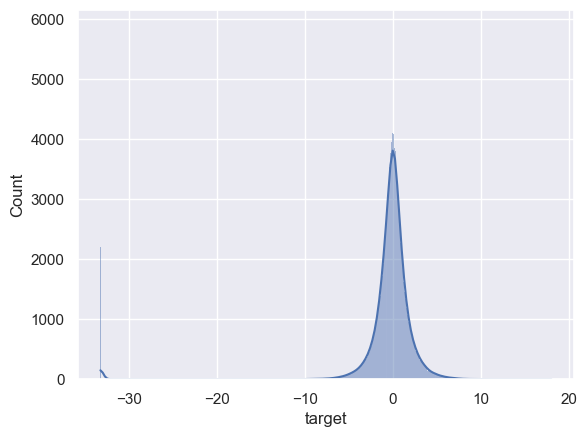

In [6]:
sns.set()
sns.histplot(df_encoded_card_ids['target'], kde=True)

In [248]:
# removing noisy data, we already analysed above it is random in nature
df_training = df_encoded_card_ids[df_encoded_card_ids['target']>-30]
df_training

card_id    target  earliest_txn_rel_mth  latest_txn_rel_mth  \
0       C_ID_00007093c1  0.134077                   -12                   2   
1       C_ID_0001506ef0  0.884295                   -13                   1   
2       C_ID_000183fdda -0.264433                    -6                   2   
3       C_ID_00027503e2  0.812872                    -8                   0   
4       C_ID_0002c7c2c1  1.288514                    -9                   2   
...                 ...       ...                   ...                 ...   
201912  C_ID_fffeced303  0.362965                   -10                   2   
201913  C_ID_fffeed3a89 -0.085357                    -3                   2   
201914  C_ID_ffff579d3a  1.530061                    -6                   1   
201915  C_ID_ffff828181 -0.600063                   -13                   2   
201916  C_ID_fffffd5772 -1.073077                    -6                   1   

       latest_purchase_date  total_months_active  totalTxns  purchase_avg_amt  \
0                   2018-04                   14        116         -0.545283   
1                   2018-03                   14         64         -0.466447   
2                   2018-04                    8        148         -0.508442   
3                   2018-01                    9         24         -0.740077   
4                   2018-03                   12         64         -0.652514   
...                     ...                  ...        ...               ...   
201912              2018-04                   13        168         -0.689561   
201913              2018-04                    6        216         -0.142808   
201914              2018-03                    8        100         -0.696361   
201915              2018-04                   16        174         -0.624684   
201916              2018-03                    8         78         -0.691538   

        total_purchase_amt  success_txn_rate  avg_installments  category_1  \
0               -63.771600               1.0          1.343242   -0.619029   
1               -33.143451               1.0          0.000000   -1.000000   
2               -74.487336               1.0          1.652249   -0.943376   
3               -17.774786               1.0          0.000000   -1.000000   
4               -42.059372               1.0          0.000000   -1.000000   
...                    ...               ...               ...         ...   
201912         -115.535003               1.0          1.120059    0.221827   
201913         -118.342586               1.0          1.362286   -0.565534   
201914          -70.342994               1.0          0.000000   -1.000000   
201915         -109.572723               1.0          1.196385   -0.948786   
201916          -53.534743               1.0          1.024012   -0.500068   

        category_2  category_3  total_merchants  newMerchantsCount  \
0         2.385687    1.822943               72                  2   
1         2.983193    3.000000               51                  1   
2         2.814876    1.639456              118                 11   
3         2.777778    3.000000               19                  0   
4         1.000000    3.000000               61                  6   
...            ...         ...              ...                ...   
201912    0.389087    1.949198               71                  2   
201913    3.122166    1.804842              177                 51   
201914    1.033333    3.000000               78                  1   
201915    1.973442    1.855252              142                  8   
201916    2.015253    1.942133               46                  3   

        purchase_ratio_Latest_Earliest sum  \
0                                13.938201   
1                                14.298075   
2                                 0.850857   
3                                 8.945240   
4                                41.381017   
...                                    .

<Axes: xlabel='target', ylabel='Count'>

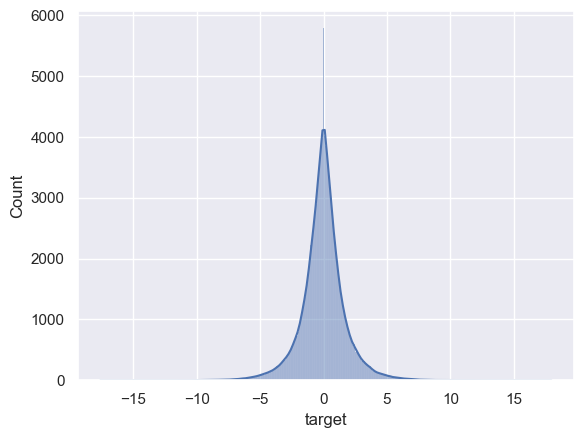

In [249]:
sns.histplot(df_training['target'], kde=True)

In [250]:
df_training.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199710 entries, 0 to 201916
Data columns (total 49 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   card_id                                   199710 non-null  object 
 1   target                                    199710 non-null  float64
 2   earliest_txn_rel_mth                      199710 non-null  int64  
 3   latest_txn_rel_mth                        199710 non-null  int64  
 4   latest_purchase_date                      199710 non-null  object 
 5   total_months_active                       199710 non-null  int64  
 6   totalTxns                                 199710 non-null  int64  
 7   purchase_avg_amt                          199710 non-null  float64
 8   total_purchase_amt                        199710 non-null  float64
 9   success_txn_rate                          199710 non-null  float64
 10  avg_installments         

In [254]:
# Extract date components as separate features
df = df_training.copy()

df_training['latest_purchase_date_dt'] = pd.to_datetime(df_training['latest_purchase_date'])
df['latest_purchase_date_dt'] = pd.to_datetime(df_training['latest_purchase_date'])
df['year_latest_purchase_date'] = df_training['latest_purchase_date_dt'].dt.year
df['month_latest_purchase_date'] = df_training['latest_purchase_date_dt'].dt.month
df['day_latest_purchase_date'] = df_training['latest_purchase_date_dt'].dt.day


# Extract date components as separate features
# df_training['latest_purchase_date_dt'] = pd.to_datetime(df_training['latest_purchase_date'])

# Create new columns without the warning using .loc
# df_training.loc[:, 'year_latest_purchase_date'] = df_training['latest_purchase_date_dt'].dt.year
# df_training.loc[:, 'month_latest_purchase_date'] = df_training['latest_purchase_date_dt'].dt.month
# df_training.loc[:, 'day_latest_purchase_date'] = df_training['latest_purchase_date_dt'].dt.day


In [255]:
df['txns_freq'] = pd.to_timedelta(df_training['txns_freq'])

# Extract the total number of seconds from the timedelta
df['txns_frequency_seconds'] = df['txns_freq'].dt.total_seconds()
df['txns_frequency_seconds']

0         314871.269565
1         592055.698413
2         140522.319728
3         890572.652174
4         470023.619048
              ...      
201912    197036.455090
201913     71467.381395
201914    196231.424242
201915    239296.624277
201916    244370.766234
Name: txns_frequency_seconds, Length: 199710, dtype: float64

In [256]:
df_clean = df.drop(['latest_purchase_date', 'latest_purchase_date_dt', 'txns_freq'], axis=1)

In [257]:
df_training = df_clean
df_training.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199710 entries, 0 to 201916
Data columns (total 51 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   card_id                                   199710 non-null  object 
 1   target                                    199710 non-null  float64
 2   earliest_txn_rel_mth                      199710 non-null  int64  
 3   latest_txn_rel_mth                        199710 non-null  int64  
 4   total_months_active                       199710 non-null  int64  
 5   totalTxns                                 199710 non-null  int64  
 6   purchase_avg_amt                          199710 non-null  float64
 7   total_purchase_amt                        199710 non-null  float64
 8   success_txn_rate                          199710 non-null  float64
 9   avg_installments                          199710 non-null  float64
 10  category_1               

In [258]:
# Save the encoded DataFrame to a CSV file
df_training.to_csv('training_df.csv', index=False)  # Specify the file name and set index to False to exclude the index column

## Linear & Polynomial Regression

In [1]:
## Reference: https://www.kaggle.com/rinnqd/reduce-memory-usage

def reduce_memory_usage(df, verbose=True):
  '''
  This function reduces the memory sizes of dataframe by changing the datatypes of the columns.
  Parameters
  df - DataFrame whose size to be reduced
  verbose - Boolean, to mention the verbose required or not.
  '''
  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  start_mem = df.memory_usage().sum() / 1024**2
  for col in df.columns:
      col_type = df[col].dtypes
      if col_type in numerics:
          c_min = df[col].min()
          c_max = df[col].max()
          if str(col_type)[:3] == 'int':
              if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                  df[col] = df[col].astype(np.int8)
              elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                  df[col] = df[col].astype(np.int16)
              elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                  df[col] = df[col].astype(np.int32)
              elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                  df[col] = df[col].astype(np.int64)
          else:
              c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
              if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                  df[col] = df[col].astype(np.float16)
              elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                  df[col] = df[col].astype(np.float32)
              else:
                  df[col] = df[col].astype(np.float64)
  end_mem = df.memory_usage().sum() / 1024**2
  if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
  return df

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

df_training = pd.read_csv('training_df.csv')

In [3]:
df_training = reduce_memory_usage(df_training)
df_training

Mem. usage decreased to 51.80 Mb (19.5% reduction)


card_id    target  earliest_txn_rel_mth  latest_txn_rel_mth  \
0       C_ID_00007093c1  0.134077                   -12                   2   
1       C_ID_0001506ef0  0.884295                   -13                   1   
2       C_ID_000183fdda -0.264433                    -6                   2   
3       C_ID_00027503e2  0.812872                    -8                   0   
4       C_ID_0002c7c2c1  1.288514                    -9                   2   
...                 ...       ...                   ...                 ...   
199705  C_ID_fffeced303  0.362965                   -10                   2   
199706  C_ID_fffeed3a89 -0.085357                    -3                   2   
199707  C_ID_ffff579d3a  1.530061                    -6                   1   
199708  C_ID_ffff828181 -0.600063                   -13                   2   
199709  C_ID_fffffd5772 -1.073077                    -6                   1   

        total_months_active  totalTxns  purchase_avg_amt  total_purchase_amt  \
0                        14        116         -0.545283          -63.771600   
1                        14         64         -0.466447          -33.143451   
2                         8        148         -0.508442          -74.487336   
3                         9         24         -0.740077          -17.774786   
4                        12         64         -0.652514          -42.059372   
...                     ...        ...               ...                 ...   
199705                   13        168         -0.689561         -115.535003   
199706                    6        216         -0.142808         -118.342586   
199707                    8        100         -0.696361          -70.342994   
199708                   16        174         -0.624684         -109.572723   
199709                    8         78         -0.691538          -53.534743   

        success_txn_rate  avg_installments  category_1  category_2  \
0                    1.0          1.343242   -0.619029    2.385687   
1                    1.0          0.000000   -1.000000    2.983193   
2                    1.0          1.652249   -0.943376    2.814876   
3                    1.0          0.000000   -1.000000    2.777778   
4                    1.0          0.000000   -1.000000    1.000000   
...                  ...               ...         ...         ...   
199705               1.0          1.120059    0.221827    0.389087   
199706               1.0          1.362286   -0.565534    3.122166   
199707               1.0          0.000000   -1.000000    1.033333   
199708               1.0          1.196385   -0.948786    1.973442   
199709               1.0          1.024012   -0.500068    2.015253   

        category_3  total_merchants  newMerchantsCount  \
0         1.822943               72                  2   
1         3.000000               51                  1   
2         1.639456              118                 11   
3         3.000000               19                  0   
4         3.000000               61                  6   
...            ...              ...                ...   
199705    1.949198               71                  2   
199706    1.804842              177                 51   
199707    3.000000               78                  1   
199708    1.855252              142                  8   
199709    1.942133               46                  3   

        purchase_ratio_Latest_Earliest sum  \
0                                13.938201   
1                                14.298075   
2                                 0.850857   
3                                 8.945240   
4                                41.381017   
...                                    ...   
199705                            1.600746   
199706                          -12.445830   
199707                            0.357010   
199708                            6.041954   
199709                           23.195802   

        purchas

In [23]:
from sklearn.decomposition import PCA
# Create a PCA instance with the desired number of components (e.g., 3)
n_components = 5
pca = PCA(n_components=n_components)
X_reduced = pca.fit_transform(X)
X_reduced

array([[-3.67331982e+05, -2.02836349e+02,  4.76232160e+00,
         1.00237409e+00,  8.45181987e+00],
       [-9.01475464e+04, -2.12847267e+02,  5.54577849e+00,
         1.56799605e+00, -4.82455564e+01],
       [-5.41680936e+05, -1.92727929e+02, -8.59600147e+00,
         1.63515119e+00,  5.05332415e+01],
       ...,
       [-4.85971825e+05, -1.95823834e+02, -9.02082202e+00,
         1.50824390e+00, -1.77976964e+01],
       [-4.42906637e+05, -1.98728640e+02, -3.24763817e+00,
         1.27129819e+00,  1.13191713e+02],
       [-4.37832479e+05, -2.00057520e+02,  1.40642629e+01,
         7.78973077e-01, -5.74023201e+01]])

In [6]:
# Split data into X (features) and y (target)
X = df_training.drop(['target','card_id'], axis=1)
y = df_training['target']

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

In [298]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [278]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Score: 0.005219952263580407


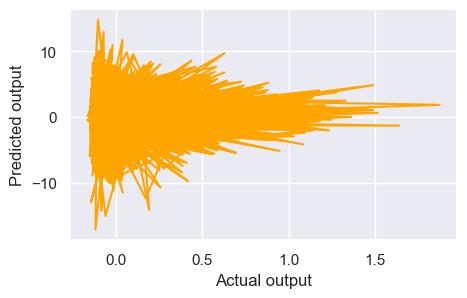

In [279]:

from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

output = model.predict(X_test)

print("Score:", model.score(X_test,y_test))

fig = plt.figure(figsize=(5, 3))
# plt.scatter(y, output, label="samples")
plt.plot(output, y_test, label="prediction", color='orange')
plt.xlabel("Actual output")
plt.ylabel("Predicted output")
plt.show()

In [264]:
from sklearn.metrics import mean_squared_error, r2_score
# Evaluate model performance
mse = mean_squared_error(y_test, output)
r2 = r2_score(y_test, output)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R^2) Score: {r2}')

Mean Squared Error (MSE): 2.7368979540762264
R-squared (R^2) Score: 0.06369093687183724


In [7]:
# Polynomial regression
from sklearn.preprocessing import PolynomialFeatures
degree = 2 #3
poly = PolynomialFeatures(degree=degree)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

model.fit(X_train_poly_scaled , y_train)
output = model.predict(X_test_poly_scaled)

print("Score:", model.score(X_test_poly_scaled,y_test))

Score: -0.0055831280819742535


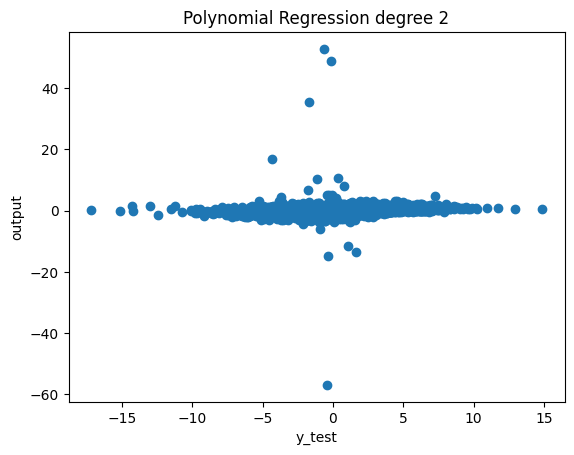

In [10]:
# plt.scatter(X_train, y_train, color='blue', label='Actual Data')
plt.scatter(y_test, output)
# plt.legend()
plt.xlabel('y_test')
plt.ylabel('output')
plt.title('Polynomial Regression degree 2')
plt.show()

In [11]:
from sklearn.metrics import mean_squared_error, r2_score
# Evaluate model performance
mse = mean_squared_error(y_test, output)
r2 = r2_score(y_test, output)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R^2) Score: {r2}')

Mean Squared Error (MSE): 2.9393909706547467
R-squared (R^2) Score: -0.0055831280819742535


## Linear Regression - Mini Batch processing

In [280]:
# Model output function 
def predict(X, weight):
    return np.dot(X, weight)

In [281]:
# function to compute gradient of error function w.r.t. weight
def gradient(X, y, weight):
    y_pred = predict(X, weight)
    grad = np.dot(X.transpose(), (y_pred - y))
    return grad

In [282]:
# function to compute the error for current values of weight
def cost(X, y, weight):
    y_pred = predict(X, weight)
    e = np.mean(abs(y-y_pred))
    return e

In [283]:
# function to create a list containing mini-batches
def create_mini_batches(X, y, batch_size = 1):

    mini_batches = []
    data = np.hstack((X, y))

    # Already shuffling the data so choosing any set of 32 , will create the same scenario as randomly selecting 32 points
    np.random.shuffle(data)
    minibatch_count = data.shape[0] // batch_size
    i = 0
 
    for i in range(minibatch_count + 1):
        mini_batch = data[i * batch_size: (i + 1)*batch_size, :]
        X_minibatch = mini_batch[:, :-1]
        Y_minibatch = mini_batch[:, -1].reshape((-1, 1))
        mini_batches.append((X_minibatch, Y_minibatch))

    return mini_batches

In [284]:
# function to perform mini-batch gradient descent
def gradientDescent(X, y, learning_rate = 0.0001, batch_size = 1):
    weight = np.zeros((X.shape[1], 1))
    error_list = []
    max_iters = 3
    
    for itr in range(max_iters):
        # creates mini- batch
        mini_batches = create_mini_batches(X, y, batch_size)

        for mini_batch in mini_batches:
            X_mini, y_mini = mini_batch
            # print("x_mini,y_mini:",X_mini,y_mini)
            grad = gradient(X_mini, y_mini, weight)
            # print(grad)
            weight = weight - learning_rate * grad
            error_list.append(cost(X_mini, y_mini, weight))
 
    return weight, error_list

In [285]:
y_train_2d = y_train.values.reshape(-1, 1)
weight, error_list = gradientDescent(X_train, y_train_2d, 0.0001, 1)
print("w_0 = ", weight[0])
print("w_1 = ", weight[1:])

/Users/jaspreetsingh/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jaspreetsingh/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


w_0 =  [0.12342151]
w_1 =  [[ 0.01677856]
 [ 0.13197508]
 [-0.01353987]]


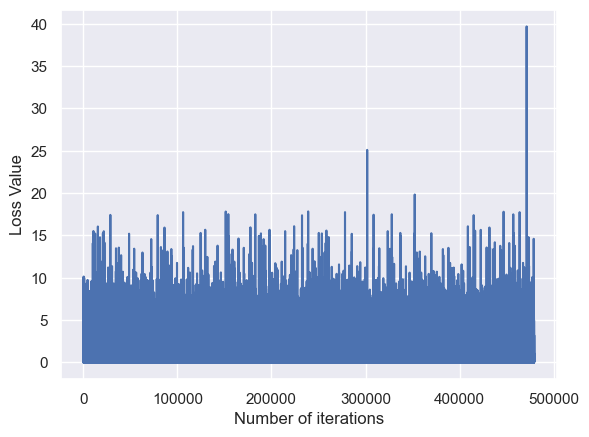

In [286]:
plt.plot(error_list)
plt.xlabel("Number of iterations")
plt.ylabel("Loss Value")
plt.show()

In [288]:
error_list[-2]

1.083423241159957

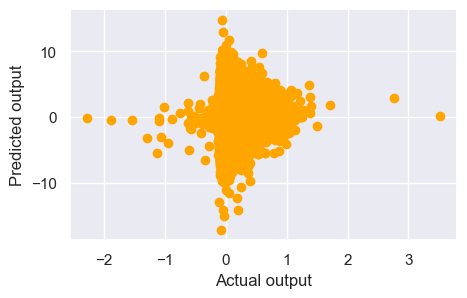

In [289]:
fig = plt.figure(figsize=(5, 3))
# plt.scatter(y, output, label="samples")
plt.scatter(predict(X_test, weight), y_test, label="prediction", color='orange')
plt.xlabel("Actual output")
plt.ylabel("Predicted output")
plt.show()

In [290]:
from sklearn.metrics import mean_squared_error, r2_score
# Evaluate model performance
mse = mean_squared_error(y_test, output)
r2 = r2_score(y_test, output)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R^2) Score: {r2}')

Mean Squared Error (MSE): 2.907812798809771
R-squared (R^2) Score: 0.005219952263580407


In [ ]:
# SGD regression with hyperparam tuning

import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

# Generate some sample data
np.random.seed(0)

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an SGDRegressor model with default hyperparameters
sgd = SGDRegressor()

# Train the model
sgd.fit(X_train, y_train)

# Make predictions on the test set
y_pred = sgd.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Data (Default Hyperparameters):", mse)

# Hyperparameter tuning with grid search
    # 'alpha': [0.0001, 0.001, 0.01, 0.1],
    # 'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    # 'max_iter': [1000, 2000, 3000],
param_grid = {
    'alpha': [0.001],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'max_iter': [1000],
}

# Perform grid search cross-validation to find the best hyperparameters
grid_search = GridSearchCV(SGDRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Extract and print the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the model with the best hyperparameters
best_sgd = SGDRegressor(**best_params)
best_sgd.fit(X_train, y_train)

# Make predictions with the tuned model
y_pred_tuned = best_sgd.predict(X_test)

# Evaluate the tuned model's performance
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
print("Mean Squared Error on Test Data (Tuned Hyperparameters):", mse_tuned)

Mean Squared Error on Test Data (Default Hyperparameters): 1.6487368644622697e+18


/Users/jaspreetsingh/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [ ]:
mse_tuned

## Random forest & LGB

In [42]:
from sklearn.ensemble import RandomForestRegressor

# Create and train a Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, max_depth= 1, min_samples_split = 2, random_state=42)  # You can adjust hyperparameters
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

In [ ]:
plt.plot(y_pred, y_test, label="prediction", color='orange')
plt.xlabel("Actual output")
plt.ylabel("Predicted output")
plt.show()

In [101]:
# random forest with hyperparameter tuning

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create a Random Forest Regressor model
model = RandomForestRegressor(random_state=42)

# Define a hyperparameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 150],  # Adjust the number of trees in the forest
    'max_depth': [None, 10, 20],  # Adjust the maximum depth of the trees
    'min_samples_split': [2, 5, 10]  # Adjust the minimum samples required to split a node
}

# Perform grid search cross-validation to find the best hyperparameters
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the model with the best hyperparameters on the combined training and validation sets
best_model = RandomForestRegressor(random_state=42, **best_params)
best_model.fit(np.vstack((X_train, X_valid)), np.concatenate((y_train, y_valid)))

# Make predictions on the test set using the tuned model
y_pred = best_model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Data:", mse)

In [291]:
# import time
# import lightgbm as lgb

In [307]:
# def train_model(X, X_test, y, params, folds, model_type='lgb', eval_type='regression'):
#     oof = np.zeros(X.shape[0])
#     predictions = np.zeros(X_test.shape[0])
#     scores = []
#     for fold_n, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
#         print('Fold', fold_n, 'started at', time.ctime())
        
#         if model_type == 'lgb':
#             trn_data = lgb.Dataset(X[trn_idx], y[trn_idx])
#             val_data = lgb.Dataset(X[val_idx], y[val_idx])
#             clf = lgb.train(params, trn_data, num_boost_round=20000, 
#                             valid_sets=[trn_data, val_data]
#                             )
#             oof[val_idx] = clf.predict(X[val_idx], num_iteration=clf.best_iteration)
#             predictions += clf.predict(x_test_2, num_iteration=clf.best_iteration) / folds.n_splits
#         print(predictions)

#         if eval_type == 'regression':
#             scores.append(mean_squared_error(oof[val_idx], y[val_idx])**0.5)
#         # print(scores)
        
#     print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
#     return oof, predictions, scores

In [1]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import KFold, StratifiedKFold

# # Create a LightGBM dataset
# train_data = lgb.Dataset(X_train, label=y_train)

# # Define parameters for the model
# # params = {
# #     'objective': 'regression',
# #     'metric': 'rmse',
# #     'boosting_type': 'gbdt',
# #     'num_leaves': 31,
# #     'learning_rate': 0.05,
# #     'feature_fraction': 0.9
# # }

# params = {
#              'num_leaves': 63,
#              'min_data_in_leaf': 32, 
#              'objective':'regression',
#              'max_depth': -1,
#              'learning_rate': 0.01,
#              "min_child_samples": 20,
#              "boosting": "gbdt",
#              "feature_fraction": 0.9,
#              "bagging_freq": 1,
#              "bagging_fraction": 0.9 ,
#              "bagging_seed": 11,
#              "metric": 'rmse',
#              "lambda_l1": 0.1,
#              "verbosity": -1
#          }

# folds = KFold(n_splits=5, shuffle=True, random_state=4096)
# print('='*10,'Regression Models','='*10)
# oof_lgb , predictions_lgb , scores_lgb  = train_model(X_train , X_test, y_train, params=params, folds=folds, model_type='lgb', eval_type='regression')


# # # Train the model
# # num_round = 1000
# # bst = lgb.train(params, train_data, num_round)

# # # Make predictions on the test set
# # y_pred = bst.predict(X_test)

# # # Calculate RMSE
# # rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# # print(f'Root Mean Squared Error: {rmse}')


## xgboost

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

df_training = pd.read_csv('training_df.csv')

In [4]:
## Reference: https://www.kaggle.com/rinnqd/reduce-memory-usage

def reduce_memory_usage(df, verbose=True):
  '''
  This function reduces the memory sizes of dataframe by changing the datatypes of the columns.
  Parameters
  df - DataFrame whose size to be reduced
  verbose - Boolean, to mention the verbose required or not.
  '''
  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  start_mem = df.memory_usage().sum() / 1024**2
  for col in df.columns:
      col_type = df[col].dtypes
      if col_type in numerics:
          c_min = df[col].min()
          c_max = df[col].max()
          if str(col_type)[:3] == 'int':
              if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                  df[col] = df[col].astype(np.int8)
              elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                  df[col] = df[col].astype(np.int16)
              elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                  df[col] = df[col].astype(np.int32)
              elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                  df[col] = df[col].astype(np.int64)
          else:
              c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
              if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                  df[col] = df[col].astype(np.float16)
              elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                  df[col] = df[col].astype(np.float32)
              else:
                  df[col] = df[col].astype(np.float64)
  end_mem = df.memory_usage().sum() / 1024**2
  if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
  return df

In [5]:
df_training = reduce_memory_usage(df_training)
df_training

Mem. usage decreased to 51.80 Mb (19.5% reduction)


card_id    target  earliest_txn_rel_mth  latest_txn_rel_mth  \
0       C_ID_00007093c1  0.134077                   -12                   2   
1       C_ID_0001506ef0  0.884295                   -13                   1   
2       C_ID_000183fdda -0.264433                    -6                   2   
3       C_ID_00027503e2  0.812872                    -8                   0   
4       C_ID_0002c7c2c1  1.288514                    -9                   2   
...                 ...       ...                   ...                 ...   
199705  C_ID_fffeced303  0.362965                   -10                   2   
199706  C_ID_fffeed3a89 -0.085357                    -3                   2   
199707  C_ID_ffff579d3a  1.530061                    -6                   1   
199708  C_ID_ffff828181 -0.600063                   -13                   2   
199709  C_ID_fffffd5772 -1.073077                    -6                   1   

        total_months_active  totalTxns  purchase_avg_amt  total_purchase_amt  \
0                        14        116         -0.545283          -63.771600   
1                        14         64         -0.466447          -33.143451   
2                         8        148         -0.508442          -74.487336   
3                         9         24         -0.740077          -17.774786   
4                        12         64         -0.652514          -42.059372   
...                     ...        ...               ...                 ...   
199705                   13        168         -0.689561         -115.535003   
199706                    6        216         -0.142808         -118.342586   
199707                    8        100         -0.696361          -70.342994   
199708                   16        174         -0.624684         -109.572723   
199709                    8         78         -0.691538          -53.534743   

        success_txn_rate  avg_installments  category_1  category_2  \
0                    1.0          1.343242   -0.619029    2.385687   
1                    1.0          0.000000   -1.000000    2.983193   
2                    1.0          1.652249   -0.943376    2.814876   
3                    1.0          0.000000   -1.000000    2.777778   
4                    1.0          0.000000   -1.000000    1.000000   
...                  ...               ...         ...         ...   
199705               1.0          1.120059    0.221827    0.389087   
199706               1.0          1.362286   -0.565534    3.122166   
199707               1.0          0.000000   -1.000000    1.033333   
199708               1.0          1.196385   -0.948786    1.973442   
199709               1.0          1.024012   -0.500068    2.015253   

        category_3  total_merchants  newMerchantsCount  \
0         1.822943               72                  2   
1         3.000000               51                  1   
2         1.639456              118                 11   
3         3.000000               19                  0   
4         3.000000               61                  6   
...            ...              ...                ...   
199705    1.949198               71                  2   
199706    1.804842              177                 51   
199707    3.000000               78                  1   
199708    1.855252              142                  8   
199709    1.942133               46                  3   

        purchase_ratio_Latest_Earliest sum  \
0                                13.938201   
1                                14.298075   
2                                 0.850857   
3                                 8.945240   
4                                41.381017   
...                                    ...   
199705                            1.600746   
199706                          -12.445830   
199707                            0.357010   
199708                            6.041954   
199709                           23.195802   

        purchas

In [26]:
# Split data into X (features) and y (target)
X = df_training.drop(['target','card_id'], axis=1)
y = df_training['target']


In [27]:
# from sklearn.decomposition import PCA
# # Create a PCA instance with the desired number of components (e.g., 3)
# n_components = 5
# pca = PCA(n_components=n_components)
# X_reduced = pca.fit_transform(X)
# X_reduced

In [28]:
# X_reduced_df = pd.DataFrame(X_reduced)
# X_reduced_df

In [29]:
param = {
    'objective': 'reg:squarederror', 
    'eval_metric': 'rmse', 
    'booster': 'gbtree', 
    'n_jobs': 4, 
    'n_estimators': 2500, 
    #'tree_method': 'gpu_hist', 
    'grow_policy': 'lossguide', 
    'max_depth': 12, 
    'seed': 538, 
    'colsample_bylevel': 0.9, 
    'colsample_bytree': 0.8, 
    'gamma': 0.0001, 
    'learning_rate': 0.006, 
    'max_bin': 128, 
    'max_leaves': 47, 
    'min_child_weight': 40, 
    'reg_alpha': 10.0, 
    'reg_lambda': 10.0, 
    'subsample': 0.9}

In [30]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.4, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
#xgb
from sklearn.model_selection import KFold, StratifiedKFold
import time
import xgboost as xgb  # Import the xgboost library
import gc  # Import the gc module
from sklearn.metrics import mean_squared_error

folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(X_train2))
predictions = np.zeros(len(X_test))
start = time.time()
feature_importance_df = pd.DataFrame()
oof_preds = np.zeros(len(X_train2))
clfs = list()

# Iterate through each fold
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train2, y_train2)):
    print("=======fold {}=======".format(fold_))
    
    # Split the data into training and validation sets
    X_train, y_train = X_train2.iloc[trn_idx], y_train2.iloc[trn_idx]
    X_valid, y_valid = X_train2.iloc[val_idx], y_train2.iloc[val_idx]
    
    model = xgb.XGBRegressor(**param)
    model.fit(
        X_train, y_train,
        # eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_set=[(X_valid, y_valid)],
        verbose=1000, 
        #eval_metric='rmse',
        # early_stopping_rounds=500,
    )
    
    model.save_model(f'xsg_reg_fold{fold_}.json')
    clfs.append(model)
    oof_preds[val_idx] = model.predict(X_valid)
    
    del X_train, y_train, X_valid, y_valid
    gc.collect()
    
    predictions += model.predict(X_test) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(predictions, y_test)**0.5))

=======fold 0=======
[0]	validation_0-rmse:1.71251
[1000]	validation_0-rmse:1.59430
[2000]	validation_0-rmse:1.59113
[2499]	validation_0-rmse:1.59069
=======fold 1=======
[0]	validation_0-rmse:1.70518
[1000]	validation_0-rmse:1.58736
[2000]	validation_0-rmse:1.58393
[2499]	validation_0-rmse:1.58361
=======fold 2=======
[0]	validation_0-rmse:1.72316
[1000]	validation_0-rmse:1.60286
[2000]	validation_0-rmse:1.59959
[2499]	validation_0-rmse:1.59930
=======fold 3=======
[0]	validation_0-rmse:1.71950
[1000]	validation_0-rmse:1.60878
[2000]	validation_0-rmse:1.60606
[2499]	validation_0-rmse:1.60595
=======fold 4=======
[0]	validation_0-rmse:1.73167
[1000]	validation_0-rmse:1.61268
[2000]	validation_0-rmse:1.60866
[2499]	validation_0-rmse:1.60842
CV score: 1.58822 


In [37]:
predictions.shape

(39942,)

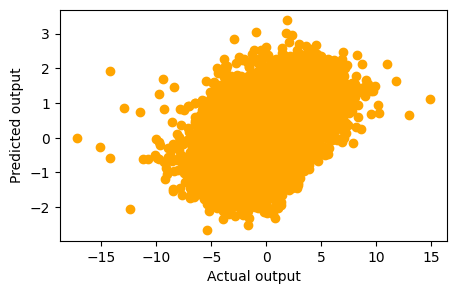

In [32]:
fig = plt.figure(figsize=(5, 3))
# plt.scatter(y, output, label="samples")
plt.scatter(y_test, predictions, label="prediction", color='orange')
plt.xlabel("Actual output")
plt.ylabel("Predicted output")
plt.show()

In [34]:
from sklearn.metrics import mean_squared_error, r2_score
# Evaluate model performance
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R^2) Score: {r2}')

Mean Squared Error (MSE): 2.5224549049395564
R-squared (R^2) Score: 0.13705317901625513


## Correlations

In [ ]:
num_cols_card = df_trained.select_dtypes(include=['float64', 'int64']).columns.tolist()
num_cols_card

In [417]:
spearman_correlation_matrix = df_monthly_cards_with_merchant_features[num_cols_card].corr(method='spearman')
spearman_correlation_matrix

target  feature_1  feature_2  \
target                                    1.000000  -0.015664  -0.009393   
feature_1                                -0.015664   1.000000  -0.091578   
feature_2                                -0.009393  -0.091578   1.000000   
feature_3                                -0.012205   0.633228   0.054647   
earliest_txn_rel_mth                     -0.025589  -0.097615  -0.095780   
latest_txn_rel_mth                       -0.139556  -0.021624  -0.024241   
total_months_active                      -0.038509   0.072334   0.043570   
totalTxns                                -0.081907   0.013600  -0.002088   
purchase_avg_amt                         -0.023412   0.131607  -0.146465   
total_purchase_amt                        0.069121   0.043234  -0.055053   
success_txn_rate                         -0.014249  -0.074212  -0.037150   
avg_installments                          0.011293  -0.002845  -0.241666   
category_1                               -0.002768  -0.024040  -0.210309   
category_2                               -0.000046   0.002501   0.151788   
category_3                               -0.011133   0.011386   0.235585   
total_merchants                          -0.085493   0.012664   0.002253   
newMerchantsCount                        -0.240092  -0.029677  -0.041553   
totalTxnsByMerchant_weighted_avg         -0.027127   0.024480   0.004455   
numerical_1_weighted_avg                 -0.025893  -0.033163  -0.042066   
numerical_2_weighted_avg                 -0.026595  -0.031700  -0.041791   
most_recent_sales_range_weighted_avg     -0.005218   0.027334   0.083125   
most_recent_purchases_range_weighted_avg -0.002879   0.064612   0.050745   
avg_sales_lag3_weighted_avg              -0.019251  -0.027943   0.015173   
avg_purchases_lag3_weighted_avg          -0.018179  -0.032834   0.004011   
active_months_lag3_weighted_avg           0.011970   0.003220   0.005021   
avg_sales_lag6_weighted_avg              -0.029807  -0.033870  -0.007701   
avg_purchases_lag6_weighted_avg          -0.031748  -0.036684  -0.019093   
active_months_lag6_weighted_avg           0.026094  -0.000696  -0.000628   
avg_sales_lag12_weighted_avg             -0.030224  -0.033858  -0.002649   
avg_purchases_lag12_weighted_avg         -0.031962  -0.035862  -0.016168   
active_months_lag12_weighted_avg          0.037945   0.009211   0.029768   
category_1_weighted_avg                   0.001533  -0.033403  -0.163764   
category_2_weighted_avg                   0.001205   0.009667   0.152898   
category_4_weighted_avg                   0.002114  -0.023948  -0.051425   
totalTxnsByMerchant                      -0.081819   0.014094  -0.001752   

                                          feature_3  earliest_txn_rel_mth  \
target                                    -0.012205             -0.025589   
feature_1                                  0.633228             -0.097615   
feature_2                                  0.054647             -0.095780   
feature_3                                  1.000000             -0.110112   
earliest_txn_rel_mth                      -0.110112              1.000000   
latest_txn_rel_mth                        -0.038434              0.116884   
total_months_active                        0.065185             -0.864606   
totalTxns                                 -0.009553             -0.333371   
purchase_avg_amt                          -0.189243              0.003551   
total_purchase_amt                        -0.019014              0.281162   
success_txn_rate                          -0.177396              0.130842   
avg_installments                          -0.274750              0.054472   
category_1                                -0.209049              0.029257   
category_2                                 0.071555             -0.017925   
category_3                                 0.275117             -0.085050   
total_merchants                           -0.024821             -0.346747  

In [418]:
df_monthly_cards_with_merchant_features[num_cols_card].describe()

target      feature_1      feature_2      feature_3  \
count  201917.000000  201917.000000  201917.000000  201917.000000   
mean       -0.393636       3.105311       1.745410       0.565569   
std         3.850500       1.186160       0.751362       0.495683   
min       -33.219281       1.000000       1.000000       0.000000   
25%        -0.883110       2.000000       1.000000       0.000000   
50%        -0.023437       3.000000       2.000000       1.000000   
75%         0.765453       4.000000       2.000000       1.000000   
max        17.965068       5.000000       3.000000       1.000000   

       earliest_txn_rel_mth  latest_txn_rel_mth  total_months_active  \
count         201917.000000       201917.000000        201917.000000   
mean              -7.877777            1.591015             9.345850   
std                3.843313            0.778242             3.607394   
min              -13.000000          -11.000000             2.000000   
25%              -12.000000            1.000000             6.000000   
50%               -8.000000            2.000000             9.000000   
75%               -4.000000            2.000000            12.000000   
max               -1.000000            2.000000            16.000000   

           totalTxns  purchase_avg_amt  total_purchase_amt  success_txn_rate  \
count  201917.000000     201917.000000        2.019170e+05     201917.000000   
mean       95.334687          2.819271        1.109021e+01          0.917038   
std       106.910822       1337.806054        1.344916e+04          0.090314   
min         2.000000         -0.745373       -2.089630e+03          0.099416   
25%        31.000000         -0.676208       -7.014302e+01          0.881818   
50%        60.000000         -0.612985       -3.368618e+01          0.944444   
75%       118.000000         -0.482645       -1.471600e+01          0.981481   
max      2915.000000     601059.762323        6.010591e+06          1.000000   

       avg_installments     category_1     category_2     category_3  \
count     201917.000000  201917.000000  201917.000000  201917.000000   
mean           0.865169      -0.801313       1.932117       2.322494   
std            1.122650       0.399416       1.356374       0.651240   
min           -0.666667      -1.000000       0.000000       0.200000   
25%            0.001202      -1.000000       0.993333       1.775510   
50%            0.993939      -1.000000       1.083472       2.000000   
75%            1.376543      -0.800000       2.919281       2.998397   
max          126.166667       1.000000       5.000000       3.000000   

       total_merchants  newMerchantsCount  totalTxnsByMerchant_weighted_avg  \
count    201917.000000      201917.000000                     201917.000000   
mean         62.929124           5.957448                          7.692288   
std          62.431601           6.613994                         14.861991   
min           2.000000           0.000000                          1.000000   
25%          23.000000           2.000000                          2.333333   
50%          43.000000           4.000000                          4.117241   
75%          80.000000           8.000000                          8.045752   
max         945.000000         109.000000                       2144.730290   

       numerical_1_weighted_avg  numerical_2_weighted_avg  \
count             201917.000000             201917.000000   
mean                   4.739772                  4.629641   
std                    8.009244                  7.895121   
min                   -0.057471                 -0.057471   
25%                    0.398615                  0.364054   
50%                    1.603563                  1.539982   
75%                    5.370789                  5.242046   
max                  158.077367                156.654916   

       most_recent_sales_range_weighted_avg  \
count                         201917.000000   
mean             

In [419]:
df_monthly_cards_with_merchant_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 39 columns):
 #   Column                                    Non-Null Count   Dtype          
---  ------                                    --------------   -----          
 0   card_id                                   201917 non-null  object         
 1   target                                    201917 non-null  float64        
 2   feature_1                                 201917 non-null  int64          
 3   feature_2                                 201917 non-null  int64          
 4   feature_3                                 201917 non-null  int64          
 5   earliest_txn_rel_mth                      201917 non-null  int64          
 6   latest_txn_rel_mth                        201917 non-null  int64          
 7   latest_purchase_date                      201917 non-null  object         
 8   total_months_active                       201917 non-null  int64          
 9   tota

In [420]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_values = []

# Iterate through each feature column
for i in range(df_monthly_cards_with_merchant_features[num_cols_card].shape[1]):
    # Calculate VIF for the current feature
    vif = variance_inflation_factor(df_monthly_cards_with_merchant_features[num_cols_card].values, i)
    # Append the VIF value to the list
    vif_values.append({'Feature': df_monthly_cards_with_merchant_features[num_cols_card].columns[i], 'VIF': vif})

# Create a DataFrame of VIF values
vif_df = pd.DataFrame(vif_values)
vif_df

Feature            VIF
0                                     target       1.019951
1                                  feature_1      13.523456
2                                  feature_2       7.043521
3                                  feature_3       4.307867
4                       earliest_txn_rel_mth      26.995708
5                         latest_txn_rel_mth       7.438330
6                        total_months_active      49.195281
7                                  totalTxns   14563.499323
8                           purchase_avg_amt     113.226632
9                         total_purchase_amt     113.227712
10                          success_txn_rate     115.914508
11                          avg_installments       4.275115
12                                category_1      33.637649
13                                category_2      39.919549
14                                category_3      41.227596
15                           total_merchants      49.448352
16                         newMerchantsCount       3.231062
17          totalTxnsByMerchant_weighted_avg       3.473140
18                  numerical_1_weighted_avg    5517.859505
19                  numerical_2_weighted_avg    5466.059039
20      most_recent_sales_range_weighted_avg     212.191387
21  most_recent_purchases_range_weighted_avg     200.891507
22               avg_sales_lag3_weighted_avg   11434.921778
23           avg_purchases_lag3_weighted_avg    2264.134876
24           active_months_lag3_weighted_avg  232324.938748
25               avg_sales_lag6_weighted_avg   16626.397262
26           avg_purchases_lag6_weighted_avg    2437.464940
27           active_months_lag6_weighted_avg  269448.637512
28              avg_sales_lag12_weighted_avg    4120.659321
29          avg_purchases_lag12_weighted_avg    1001.267228
30          active_months_lag12_weighted_avg   12970.476248
31                   category_1_weighted_avg      23.542135
32                   category_2_weighted_avg      38.486029
33                   category_4_weighted_avg       1.553141
34                       totalTxnsByMerchant   14544.421203

### we will not be able to use Linear Regression since there are high VIFs

### in df_monthly_cards

START HERE

In [206]:
df_monthly_cards.head(2)

card_id    target  feature_1  feature_2  feature_3  \
0  C_ID_00007093c1  0.134077          5          1          1   
1  C_ID_0001506ef0  0.884295          2          2          0   

   earliest_txn_rel_mth  latest_txn_rel_mth latest_purchase_date  \
0                   -12                   2              2018-04   
1                   -13                   1              2018-03   

   total_months_active  totalTxns  purchase_avg_amt  total_purchase_amt  \
0                   14        151         -0.519112          -78.173565   
1                   14         68         -0.480458          -36.049233   

   success_txn_rate  avg_installments  category_1  category_2  category_3  \
0          0.796211          1.323588   -0.646167    2.421631    1.827864   
1          0.948413          0.011905   -1.000000    2.984127    2.988095   

   total_merchants  newMerchantsCount  
0               76                  2  
1               51                  1

In [178]:
df_monthly_cards.describe()

target      feature_1      feature_2      feature_3  \
count  201917.000000  201917.000000  201917.000000  201917.000000   
mean       -0.393636       3.105311       1.745410       0.565569   
std         3.850500       1.186160       0.751362       0.495683   
min       -33.219281       1.000000       1.000000       0.000000   
25%        -0.883110       2.000000       1.000000       0.000000   
50%        -0.023437       3.000000       2.000000       1.000000   
75%         0.765453       4.000000       2.000000       1.000000   
max        17.965068       5.000000       3.000000       1.000000   

       earliest_txn_rel_mth  latest_txn_rel_mth  total_months_active  \
count         201917.000000       201917.000000        201917.000000   
mean              -7.877777            1.591015             9.345850   
std                3.843313            0.778242             3.607394   
min              -13.000000          -11.000000             2.000000   
25%              -12.000000            1.000000             6.000000   
50%               -8.000000            2.000000             9.000000   
75%               -4.000000            2.000000            12.000000   
max               -1.000000            2.000000            16.000000   

           totalTxns  purchase_avg_amt  total_purchase_amt  success_txn_rate  \
count  201917.000000     201917.000000        2.019170e+05     201917.000000   
mean       95.334687          2.819271        1.109021e+01          0.917038   
std       106.910822       1337.806054        1.344916e+04          0.090314   
min         2.000000         -0.745373       -2.089630e+03          0.099416   
25%        31.000000         -0.676208       -7.014302e+01          0.881818   
50%        60.000000         -0.612985       -3.368618e+01          0.944444   
75%       118.000000         -0.482645       -1.471600e+01          0.981481   
max      2915.000000     601059.762323        6.010591e+06          1.000000   

       avg_installments     category_1     category_2     category_3  \
count     201917.000000  201917.000000  201917.000000  201917.000000   
mean           0.865169      -0.801313       1.932117       2.322494   
std            1.122650       0.399416       1.356374       0.651240   
min           -0.666667      -1.000000       0.000000       0.200000   
25%            0.001202      -1.000000       0.993333       1.775510   
50%            0.993939      -1.000000       1.083472       2.000000   
75%            1.376543      -0.800000       2.919281       2.998397   
max          126.166667       1.000000       5.000000       3.000000   

       total_merchants  newMerchantsCount  
count    201917.000000      201917.000000  
mean         62.929124           5.957448  
std          62.431601           6.613994  
min           2.000000           0.000000  
25%          23.000000           2.000000  
50%          43.000000           4.000000  
75%          80.000000           8.000000  
max         945.000000         109.000000

In [ ]:
# lets do outlier treatment first now


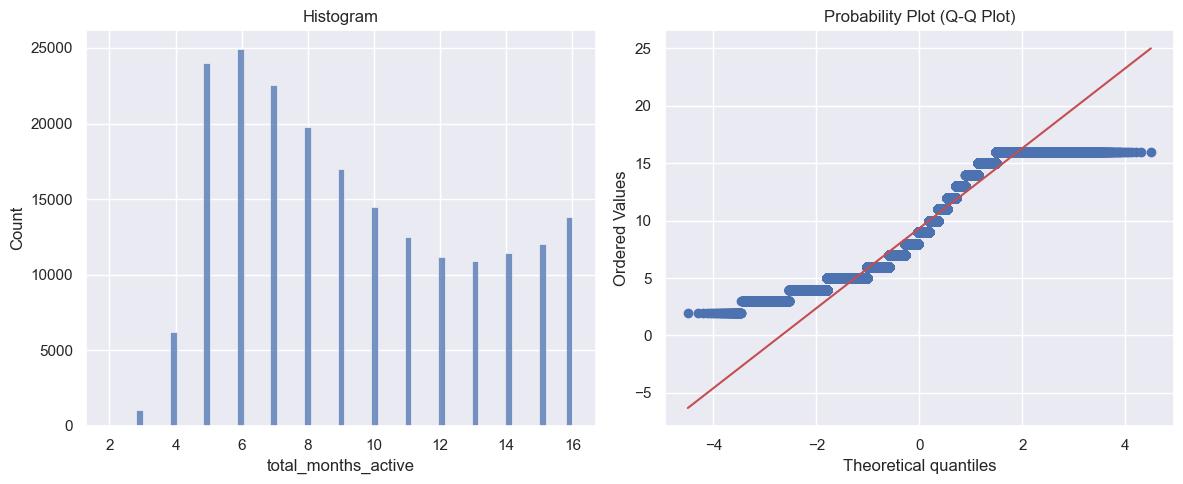

In [209]:
# try seeing for total_active_months?
# Create a histogram to visualize the data's distribution using Seaborn
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_monthly_cards["total_months_active"], label='total_months_active Histogram')
plt.title('Histogram')

# Create a probability plot (Q-Q plot) to assess normality
plt.subplot(1, 2, 2)
stats.probplot(df_monthly_cards["total_months_active"], dist="norm", plot=plt)
plt.title('Probability Plot (Q-Q Plot)')

plt.tight_layout()
plt.show()

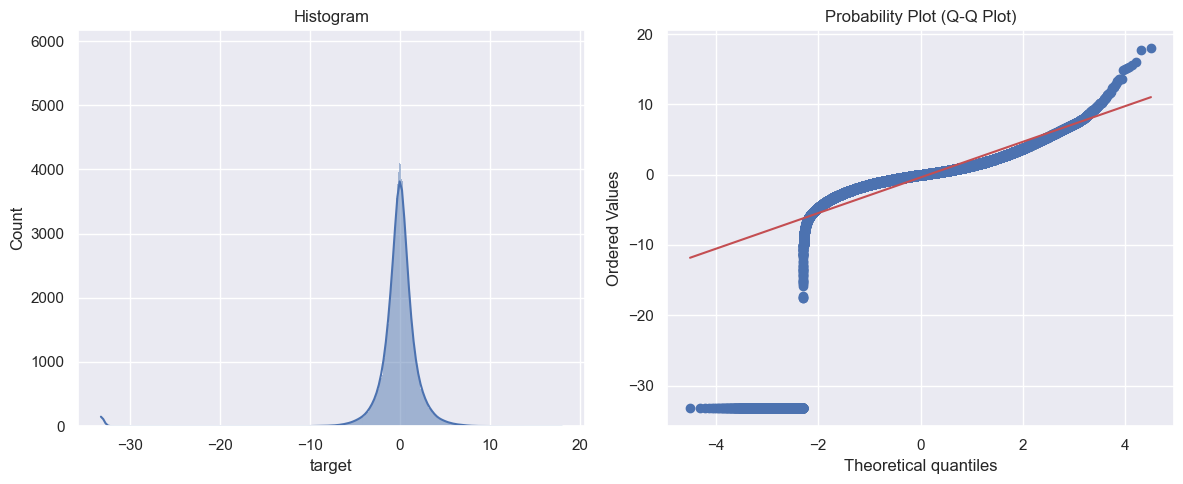

In [179]:
# Create a histogram to visualize the data's distribution using Seaborn
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_monthly_cards["target"], kde=True, label='target Histogram')
    # sns.histplot(data=df_monthly_cards_sample, x=col, bins='auto', kde=True)

plt.title('Histogram')

# Create a probability plot (Q-Q plot) to assess normality
plt.subplot(1, 2, 2)
stats.probplot(df_monthly_cards["target"], dist="norm", plot=plt)
plt.title('Probability Plot (Q-Q Plot)')

plt.tight_layout()
plt.show()

In [180]:
num_cols_card

['target',
 'feature_1',
 'feature_2',
 'feature_3',
 'earliest_txn_rel_mth',
 'latest_txn_rel_mth',
 'total_months_active',
 'totalTxns',
 'purchase_avg_amt',
 'total_purchase_amt',
 'success_txn_rate',
 'avg_installments',
 'category_1',
 'category_2',
 'category_3',
 'total_merchants',
 'newMerchantsCount']

In [204]:
df_monthly_cards_sample = df_monthly_cards.sample(n=10000, random_state=42) 
df_monthly_cards_sample

card_id    target  feature_1  feature_2  feature_3  \
165789  C_ID_d283f2abc9 -0.817388          2          2          0   
43663   C_ID_371d96ed66  0.369384          3          3          1   
201089  C_ID_fefbf68b31  1.504851          4          1          0   
107580  C_ID_8870741f85  3.923166          2          2          0   
163887  C_ID_d01619a3d9  1.389753          3          1          1   
...                 ...       ...        ...        ...        ...   
146846  C_ID_ba3fdffc5a -0.361761          2          2          0   
75636   C_ID_5fb3b3345d -2.726986          3          2          1   
177635  C_ID_e175fb0f35 -0.308683          3          1          1   
23669   C_ID_1df4277536  4.318296          1          3          0   
26856   C_ID_21fb634e23  0.787410          5          2          1   

        earliest_txn_rel_mth  latest_txn_rel_mth latest_purchase_date  \
165789                    -6                   2              2018-04   
43663                     -6                   2              2017-09   
201089                    -8                   1              2017-10   
107580                   -11                   0              2018-02   
163887                    -3                   2              2018-04   
...                      ...                 ...                  ...   
146846                   -12                   2              2018-04   
75636                    -12                   2              2018-04   
177635                    -8                   2              2018-04   
23669                     -8                   1              2017-10   
26856                     -8                   1              2017-10   

        total_months_active  totalTxns  purchase_avg_amt  total_purchase_amt  \
165789                    6         39         -0.636084          -24.566889   
43663                     9        172         -0.720217         -123.905581   
201089                    9         99         -0.315063          -29.448883   
107580                   10        220         -0.631284         -141.084460   
163887                    6         21         -0.692543          -14.510607   
...                     ...        ...               ...                 ...   
146846                   11         30         -0.640425          -18.324035   
75636                    12         89         -0.657463          -59.434617   
177635                   11        204         -0.474967         -106.836936   
23669                     9         48         -0.559725          -21.128463   
26856                    10         56         -0.435686          -24.737049   

        success_txn_rate  avg_installments  category_1  category_2  \
165789          0.966667          0.000000   -1.000000    1.663889   
43663           0.947288          0.000000   -1.000000    1.000000   
201089          0.884921          1.000000   -1.000000    1.000000   
107580          0.858817          0.105461   -1.000000    2.972640   
163887          0.905556          0.066667   -1.000000    3.033333   
...                  ...               ...         ...         ...   
146846          0.875000          0.000000   -1.000000    1.000000   
75636           0.943510          0.021164   -1.000000    1.000000   
177635          0.989610          1.548440   -0.838457    0.919229   
23669           0.888889          1.705556   -0.938889    2.652778   
26856           0.962500          0.012500   -1.000000    4.000000   

        category_3  total_merchants  newMerchantsCount  
165789    3.000000               31                  2  
43663     3.000000              113                 19  
201089    2.000000               40                  1  
107580    2.894539              133                  0  
163887    2.933333               15                  2  
...            ...              ...                ...  
146846    3.000000               28                  5  
75636     2.978836               74     

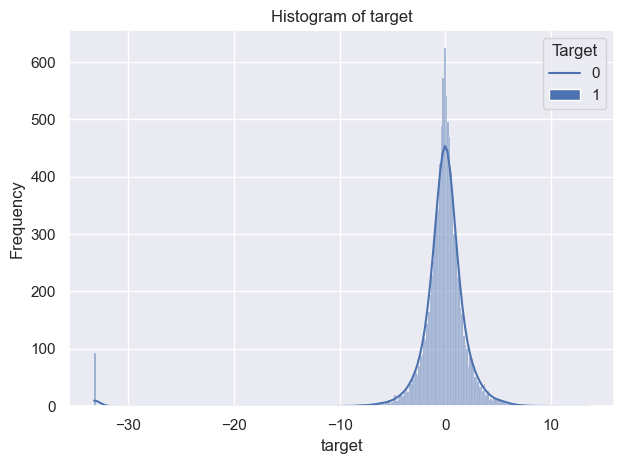

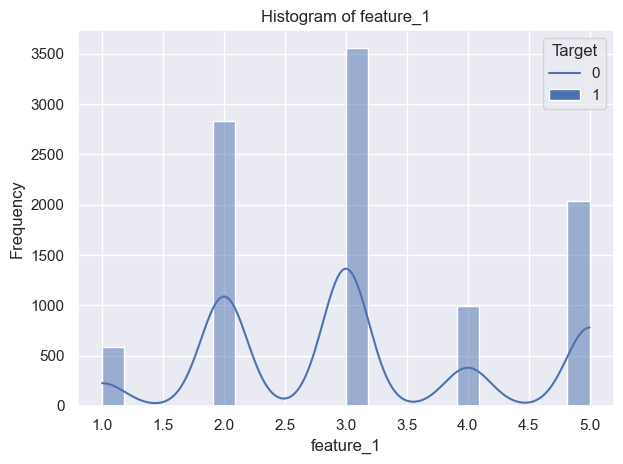

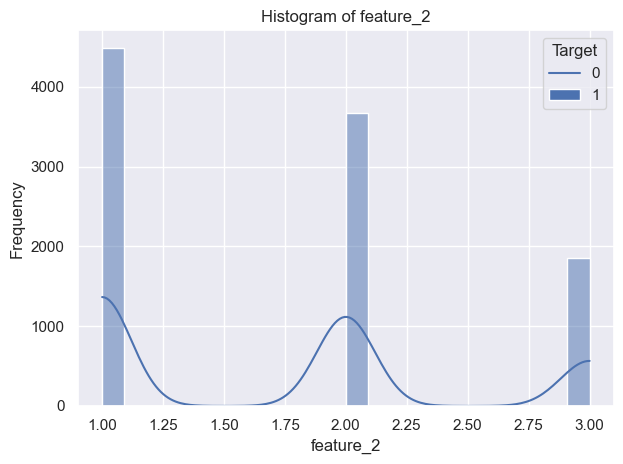

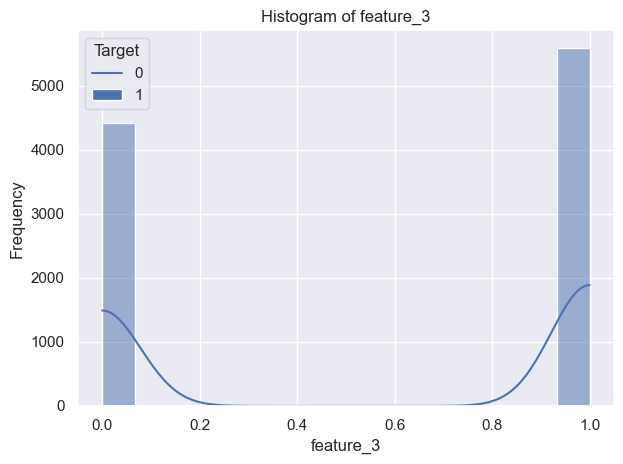

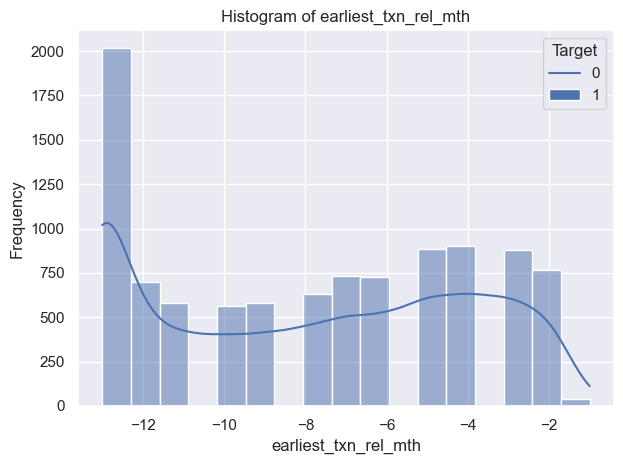

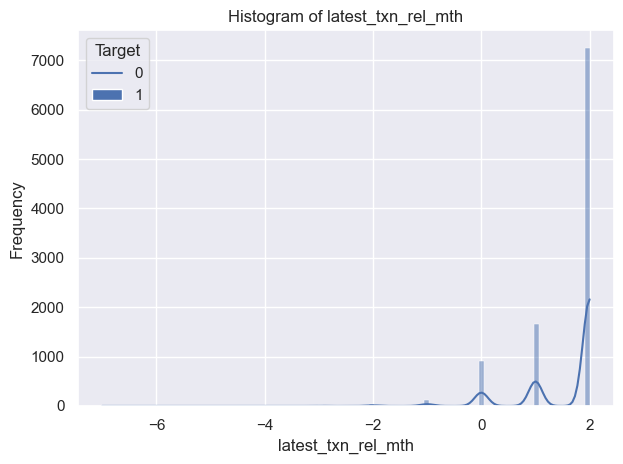

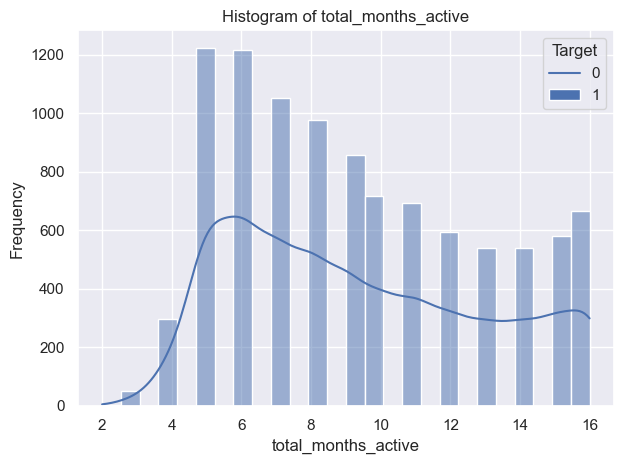

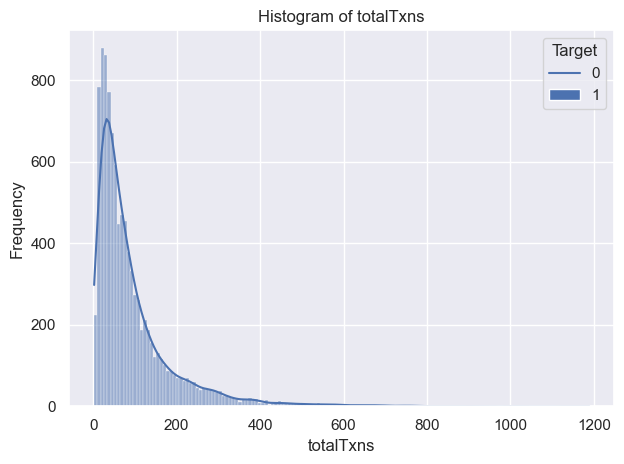

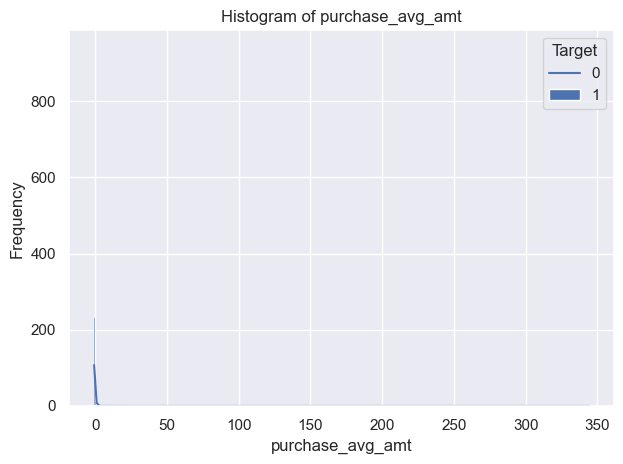

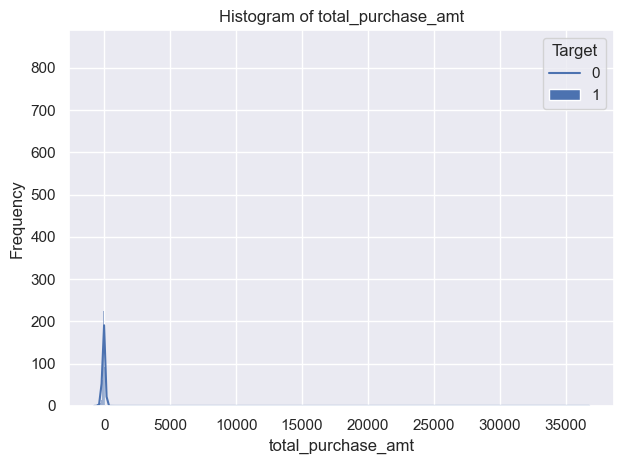

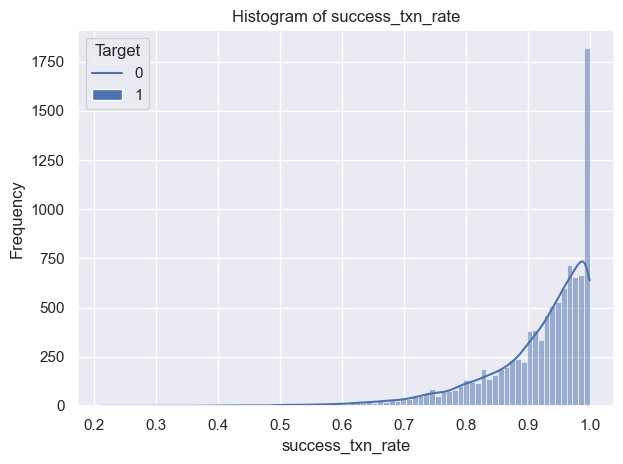

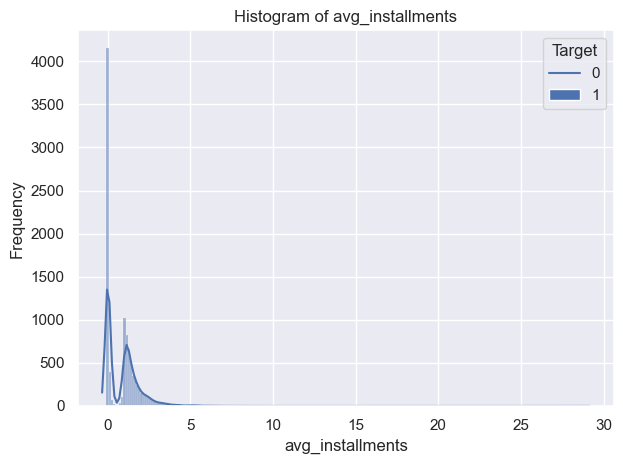

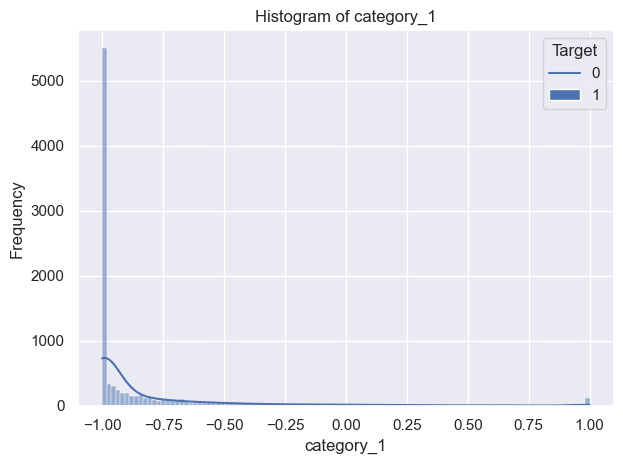

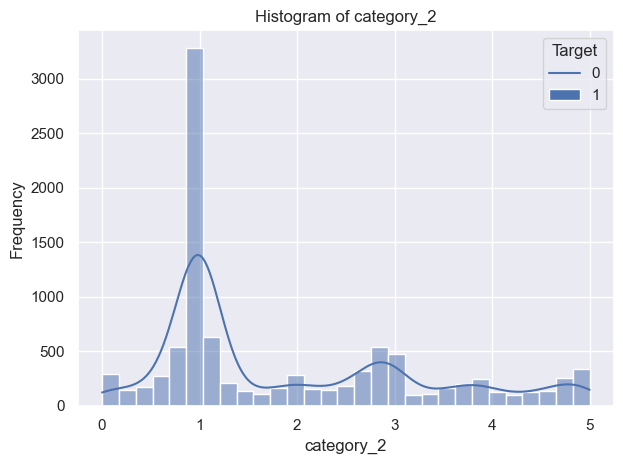

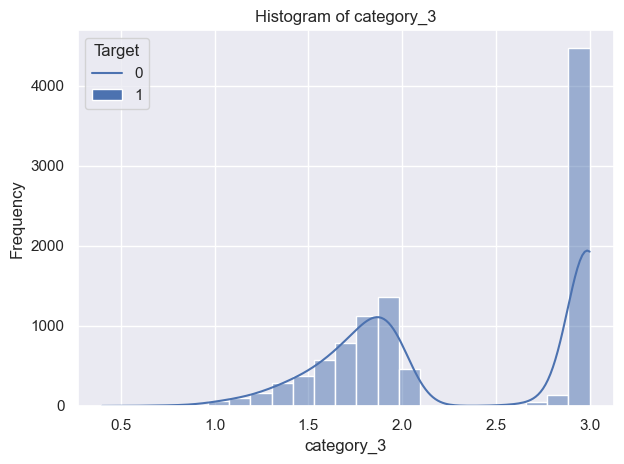

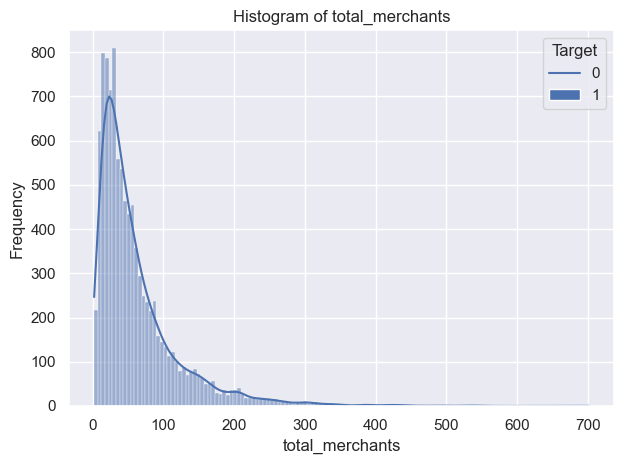

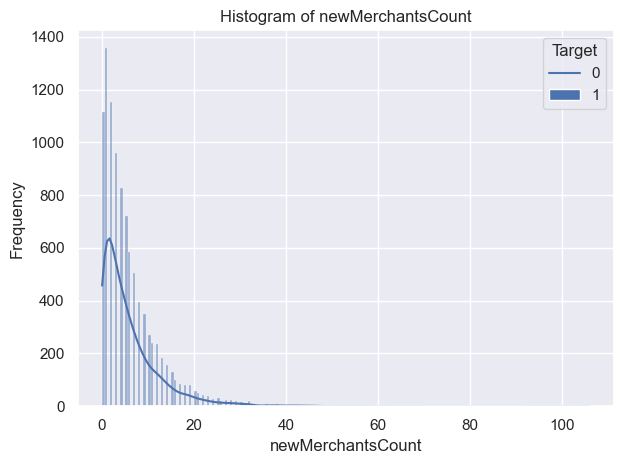

In [205]:
# Create histograms for numeric feature columns
for col in num_cols_card:
    sns.histplot(data=df_monthly_cards_sample, x=col, bins='auto', kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend(title='Target', labels=['0', '1'])
    
    plt.tight_layout()
    plt.show()

## Merchants 

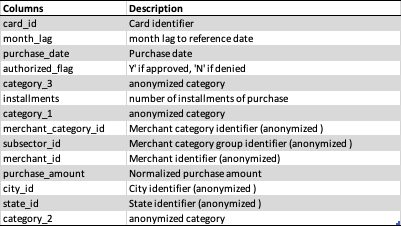mized category

In [5]:
df_merchants

NameError: name 'df_merchants' is not defined

In [478]:
df_merchants.describe()

merchant_group_id  merchant_category_id   subsector_id    numerical_1  \
count      334696.000000         334696.000000  334696.000000  334696.000000   
mean        31028.736143            423.131663      25.116404       0.011476   
std         31623.043426            252.898046       9.807371       1.098154   
min             1.000000             -1.000000      -1.000000      -0.057471   
25%          3612.000000            222.000000      19.000000      -0.057471   
50%         19900.000000            373.000000      27.000000      -0.057471   
75%         51707.250000            683.000000      33.000000      -0.047556   
max        112586.000000            891.000000      41.000000     183.735111   

         numerical_2  avg_sales_lag3  avg_purchases_lag3  active_months_lag3  \
count  334696.000000   334683.000000        3.346960e+05       334696.000000   
mean        0.008103       13.832993                 inf            2.994108   
std         1.070497     2395.489999                 NaN            0.095247   
min        -0.057471      -82.130000        3.334953e-01            1.000000   
25%        -0.057471        0.880000        9.236499e-01            3.000000   
50%        -0.057471        1.000000        1.016667e+00            3.000000   
75%        -0.047556        1.160000        1.146522e+00            3.000000   
max       182.079322   851844.640000                 inf            3.000000   

       avg_sales_lag6  avg_purchases_lag6  active_months_lag6  \
count    3.346830e+05        3.346960e+05       334696.000000   
mean     2.165079e+01                 inf            5.947397   
std      3.947108e+03                 NaN            0.394936   
min     -8.213000e+01        1.670447e-01            1.000000   
25%      8.500000e-01        9.022475e-01            6.000000   
50%      1.010000e+00        1.026961e+00            6.000000   
75%      1.230000e+00        1.215575e+00            6.000000   
max      1.513959e+06                 inf            6.000000   

       avg_sales_lag12  avg_purchases_lag12  active_months_lag12  \
count     3.346830e+05         3.346960e+05        334696.000000   
mean      2.522771e+01                  inf            11.599335   
std       5.251842e+03                  NaN             1.520138   
min      -8.213000e+01         9.832954e-02             1.000000   
25%       8.500000e-01         8.983333e-01            12.000000   
50%       1.020000e+00         1.043361e+00            12.000000   
75%       1.290000e+00         1.266480e+00            12.000000   
max       2.567408e+06                  inf            12.000000   

             city_id       state_id     category_2  
count  334696.000000  334696.000000  322809.000000  
mean      102.917926      11.860942       2.380002  
std       107.090673       6.176889       1.562661  
min        -1.000000      -1.000000       1.000000  
25%        -1.000000       9.000000       1.000000  
50%        69.000000       9.000000       2.000000  
75%       182.000000      16.000000       4.000000  
max       347.000000      24.000000       5.000000

In [477]:
df_merchant_t1 = df_merchants[df_merchants["merchant_id"]== "M_ID_b0c793002c"]
df_merchant_t1
# this is new merchant for 1 of the card_id (C_ID_415bb3a509)

merchant_id  merchant_group_id  merchant_category_id  \
326050  M_ID_b0c793002c              71460                   307   

        subsector_id  numerical_1  numerical_2 category_1  \
326050            19    -0.047556    -0.047556          N   

       most_recent_sales_range most_recent_purchases_range  avg_sales_lag3  \
326050                       C                           C            0.84   

        avg_purchases_lag3  active_months_lag3  avg_sales_lag6  \
326050            1.055253                   3            0.82   

        avg_purchases_lag6  active_months_lag6  avg_sales_lag12  \
326050            1.158625                   6             0.81   

        avg_purchases_lag12  active_months_lag12 category_4  city_id  \
326050             1.235863                   12          N       -1   

        state_id  category_2  
326050         9         1.0

In [ ]:
# we may use merchants dataset to find which merchant brings more card txns historically and for new merchants may bring in more?

## New merchants
#### new_merchant_transactions.csv contains the transactions at new merchants (merchant_ids that this particular card_id has not yet visited) over a period of two months.
### CONCLUSION for df_new_merchants:
### after the given max purchase date of card_id in df_history, new_merchant_transactions.csv contains txns of that card_id for next 2 months with different merchants (these merchants were also present in df_history JUST not for that card_id)
### that means for last 2 months old_merchants data will be missing (if any)

In [420]:
# df_new_merchants = pd.read_csv('new_merchant_transactions.csv')
# df_new_merchants['purchase_date'] = pd.to_datetime(df_new_merchants['purchase_date'])
df_new_merchants

authorized_flag          card_id  city_id category_1  installments  \
0                     Y  C_ID_415bb3a509      107          N             1   
1                     Y  C_ID_415bb3a509      140          N             1   
2                     Y  C_ID_415bb3a509      330          N             1   
3                     Y  C_ID_415bb3a509       -1          Y             1   
4                     Y  C_ID_ef55cf8d4b       -1          Y             1   
...                 ...              ...      ...        ...           ...   
1963026               Y  C_ID_1320dee851      142          N             0   
1963027               Y  C_ID_f112aa3381      158          N             0   
1963028               Y  C_ID_bd97b86450       69          N             1   
1963029               Y  C_ID_c0513fd84f      130          N             0   
1963030               Y  C_ID_a935410f8e       19          N             0   

        category_3  merchant_category_id      merchant_id  month_lag  \
0                B                   307  M_ID_b0c793002c          1   
1                B                   307  M_ID_88920c89e8          1   
2                B                   507  M_ID_ad5237ef6b          2   
3                B                   661  M_ID_9e84cda3b1          1   
4                B                   166  M_ID_3c86fa3831          1   
...            ...                   ...              ...        ...   
1963026          A                   309  M_ID_7754b67f3b          2   
1963027          A                   560  M_ID_da063195b7          2   
1963028          B                   278  M_ID_9a9ccb6544          1   
1963029          A                   367  M_ID_40c28d596f          1   
1963030          A                   278  M_ID_d855771cd9          2   

         purchase_amount       purchase_date  category_2  state_id  \
0              -0.557574 2018-03-11 14:57:36         1.0         9   
1              -0.569580 2018-03-19 18:53:37         1.0         9   
2              -0.551037 2018-04-26 14:08:44         1.0         9   
3              -0.671925 2018-03-07 09:43:21         NaN        -1   
4              -0.659904 2018-03-22 21:07:53         NaN        -1   
...                  ...                 ...         ...       ...   
1963026        -0.701828 2018-04-06 14:36:52         3.0        19   
1963027        -0.694390 2018-03-07 13:19:18         1.0        15   
1963028        -0.621031 2018-03-05 12:04:56         1.0         9   
1963029        -0.656749 2018-03-09 14:47:05         3.0         7   
1963030        -0.739395 2018-04-11 07:59:46         1.0         9   

         subsector_id  
0                  19  
1                  19  
2                  14  
3                   8  
4                  29  
...               ...  
1963026            21  
1963027            34  
1963028            37  
1963029            16  
1963030            37  

[1963031 rows x 14 columns]

In [422]:
df_new_merchants["month_lag"].unique()
# ONLY (1,2) month lag possible

array([1, 2])

In [456]:
df_card_new_merchant1 = df_new_merchants[df_new_merchants["card_id"]== "C_ID_61ad67c5f7"]
df_card_new_merchant1

authorized_flag          card_id  city_id category_1  installments  \
523               Y  C_ID_61ad67c5f7      137          N             1   
524               Y  C_ID_61ad67c5f7      137          N             1   
525               Y  C_ID_61ad67c5f7      137          N             2   
526               Y  C_ID_61ad67c5f7      137          N             1   
527               Y  C_ID_61ad67c5f7      137          N             2   
528               Y  C_ID_61ad67c5f7      137          N             1   
529               Y  C_ID_61ad67c5f7      138          N             1   
530               Y  C_ID_61ad67c5f7      137          N             1   
531               Y  C_ID_61ad67c5f7      137          N             1   
532               Y  C_ID_61ad67c5f7      137          N             1   
533               Y  C_ID_61ad67c5f7      137          N             1   
534               Y  C_ID_61ad67c5f7       87          N             1   
535               Y  C_ID_61ad67c5f7      333          N             1   
536               Y  C_ID_61ad67c5f7      333          N             1   
537               Y  C_ID_61ad67c5f7      137          N             1   
538               Y  C_ID_61ad67c5f7      333          N             1   
539               Y  C_ID_61ad67c5f7      137          N             1   
540               Y  C_ID_61ad67c5f7      137          N             1   
541               Y  C_ID_61ad67c5f7      137          N             1   
542               Y  C_ID_61ad67c5f7      137          N             1   
543               Y  C_ID_61ad67c5f7      137          N             1   
544               Y  C_ID_61ad67c5f7      137          N             1   
545               Y  C_ID_61ad67c5f7      147          N             1   
546               Y  C_ID_61ad67c5f7      137          N             1   
547               Y  C_ID_61ad67c5f7      137          N             1   
548               Y  C_ID_61ad67c5f7      137          N             2   
549               Y  C_ID_61ad67c5f7      137          N             1   
550               Y  C_ID_61ad67c5f7      137          N             1   
551               Y  C_ID_61ad67c5f7      137          N             1   
552               Y  C_ID_61ad67c5f7      137          N             1   
553               Y  C_ID_61ad67c5f7      137          N             1   
554               Y  C_ID_61ad67c5f7       20          N             1   
555               Y  C_ID_61ad67c5f7      333          N             1   
556               Y  C_ID_61ad67c5f7      137          N             1   
557               Y  C_ID_61ad67c5f7      137          N             1   
558               Y  C_ID_61ad67c5f7      137          N             1   
559               Y  C_ID_61ad67c5f7      137          N             1   
560               Y  C_ID_61ad67c5f7       -1          Y             1   
561               Y  C_ID_61ad67c5f7      137          N             1   
562               Y  C_ID_61ad67c5f7      137          N             1   

    category_3  merchant_category_id      merchant_id  month_lag  \
523          B                   278  M_ID_5a11d8fd68          2   
524          B                    80  M_ID_f4322bb36d          2   
525          C                   884  M_ID_abfd6cb905          1   
526          B                   307  M_ID_9273fd506f          1   
527          C                   367  M_ID_35fb097430          1   
528          B                   834  M_ID_13e0da60cc          1   
529          B                   278  M_ID_16b4e56aec          1   
530          B                   278  M_ID_dacdb26cbc          2   
531          B                   506  M_ID_cf37dd7fee          1   
532          B                   195  M_ID_d475362374          2   
533          B                   278  M_ID_3f897c07d9          1   
534          B                    68  M_ID_fd6537d88d          1   
535          B                   309  M_ID_ed23284cbe          1   
536          B   

In [471]:
df_hist_card_new_merchant1 = df_monthly_cards[df_monthly_cards["card_id"]== "C_ID_61ad67c5f7"]
df_hist_card_new_merchant1
# latest_purchase_date shows of 2017-06 & data present in new_merchant is of 2017-07 & 2017-08 

card_id    target  feature_1  feature_2  feature_3  \
77204  C_ID_61ad67c5f7 -0.502614          3          1          1   

       earliest_txn_rel_mth  latest_txn_rel_mth latest_purchase_date  \
77204                     4                   0              2017-06   

       total_months_active  totalTxns  purchase_avg_amt  total_purchase_amt  \
77204                    5        100          -0.57484          -64.769074   

       success_txn_rate  avg_installments  category_1  category_2  category_3  \
77204          0.888889          1.176283   -0.848646    2.670061    1.734828   

       total_merchants  
77204               88

In [459]:
df_hist_card_new_merchant11 = df_history[df_history["card_id"]== "C_ID_61ad67c5f7"]
df_hist_card_new_merchant11["purchase_date"].max()
# data in new_merchant file has data for next 2 months after latest card txn in df_history
# so i think we can simply merge new_merchant to df_history at top!!

Timestamp('2017-06-28 12:31:36')

In [447]:
df_card_new_merchant2 = df_new_merchants[df_new_merchants["card_id"]== "C_ID_ef55cf8d4b"]
df_card_new_merchant2

authorized_flag          card_id  city_id category_1  installments  \
4                Y  C_ID_ef55cf8d4b       -1          Y             1   
5                Y  C_ID_ef55cf8d4b      231          N             1   
6                Y  C_ID_ef55cf8d4b       69          N             1   
7                Y  C_ID_ef55cf8d4b      231          N             1   
8                Y  C_ID_ef55cf8d4b       69          N             1   
9                Y  C_ID_ef55cf8d4b       69          N             1   
10               Y  C_ID_ef55cf8d4b       69          N            -1   
11               Y  C_ID_ef55cf8d4b       69          N             1   
12               Y  C_ID_ef55cf8d4b       69          N             1   
13               Y  C_ID_ef55cf8d4b       69          N             1   
14               Y  C_ID_ef55cf8d4b       -1          Y             1   
15               Y  C_ID_ef55cf8d4b      231          N             1   
16               Y  C_ID_ef55cf8d4b       69          N             1   
17               Y  C_ID_ef55cf8d4b       69          N             1   
18               Y  C_ID_ef55cf8d4b      231          N             3   
19               Y  C_ID_ef55cf8d4b      231          N             1   
20               Y  C_ID_ef55cf8d4b      231          N             1   
21               Y  C_ID_ef55cf8d4b       -1          Y             3   
22               Y  C_ID_ef55cf8d4b      231          N             1   
23               Y  C_ID_ef55cf8d4b       69          N             2   
24               Y  C_ID_ef55cf8d4b       -1          Y            12   
25               Y  C_ID_ef55cf8d4b       69          N             1   

   category_3  merchant_category_id      merchant_id  month_lag  \
4           B                   166  M_ID_3c86fa3831          1   
5           B                   367  M_ID_8874615e00          2   
6           B                   333  M_ID_6d061b5ddc          1   
7           B                   307  M_ID_df1e022f41          2   
8           B                   278  M_ID_d15eae0468          2   
9           B                   437  M_ID_5f9bffd028          1   
10        NaN                    45  M_ID_3ffd43b4cd          1   
11          B                   108  M_ID_e6f5213fbf          1   
12          B                   278  M_ID_aa97bc87f6          1   
13          B                   157  M_ID_28fbc8c74d          2   
14          B                   302  M_ID_b9f9332438          1   
15          B                    80  M_ID_ad15049b64          2   
16          B                   307  M_ID_51757498fd          1   
17          B                   560  M_ID_a1183a4e5e          2   
18          C                   333  M_ID_f74d9cbbd0          1   
19          B                   369  M_ID_f0bf60c061          1   
20          B                   278  M_ID_2ae6547567          1   
21          C                   491  M_ID_79692349d6          1   
22          B                   360  M_ID_532b2abc39          2   
23          C                    87  M_ID_99c89d936e          1   
24          C                   690  M_ID_3111c6df35          1   
25          B                   195  M_ID_7fc4685211          1   

    purchase_amount       purchase_date  category_2  state_id  subsector_id  
4         -0.659904 2018-03-22 21:07:53         NaN        -1            29  
5         -0.633007 2018-04-02 12:53:28         1.0         9            16  
6          5.263697 2018-03-28 19:50:19         1.0         9            10  
7         -0.553787 2018-04-05 08:06:52         1.0         9            19  
8         -0.596643 2018-04-07 18:37:40         1.0         9            37  
9         -0.607191 2018-03-17 18:10:41         1.0         9            15  
10         4.452265 2018-03-31 09:55:40         1.0         9            18  
11        -0.605959 2018-03-11 12:53:41         1.0         9            34  
12        -0.634209 2018-03-14 14:07:43         1.0         9            37  
1

In [445]:
df_merchant_new_merchant1 = df_new_merchants[df_new_merchants["merchant_id"]== "M_ID_b0c793002c"]
df_merchant_new_merchant1

authorized_flag          card_id  city_id category_1  installments  \
0                     Y  C_ID_415bb3a509      107          N             1   
96915                 Y  C_ID_324131481c       19          N             0   
221153                Y  C_ID_df5e5229db       19          N             0   
234628                Y  C_ID_9b7667d810       19          N             1   
280686                Y  C_ID_b7b7f17d0c       19          N             0   
317784                Y  C_ID_7696407319       19          N             1   
378717                Y  C_ID_475eab16a3      107          N             0   
419505                Y  C_ID_4b6d59dc78       19          N             0   
563106                Y  C_ID_e914b6fc48       19          N             0   
714213                Y  C_ID_7e3065c096       19          N             0   
738418                Y  C_ID_bbdc62228e       19          N             1   
904971                Y  C_ID_212b341ec6       19          N             0   
951828                Y  C_ID_ba5c15a330       19          N             1   
1265882               Y  C_ID_718814d774       19          N             1   
1576565               Y  C_ID_8ed6a68322       19          N             1   
1591494               Y  C_ID_28eeda584d       19          N             0   
1607174               Y  C_ID_7d76f29bcb       19          N             1   
1750057               Y  C_ID_c39e46c1b1       19          N             1   
1831833               Y  C_ID_ed21a1d45d      107          N             1   

        category_3  merchant_category_id      merchant_id  month_lag  \
0                B                   307  M_ID_b0c793002c          1   
96915            A                   307  M_ID_b0c793002c          1   
221153           A                   307  M_ID_b0c793002c          1   
234628           B                   307  M_ID_b0c793002c          1   
280686           A                   307  M_ID_b0c793002c          2   
317784           B                   307  M_ID_b0c793002c          2   
378717           A                   307  M_ID_b0c793002c          1   
419505           A                   307  M_ID_b0c793002c          1   
563106           A                   307  M_ID_b0c793002c          1   
714213           A                   307  M_ID_b0c793002c          1   
738418           B                   307  M_ID_b0c793002c          2   
904971           A                   307  M_ID_b0c793002c          1   
951828           B                   307  M_ID_b0c793002c          2   
1265882          B                   307  M_ID_b0c793002c          1   
1576565          B                   307  M_ID_b0c793002c          1   
1591494          A                   307  M_ID_b0c793002c          2   
1607174          B                   307  M_ID_b0c793002c          1   
1750057          B                   307  M_ID_b0c793002c          2   
1831833          B                   307  M_ID_b0c793002c          2   

         purchase_amount       purchase_date  category_2  state_id  \
0              -0.557574 2018-03-11 14:57:36         1.0         9   
96915          -0.287247 2018-03-09 12:47:02         1.0         9   
221153         -0.692827 2018-03-20 17:34:51         1.0         9   
234628         -0.501645 2018-03-06 09:18:42         1.0         9   
280686          1.005439 2018-04-07 02:46:40         1.0         9   
317784         -0.419330 2018-04-19 14:19:00         1.0         9   
378717         -0.590632 2018-03-07 09:00:01         1.0         9   
419505         -0.620805 2017-12-06 22:04:05         1.0         9   
563106         -0.617680 2018-03-20 18:36:16         1.0         9   
714213         -0.671775 2018-01-21 22:38:05         1.0         9   
738418         -0.649235 2018-04-23 12:17:40         1.0         9   
904971         -0.519992 2017-12-27 13:17:40         1.0         9   
951828         -0.483944 2018-04-02 16:44:19         1.0         9   
1265882        -0.468812 2

In [475]:
# is new_merchant merchant_id present in df_history - YES
df_history_new_mer1=df_history[df_history["merchant_id"]=="M_ID_b0c793002c"]
df_history_new_mer1

authorized_flag          card_id  city_id category_1  installments  \
33171                  Y  C_ID_9d5614d4d4       19          N             0   
33629                  Y  C_ID_9d5614d4d4       19          N             0   
201374                 Y  C_ID_d784a5a685       19          N             0   
951672                 Y  C_ID_02b586cba2       19          N             1   
1233897                Y  C_ID_9d1ed24d22       19          N             0   
...                  ...              ...      ...        ...           ...   
28462848               Y  C_ID_a5aa8fd8c6       19          N             1   
28645182               Y  C_ID_22e951ed1f      107          N             0   
28645186               Y  C_ID_22e951ed1f      107          N             0   
28793853               Y  C_ID_d79a506644       19          N             1   
29074412               Y  C_ID_afb104cdfe       19          N             1   

         category_3  merchant_category_id      merchant_id  month_lag  \
33171             A                   307  M_ID_b0c793002c         -7   
33629             A                   307  M_ID_b0c793002c         -4   
201374            A                   307  M_ID_b0c793002c         -9   
951672            B                   307  M_ID_b0c793002c         -7   
1233897           A                   307  M_ID_b0c793002c         -2   
...             ...                   ...              ...        ...   
28462848          B                   307  M_ID_b0c793002c         -6   
28645182          A                   307  M_ID_b0c793002c          0   
28645186          A                   307  M_ID_b0c793002c         -7   
28793853          B                   307  M_ID_b0c793002c         -6   
29074412          B                   307  M_ID_b0c793002c         -3   

          purchase_amount       purchase_date  category_2  state_id  \
33171           -0.624953 2017-07-09 20:08:53         1.0         9   
33629           -0.656749 2017-10-01 23:45:13         1.0         9   
201374          -0.594043 2017-05-02 12:42:09         1.0         9   
951672          -0.643210 2017-05-15 12:00:39         1.0         9   
1233897         -0.701828 2017-12-04 12:39:01         1.0         9   
...                   ...                 ...         ...       ...   
28462848        -0.671775 2017-02-20 11:21:32         1.0         9   
28645182        -0.686802 2018-02-22 15:58:53         1.0         9   
28645186        -0.671775 2017-07-04 09:44:50         1.0         9   
28793853        -0.671775 2017-08-20 16:29:57         1.0         9   
29074412        -0.483944 2017-11-01 00:00:00         1.0         9   

          subsector_id  
33171               19  
33629               19  
201374              19  
951672              19  
1233897             19  
...                ...  
28462848            19  
28645182            19  
28645186            19  
28793853            19  
29074412            19  

[419 rows x 14 columns]

In [476]:
# is new_merchant merchant_id present in df_history for that Card id - NO
df_history_new_mer1=df_history[(df_history["card_id"]=="C_ID_415bb3a509") & (df_history["merchant_id"]=="M_ID_b0c793002c")]
df_history_new_mer1

Empty DataFrame
Columns: [authorized_flag, card_id, city_id, category_1, installments, category_3, merchant_category_id, merchant_id, month_lag, purchase_amount, purchase_date, category_2, state_id, subsector_id]
Index: []

In [423]:
df_new_merchants["purchase_date"].min()

Timestamp('2017-03-01 03:24:51')

In [424]:
df_new_merchants[df_new_merchants["purchase_date"]==df_new_merchants["purchase_date"].min()]

authorized_flag          card_id  city_id category_1  installments  \
355331               Y  C_ID_7c628841cb       69          N             1   

       category_3  merchant_category_id      merchant_id  month_lag  \
355331          B                    80  M_ID_c03b62d83d          1   

        purchase_amount       purchase_date  category_2  state_id  \
355331        -0.677185 2017-03-01 03:24:51         1.0         9   

        subsector_id  
355331            37

In [425]:
df_new_merchants["purchase_date"].max()

Timestamp('2018-04-30 23:59:59')

In [426]:
df_new_merchants.describe(include='datetime64')

purchase_date
count                        1963031
mean   2018-02-23 01:03:02.528938752
min              2017-03-01 03:24:51
25%              2018-02-26 18:26:25
50%              2018-03-19 12:16:35
75%              2018-04-08 19:32:43
max              2018-04-30 23:59:59

In [455]:
# df_new_merchants[df_new_merchants["purchase_date"]<"2018-02-01"]
df_new_merchants[df_new_merchants["purchase_date"]<"2017-08-01"]
# that means old txns also there in good amount

authorized_flag          card_id  city_id category_1  installments  \
525                   Y  C_ID_61ad67c5f7      137          N             2   
526                   Y  C_ID_61ad67c5f7      137          N             1   
527                   Y  C_ID_61ad67c5f7      137          N             2   
528                   Y  C_ID_61ad67c5f7      137          N             1   
529                   Y  C_ID_61ad67c5f7      138          N             1   
...                 ...              ...      ...        ...           ...   
1962776               Y  C_ID_1f41f460fb      248          N             0   
1962796               Y  C_ID_918be4440a       -1          Y             1   
1962835               Y  C_ID_88f8c07c6d      233          N             1   
1962874               Y  C_ID_6a6fcd93c3       69          N             1   
1962925               Y  C_ID_637dc8c32b      108          N             0   

        category_3  merchant_category_id      merchant_id  month_lag  \
525              C                   884  M_ID_abfd6cb905          1   
526              B                   307  M_ID_9273fd506f          1   
527              C                   367  M_ID_35fb097430          1   
528              B                   834  M_ID_13e0da60cc          1   
529              B                   278  M_ID_16b4e56aec          1   
...            ...                   ...              ...        ...   
1962776          A                    45  M_ID_c776f1807b          2   
1962796          B                   755  M_ID_445742726b          1   
1962835          B                   195  M_ID_d722baf580          2   
1962874          B                   879  M_ID_00a6ca8a8a          2   
1962925          A                   307  M_ID_344b42a604          1   

         purchase_amount       purchase_date  category_2  state_id  \
525            -0.288599 2017-07-27 17:59:48         3.0        19   
526            -0.671775 2017-07-13 09:15:24         3.0        19   
527            -0.528272 2017-07-29 15:39:59         3.0        19   
528            -0.715352 2017-07-13 12:10:14         3.0        19   
529            -0.598145 2017-07-06 14:25:28         1.0        15   
...                  ...                 ...         ...       ...   
1962776        -0.389728 2017-06-01 10:37:52         1.0        15   
1962796        -0.694315 2017-04-06 17:59:59         NaN        -1   
1962835        -0.718883 2017-07-21 12:15:21         1.0         9   
1962874        -0.724368 2017-07-15 13:51:30         1.0         9   
1962925        -0.548287 2017-07-01 16:20:36         1.0        15   

         subsector_id  
525                27  
526                19  
527                16  
528                27  
529                37  
...               ...  
1962776            18  
1962796             8  
1962835            34  
1962874            29  
1962925            19  

[86682 rows x 14 columns]

In [430]:
df_new_merchants.describe(include='object')

authorized_flag          card_id category_1 category_3      merchant_id
count          1963031          1963031    1963031    1907109          1936815
unique               1           290001          2          3           226129
top                  Y  C_ID_b7ebee6539          N          A  M_ID_00a6ca8a8a
freq           1963031              109    1899935     922244            23018

In [431]:
data_missing = (df_new_merchants.isnull().sum()/df_new_merchants.shape[0])*100
data_missing.sort_values(ascending=False)

category_2              5.692473
category_3              2.848758
merchant_id             1.335486
city_id                 0.000000
card_id                 0.000000
authorized_flag         0.000000
installments            0.000000
category_1              0.000000
month_lag               0.000000
merchant_category_id    0.000000
purchase_amount         0.000000
purchase_date           0.000000
state_id                0.000000
subsector_id            0.000000
dtype: float64

In [437]:
if (df_history.columns.all() == df_new_merchants.columns.all()):
    print("True")
# schema is same for both history & new merchants file

True


In [438]:
# all card ids present in new_merchant_transactions tables were present in history table also 
diff_df = df_new_merchants["card_id"].isin(df_history["card_id"]).all()
diff_df

True

zsh:1: no matches found: [image.png](attachment:80c7a82a-2ba4-4f25-8f9d-db0a9897b005.png)_2


In [22]:
# not all merchant ids present in merchants tables that are present in history table 
diff_df = df["merchant_id"].isin(df2["merchant_id"]).all()
diff_df

False

In [23]:
# not all merchant ids present in merchants tables that are present in new_merchant_transactions table 
diff_df = df3["merchant_id"].isin(df2["merchant_id"]).all()
diff_df

False

<Axes: >

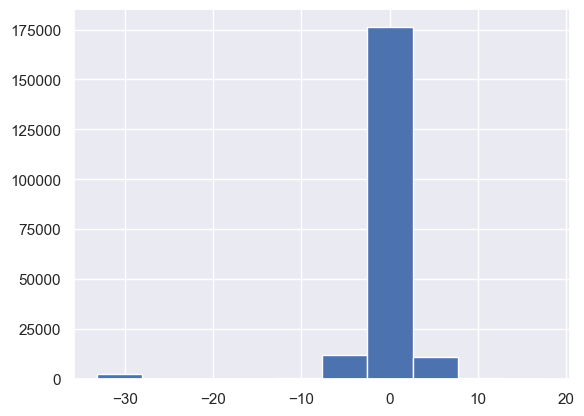

In [439]:
df_train["target"].hist()

In [440]:
df_train_less_20 = df_train[df_train["target"]<-20]
df_train_less_20["card_id"].nunique()

2207

In [443]:
# all card ids present in df_train_less_20  NOT present in df_new_merchants 
diff_df = df_train_less_20["card_id"].isin(df_new_merchants["card_id"]).all()
diff_df

False

In [ ]:
df_train_less_20["feature_sum"] = df_train_less_20["feature_1"]+df_train_less_20["feature_3"]+df_train_less_20["feature_3"]
df_train_less_20

In [ ]:
df_train_less_20["feature_sum"].hist(bins=10, alpha=0.9, label='less 20 target')
df_train["feature_sum"] = df_train["feature_1"]+df_train["feature_2"]+df_train["feature_3"]
df_train["feature_sum"].hist(bins=10, alpha=0.5, label='train')
# Add labels and title
plt.xlabel('times')
plt.ylabel('Frequency')
plt.title('Dist')
# Add legend
plt.legend()

In [ ]:
325540-201917

In [ ]:
df2["merchant_id"].count()

In [ ]:
df2["merchant_id"].nunique()
# repetitions there in merchants file??

In [ ]:
df["merchant_id"].nunique()

In [ ]:
df3["merchant_id"].nunique()

In [ ]:
unique_merchant_ids = df["merchant_id"].unique()
unique_merchant_df = pd.DataFrame(unique_merchant_ids)

unique_merchant_ids_new = df3["merchant_id"].unique()
unique_merchant_df_new = pd.DataFrame(unique_merchant_ids)
unique_merchant_df_new

In [ ]:
concatenated_df = pd.concat([unique_merchant_df, unique_merchant_df_new], axis=0, ignore_index=True)
concatenated_df.nunique()

In [ ]:
# merging dfs now

In [ ]:
merged_df = pd.merge(df, df_train, on='card_id', how='left')
merged_df

In [ ]:
sns.pairplot(merged_df)
plt.show()

In [ ]:
df_test = pd.read_csv('test.csv')
df_test